In [ ]:
import sys

import numpy as np
import pandas as pd
pd.options.display.max_rows = 99

from functools import reduce

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.linear_model import LogisticRegression
from scipy.special import expit

from datetime import datetime, timedelta

from db_queries import get_location_metadata

import warnings
warnings.simplefilter('ignore')

INPUT_DIR = '/ihme/covid-19/deaths/mobility_inputs/2020_04_14'

MOBILITY_FILE = f'{INPUT_DIR}/google_mobility_with_locids.csv'
POP_DENS_FILE = f'{INPUT_DIR}/pop_density.csv'
# MOBILITY_POP_DENS_DIR = '/home/j/WORK/01_covariates/02_inputs/population_density/outputs_2020_covid_mob_20200328'
PEAK_FILE = f'{INPUT_DIR}/final_peak_locs_04_14.csv'


## get dates from deaths file (will want to redo this with a non-model dataset)

In [ ]:
# settings
data_date = pd.Timestamp('2020-04-13')
n_days = 19

# get peak day
peak_day_df = pd.read_csv(PEAK_FILE)
peak_day_df = peak_day_df.loc[peak_day_df['Country/Region'] != 'China']

# drop CO (don't believe), Puglia + Aragon (peak is in future)
peak_day_df = peak_day_df.loc[~peak_day_df['Location'].isin(['Colorado', 'Puglia', 'Aragon'])]

# # filter to admin1s?
# peak_day_df = peak_day_df.loc[peak_day_df['location'].str.endswith(('Germany', 'Italy', 'Spain', 'United States of America'))]

# get `n` days before peak
peak_day_df['Peak date'] = pd.to_datetime(peak_day_df['peak_date'])
peak_day_df['R0 date'] = peak_day_df['Peak date'].apply(lambda x: x - timedelta(days=n_days))
print(f"{', '.join(peak_day_df['Country/Region'].unique().tolist())}")
peak_day_df = peak_day_df.loc[~peak_day_df['Peak date'].isin([data_date - timedelta(days=i) for i in range(3)])]
peak_day_df = peak_day_df[['location_id', 'Peak date', 'R0 date']].reset_index(drop=True)
peak_day_df.head()


## read in and format Google mobility data
#### MANUALLY SUBSETTING ISO-2 BASED ON ORIGINAL LIST ABOVE (OK IF WE HAVE MORE COUNTRIES THAN THAT LIST, BUT NOT FEWER)

In [3]:
mob_df = pd.read_csv(MOBILITY_FILE)
# google_vars = [i for i in mob_df.columns if i.startswith('google_')]
google_vars = ['google_retail_and_recreation', 'google_transit_stations', 'google_workplaces']
mob_df['Date'] = pd.to_datetime(mob_df['date'])
mob_df = mob_df.loc[~mob_df['location_id'].isnull()]
mob_df['location_id'] = mob_df['location_id'].astype(int)
mob_df['avg_mobility'] = mob_df[google_vars].mean(axis=1)
mob_df['Location'] = mob_df['location_name']
mob_df = mob_df[['location_id', 'Location', 'Date', 'avg_mobility']]
# print(f"No matches for {'; '.join([i for i in peak_day_df['Location'].unique().tolist() if i not in mob_df['Location'].unique()])}")
mob_df.head()


location_id                    Location       Date  avg_mobility
22403            8  Taiwan (Province of China) 2020-02-23     -5.933460
22404            8  Taiwan (Province of China) 2020-02-24     -4.077135
22405            8  Taiwan (Province of China) 2020-02-25     -2.983683
22406            8  Taiwan (Province of China) 2020-02-26     -1.414141
22407            8  Taiwan (Province of China) 2020-02-27     -8.603518

## load population density

In [4]:
pop_dens_df = pd.read_csv(POP_DENS_FILE)

# just take >= 1000
pop_dens_df.loc[
    pop_dens_df['pop_density'].isin(['1000-2500 ppl/sqkm', '2500-5000 ppl/sqkm', '5000-10000 ppl/sqkm', '10000-20000 ppl/sqkm', '>=20000 ppl/sqkm']),
    'pop_density'
] = '>=1000 ppl/sqkm'
pop_dens_df = pop_dens_df.loc[pop_dens_df['pop_density'] == '>=1000 ppl/sqkm']
pop_dens_df = pop_dens_df.groupby(['location_id', 'location_name', 'pop_density'], as_index=False)['pop_proportion'].sum()

# reshape
pop_dens_df = pd.pivot_table(pop_dens_df, index=['location_id', 'location_name'], 
                             columns='pop_density', values='pop_proportion').reset_index()
pop_dens_df = pop_dens_df.rename(index=str, columns={'location_name':'Location'})
pop_dens_vars = [i for i in pop_dens_df.columns if i not in ['location_id', 'Location']]
pop_dens_df.head()


pop_density  location_id    Location  >=1000 ppl/sqkm
0                    523     Alabama         0.212769
1                    524      Alaska         0.456148
2                    525     Arizona         0.711787
3                    526    Arkansas         0.247675
4                    527  California         0.848981

## get interacted pop dens * mobility variables

In [5]:
# interaction_files = {
#     # 'residential': 'all_outputs_2020_rs.csv', 
#     'retail_rec': 'all_outputs_2020_rr.csv', 
#     'transit': 'all_outputs_2020_ts.csv', 
#     'work': 'all_outputs_2020_wk.csv'
# }

# int_dfs = []
# for google_metric, file_name in interaction_files.items():
#     int_df = pd.read_csv(f'{MOBILITY_POP_DENS_DIR}/{file_name}')
#     int_df.loc[
#         int_df['pop_density'].isin(['<150 ppl/sqkm', '150-300 ppl/sqkm', '300-500 ppl/sqkm']),
#         'pop_density'
#     ] = '<500 ppl/sqkm'
#     int_df.loc[
#         int_df['pop_density'].isin(['500-1000 ppl/sqkm', '1000-2500 ppl/sqkm', '2500-5000 ppl/sqkm']),
#         'pop_density'
#     ] = '500-5000 ppl/sqkm'
#     int_df.loc[
#         int_df['pop_density'].isin(['10000-20000 ppl/sqkm', '>=20000 ppl/sqkm']),
#         'pop_density'
#     ] = '>=10000 ppl/sqkm'
#     int_df['Date'] = pd.to_datetime(int_df['date'])
#     int_df = int_df.groupby(['location_id', 'location_name', 'Date', 'pop_density'], as_index=False)['pop_proportion'].sum()
#     int_df = pd.pivot_table(int_df, index=['location_id', 'location_name', 'Date'], 
#                             columns='pop_density', values='pop_proportion').reset_index()
#     int_dfs.append(int_df)
    
# # combine dataframes
# int_df = pd.concat(int_dfs)
# int_df = int_df.groupby(['location_id', 'location_name', 'Date'], as_index=False)[pop_dens_vars].mean()
# int_df = int_df.rename(index=str, columns={'location_name':'Location'})
# int_vars = [i for i in int_df.columns if i not in ['location_id', 'Location', 'Date']]

# # add iso2 placeholder just for US
# loc_df = get_location_metadata(location_set_id=35, gbd_round_id=6)
# int_df = int_df.merge(loc_df[['location_id', 'parent_id']])
# int_df['iso2'] = 'XX'
# int_df.loc[int_df['parent_id'] == 102, 'iso2'] = 'US'
# int_df.loc[int_df['parent_id'] == 81, 'iso2'] = 'DE'
# del int_df['parent_id']
# int_df.head()


## flag date since closure

In [6]:
closure_vars = [
    'Any Gathering Restrictions', 'People instructed to stay at home', 
    'Educational facilities closed',
    'Any Business Closures', 'Non-essential services closed (i.e., bars/restaurants)'
]  
closure_df = pd.read_excel('/ihme/covid-19/snapshot-data/best/covid_onedrive/Decrees for Closures/closure_criteria_sheet.xlsx')
closure_df = closure_df.loc[(~closure_df['merge_name'].isnull()) & (~closure_df['location_id'].isnull())]
closure_df = closure_df[['location_id'] + closure_vars]
for closure_var in closure_vars:
    closure_df[closure_var] = closure_df[closure_var].apply(
        lambda x: datetime.strptime(x, '%d.%m.%Y') if isinstance(x, str) and x[0].isdigit() else np.nan
    )

# give partial credit
closure_df.loc[closure_df['People instructed to stay at home'] == 1, 
               'Any Gathering Restrictions'] = closure_df['People instructed to stay at home']
closure_df.loc[closure_df['Non-essential services closed (i.e., bars/restaurants)'] == 1, 
               'Any Business Closures'] = closure_df['Non-essential services closed (i.e., bars/restaurants)']

# assign dummies
closure_df['location_id'] = closure_df['location_id'].astype(int)
closure_df = closure_df.merge(mob_df[['location_id', 'Date']])
for closure_var in closure_vars:
    closure_df[closure_var] = closure_df.apply(lambda x: 1 if x['Date'] >= x[closure_var] else 0, axis=1)
closure_df.head()


location_id  Any Gathering Restrictions  People instructed to stay at home  \
0        60377                           0                                  0   
1        60377                           0                                  0   
2        60377                           0                                  0   
3        60377                           0                                  0   
4        60377                           0                                  0   

   Educational facilities closed  Any Business Closures  \
0                              0                      0   
1                              0                      0   
2                              0                      0   
3                              0                      0   
4                              0                      0   

   Non-essential services closed (i.e., bars/restaurants)       Date  
0                                                  0      2020-02-23  
1                                                  0      2020-02-24  
2                                                  0      2020-02-25  
3                                                  0      2020-02-26  
4                                                  0      2020-02-27

## get model dataset for separate pop density and Google metric variables

In [7]:
# combine datasets
def prepare_model_inputs(df_list, indep_vars):
    model_df = reduce(lambda x, y: pd.merge(x, y, how='outer'), df_list)
    model_df = model_df.loc[~model_df[indep_vars].isnull().any(axis=1)]
    model_df['location_id'] = model_df['location_id'].astype(int)

    # fill in our variable
    model_df['R0<=1'] = 0
    model_df.loc[model_df['Date'] >= model_df['R0 date'], 'R0<=1'] = 1

    # add dummy for US/non-US and Germany/non-Germany
    loc_df = get_location_metadata(location_set_id=111, location_set_version_id=630)
    us_loc_ids = loc_df.loc[loc_df['parent_id'] == 102, 'location_id'].to_list()
    deu_loc_ids = loc_df.loc[loc_df['parent_id'] == 81, 'location_id'].to_list()
    #
    model_df['US'] = 0
    model_df.loc[model_df['location_id'].isin(us_loc_ids), 'US'] = 1
    #
    model_df['DE'] = 0
    model_df.loc[model_df['location_id'].isin(deu_loc_ids), 'DE'] = 1

    # subset out prediction data
    pred_df = model_df.copy()

    # drop ANY nulls for actual model data
    model_df = model_df.loc[~model_df.isnull().any(axis=1)]
    model_locs = model_df['location_id'].unique()

    # # split off test locs
    # np.random.seed(15243)
    # test_locs_idx = np.random.choice(model_locs.size, n, replace=False)
    # train_locs = np.delete(model_locs, test_locs_idx, 0)
    # # train_locs = np.array([i for i in train_locs if i != 541])
    # test_locs = model_locs[test_locs_idx]
    # # test_locs = np.array([541] + [i for i in test_locs if i != 541])
    # train_df = model_df.loc[model_df['location_id'].isin(train_locs)]
    # test_df = model_df.loc[model_df['location_id'].isin(test_locs)]
    
    return model_df, pred_df

model_df, pred_df = prepare_model_inputs([peak_day_df, closure_df, mob_df], # pop_dens_df
                                          closure_vars + ['avg_mobility'])  #  pop_dens_vars + 
# int_model_df, int_pred_df = prepare_model_inputs([peak_day_df, int_df], 
#                                                  int_vars)


## run both models

In [8]:
np.random.seed(15243)
# same dep var
lhs = 'R0<=1'

## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ##
# separate model
rhs = closure_vars  # + ['avg_mobility']
logistic_model = LogisticRegression()
logistic_model.fit(
    model_df[rhs], model_df[lhs]
)
pred_df['probability'] = logistic_model.predict_proba(pred_df[rhs])[:, 1]

coef_dict = dict(zip(rhs, logistic_model.coef_[0].tolist()))
## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ##

# ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ##
# ## interaction model
# int_rhs = int_vars + ['US', 'DE']
# logistic_model = LogisticRegression(max_iter=1000)
# logistic_model.fit(
#     int_model_df[int_rhs], int_model_df[lhs]
# )
# int_pred_df['probability'] = logistic_model.predict_proba(int_pred_df[int_rhs])[:, 1]
# int_pred_df = int_pred_df.sort_values(['iso2', 'Location']).reset_index(drop=True)

# int_coef_dict = dict(zip(int_rhs, logistic_model.coef_[0].tolist()))
# ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ##


In [9]:
coef_dict

{'Any Gathering Restrictions': 0.21651661657868665,
 'People instructed to stay at home': 2.404679836246035,
 'Educational facilities closed': 1.9798273741435921,
 'Any Business Closures': 0.23403047931945492,
 'Non-essential services closed (i.e., bars/restaurants)': 3.037219928071225}

## store and plot predictions

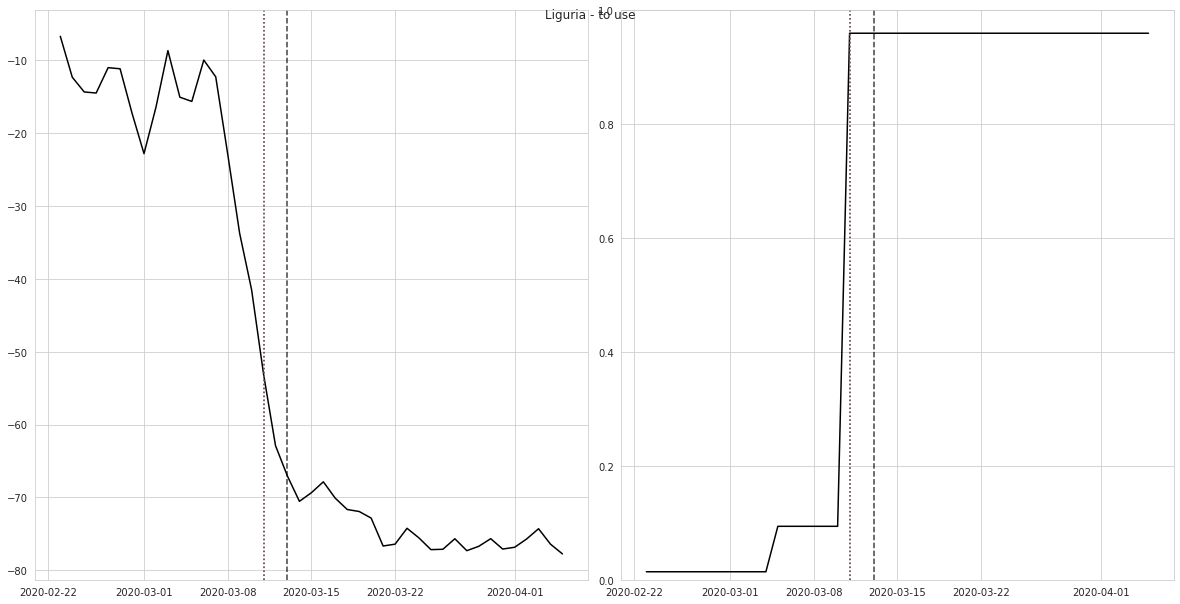

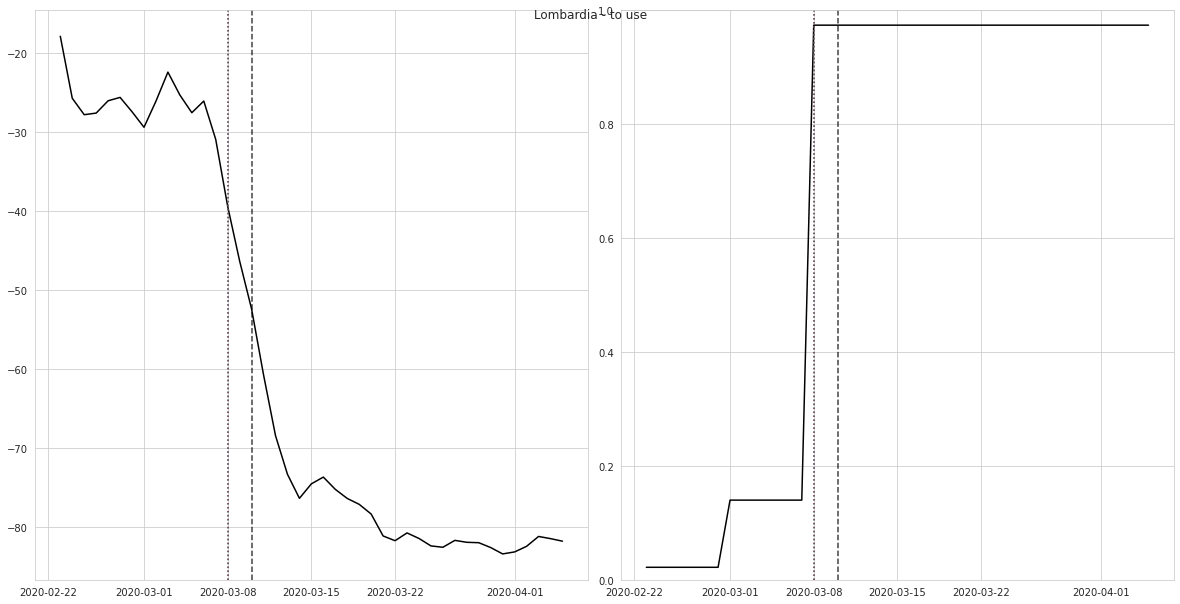

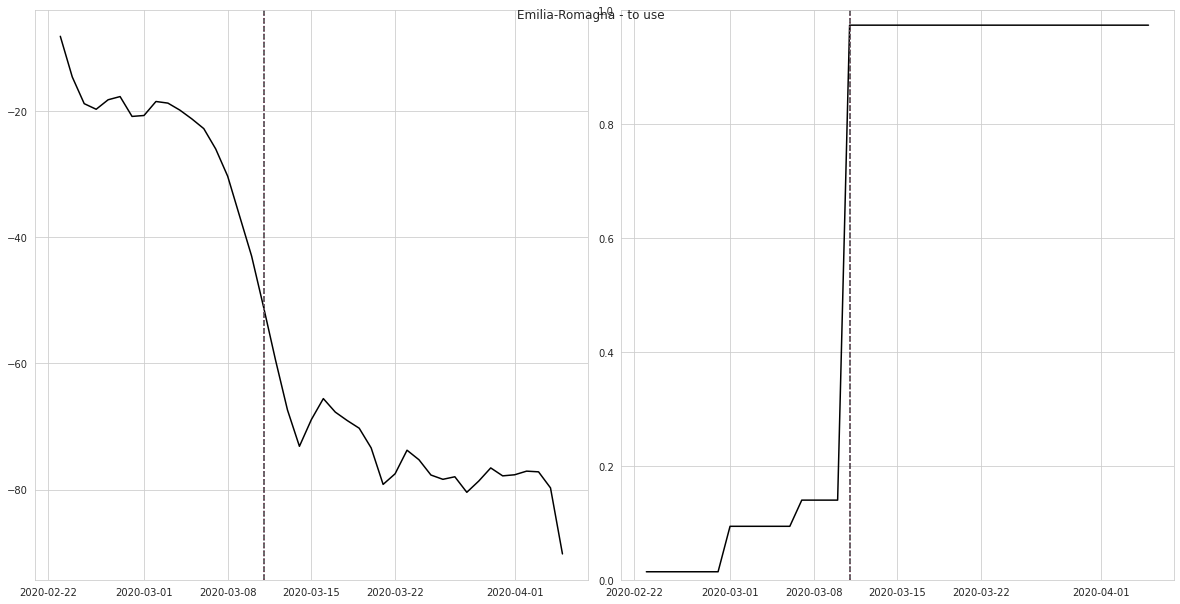

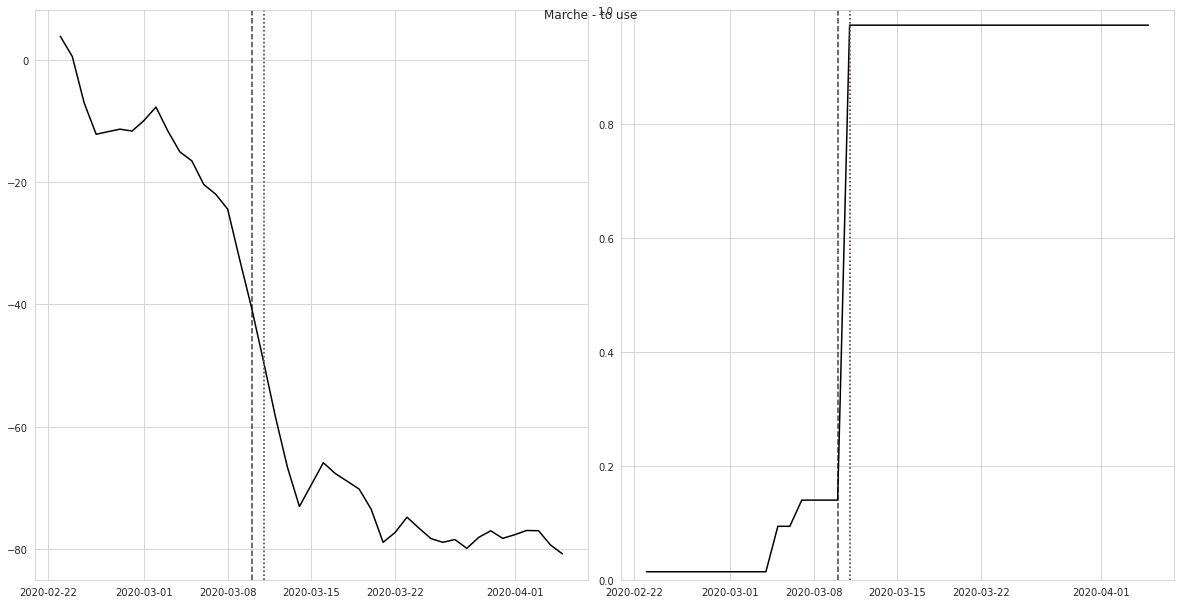

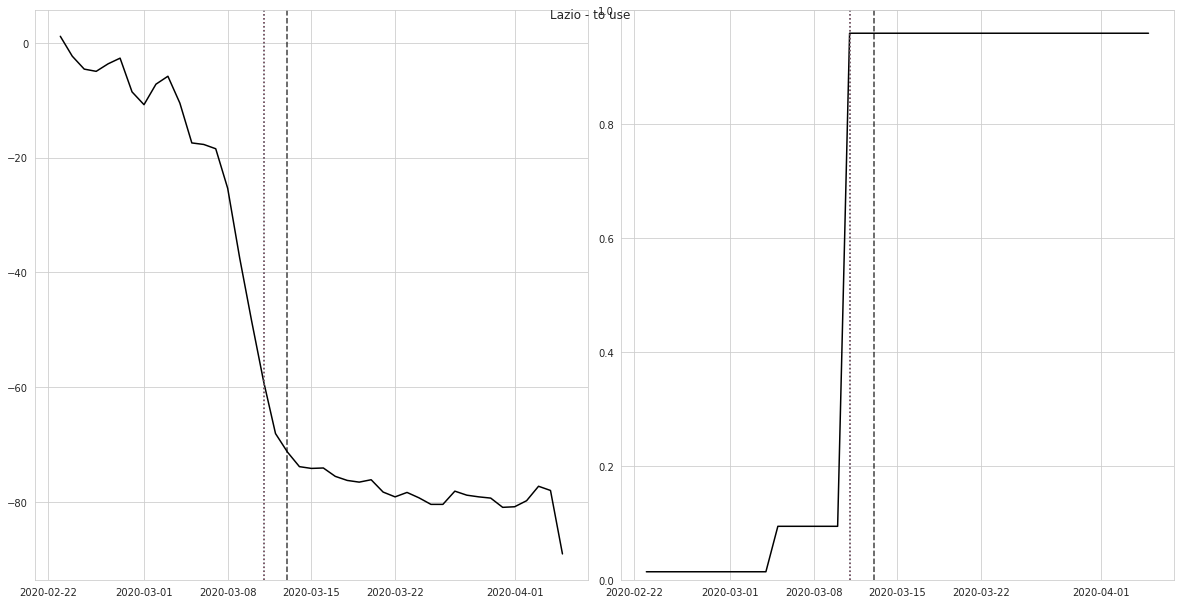

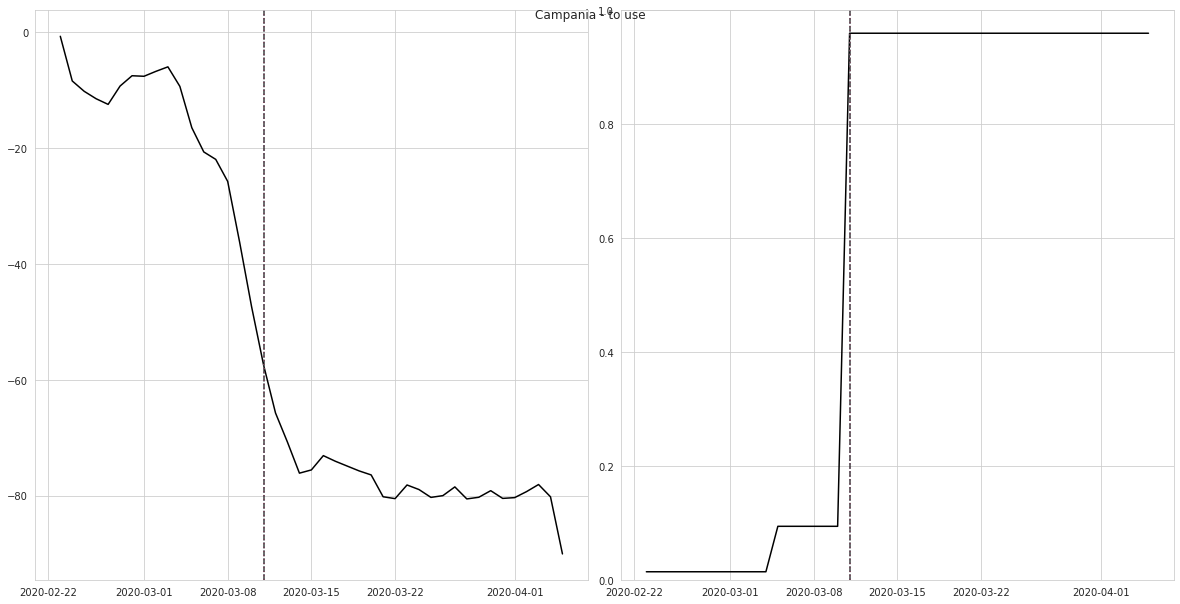

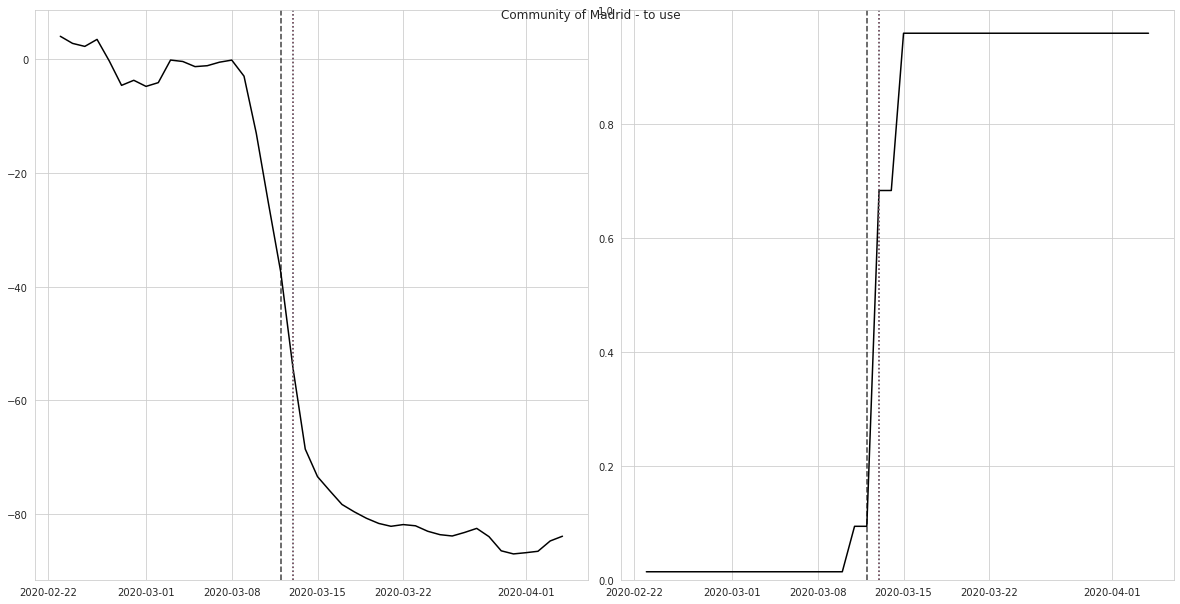

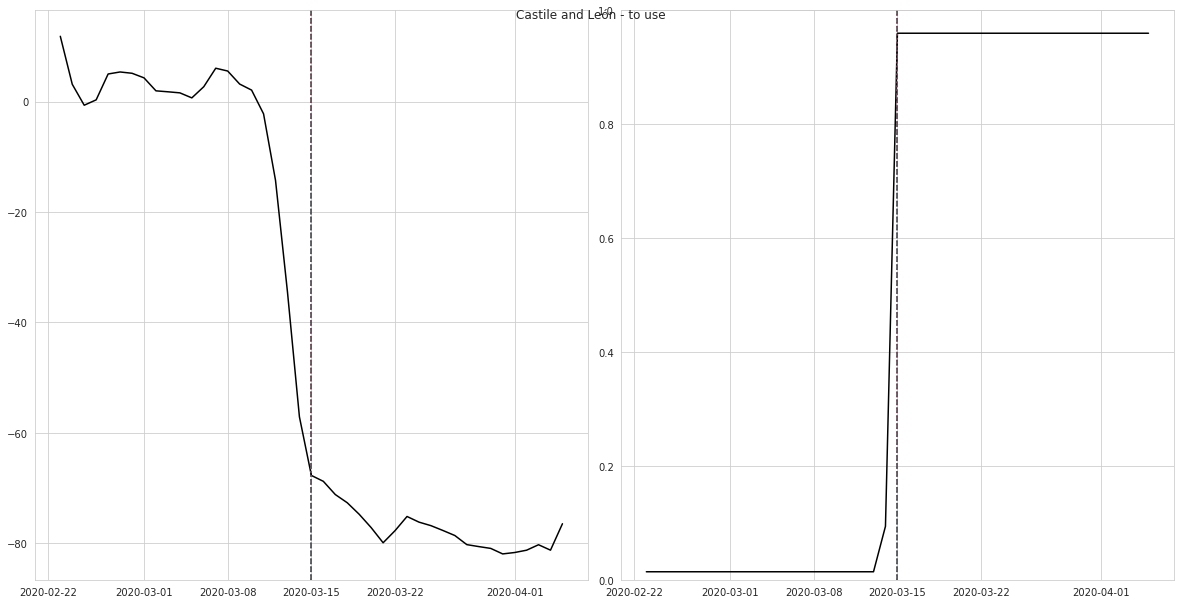

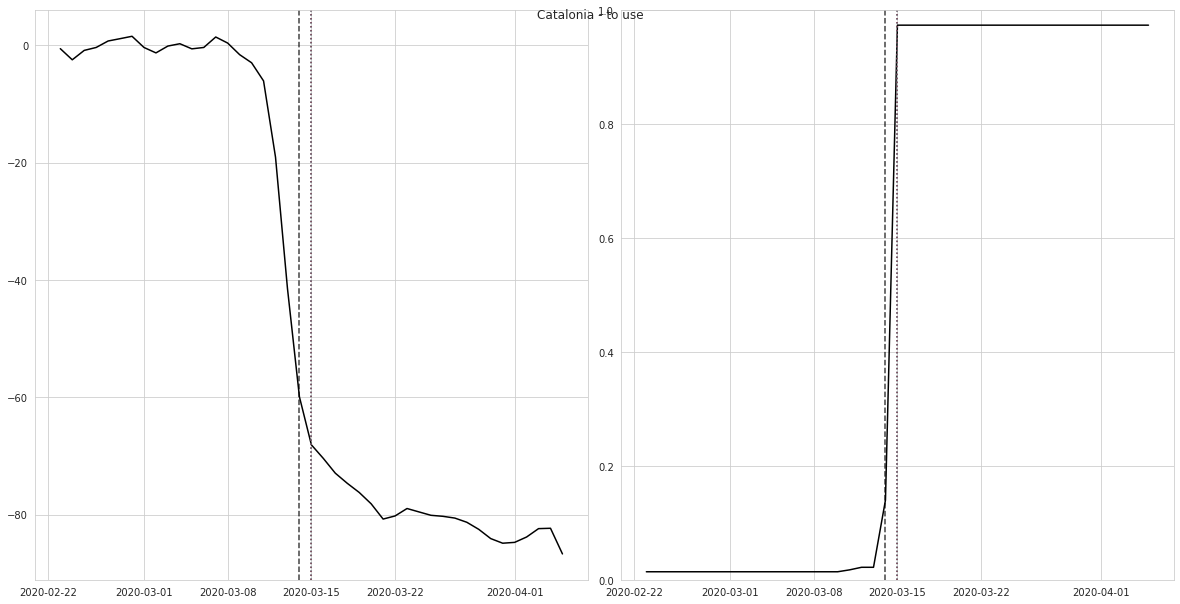

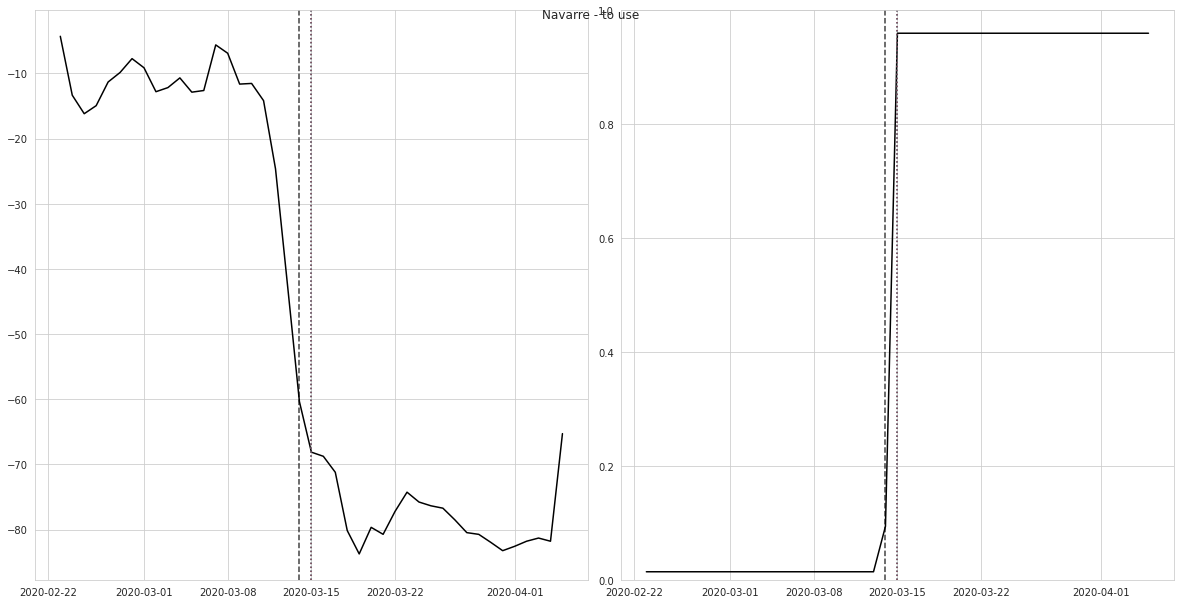

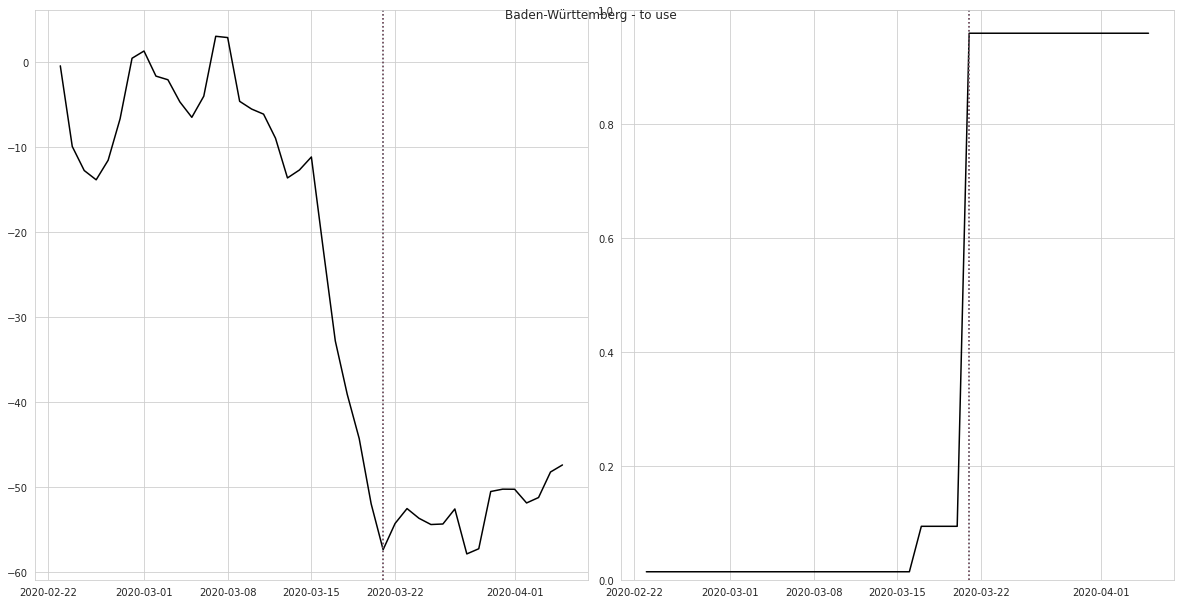

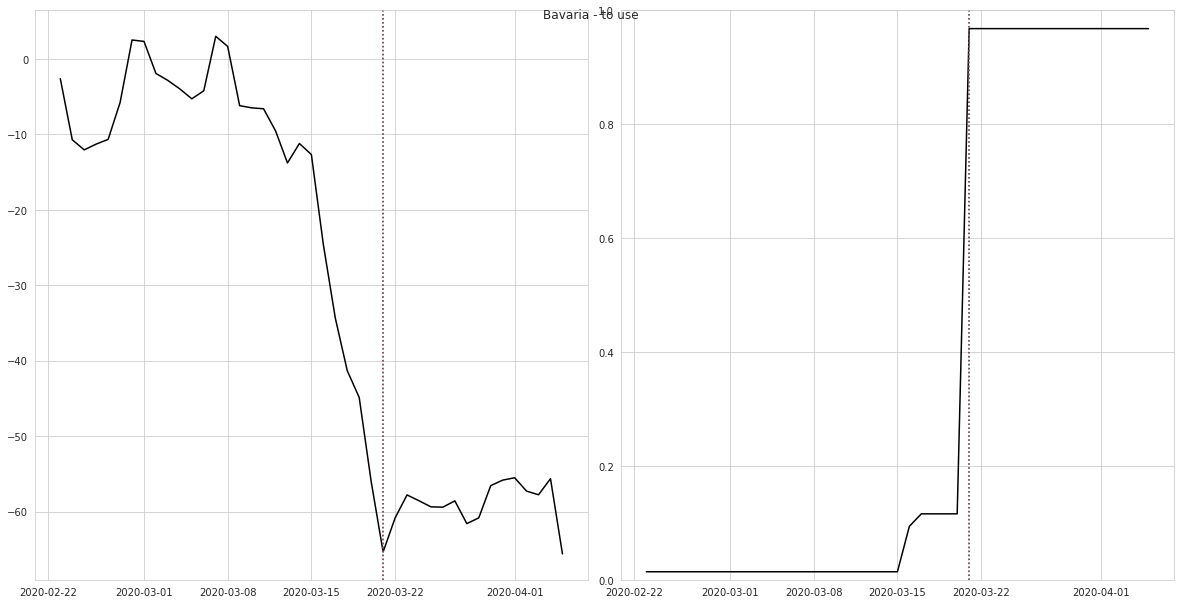

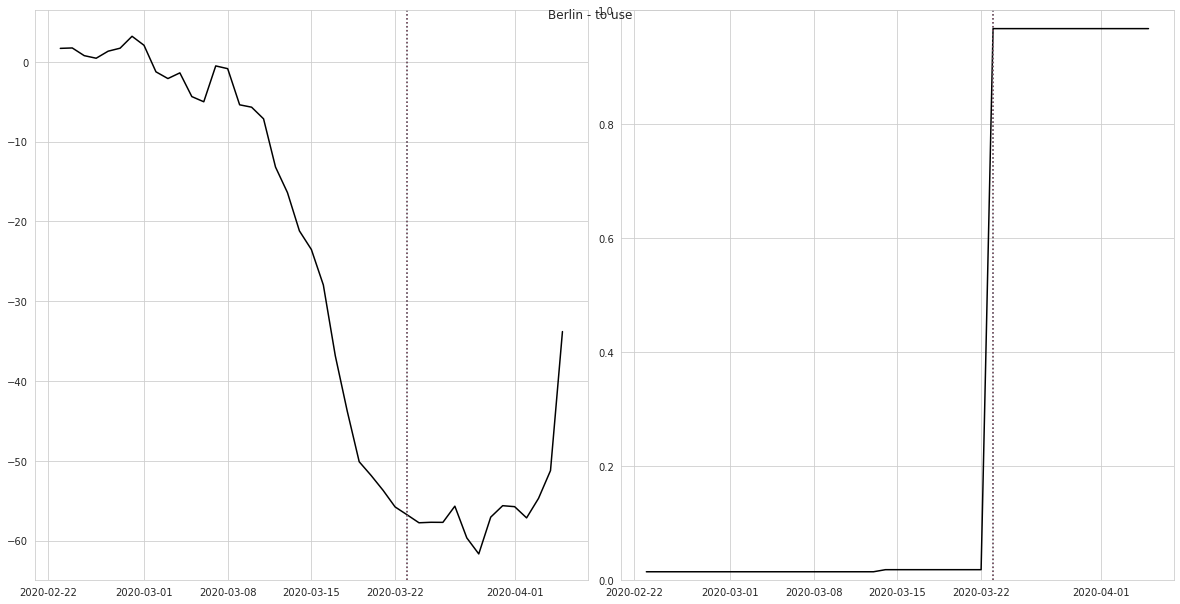

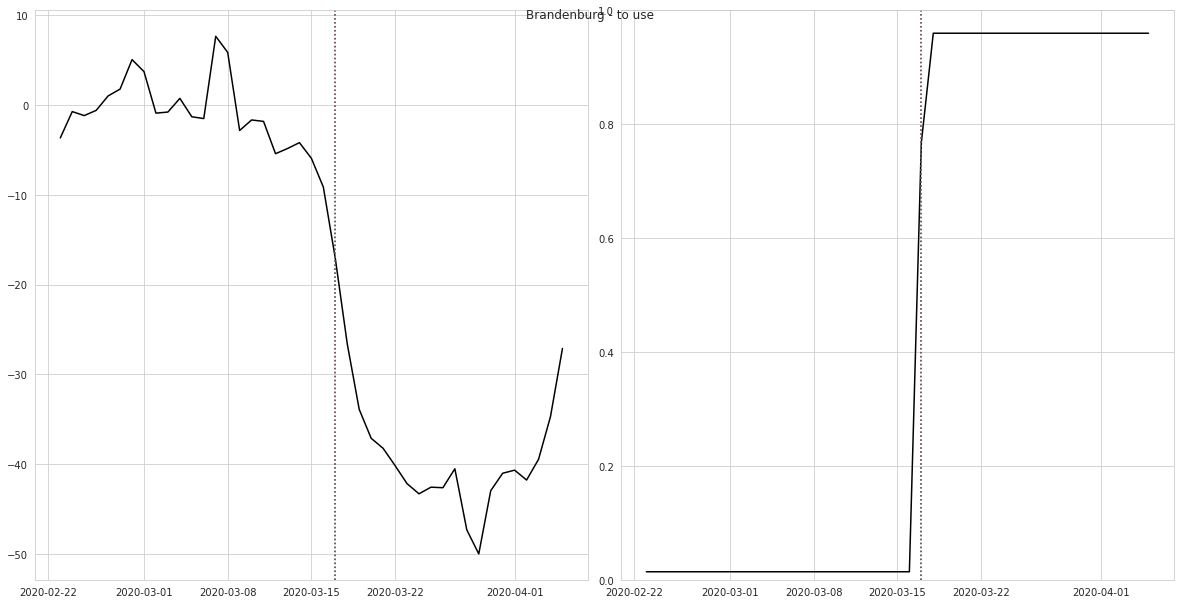

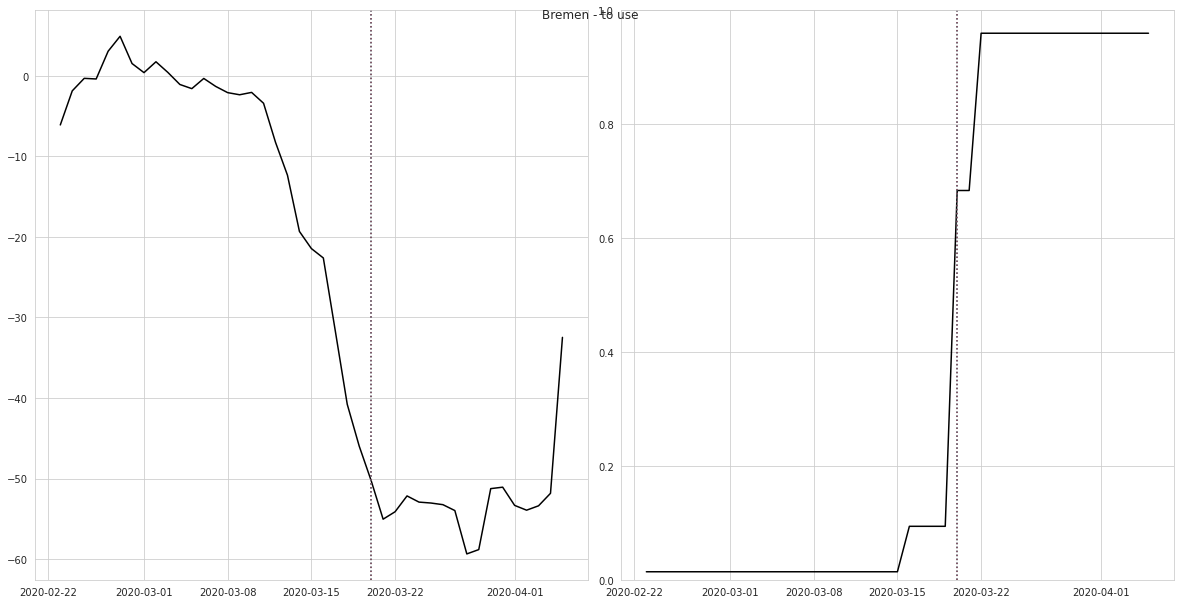

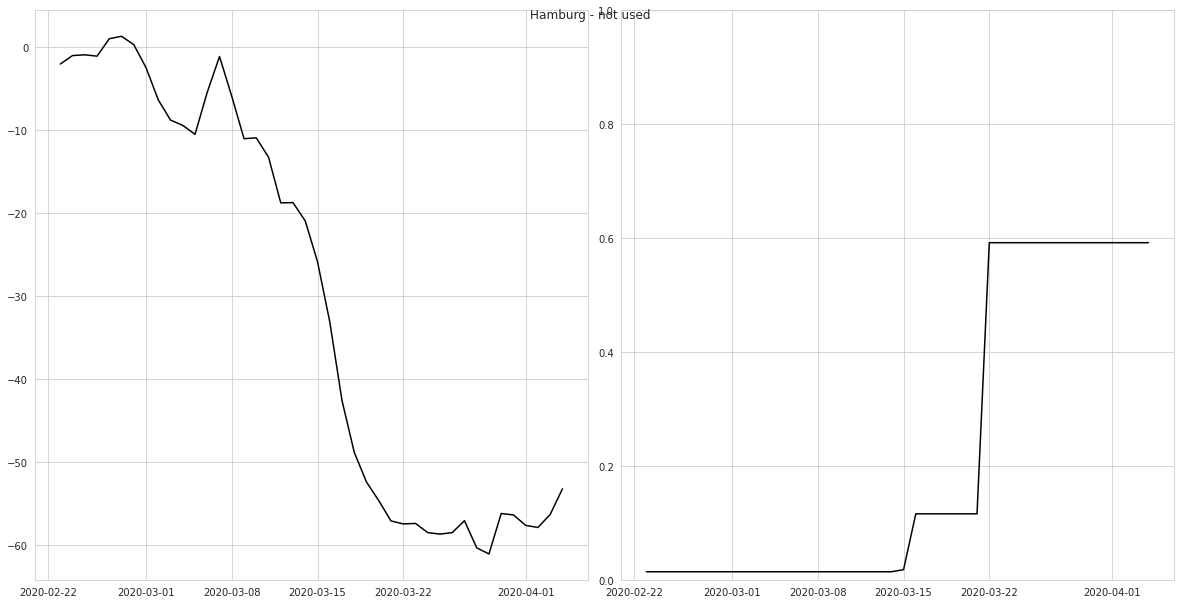

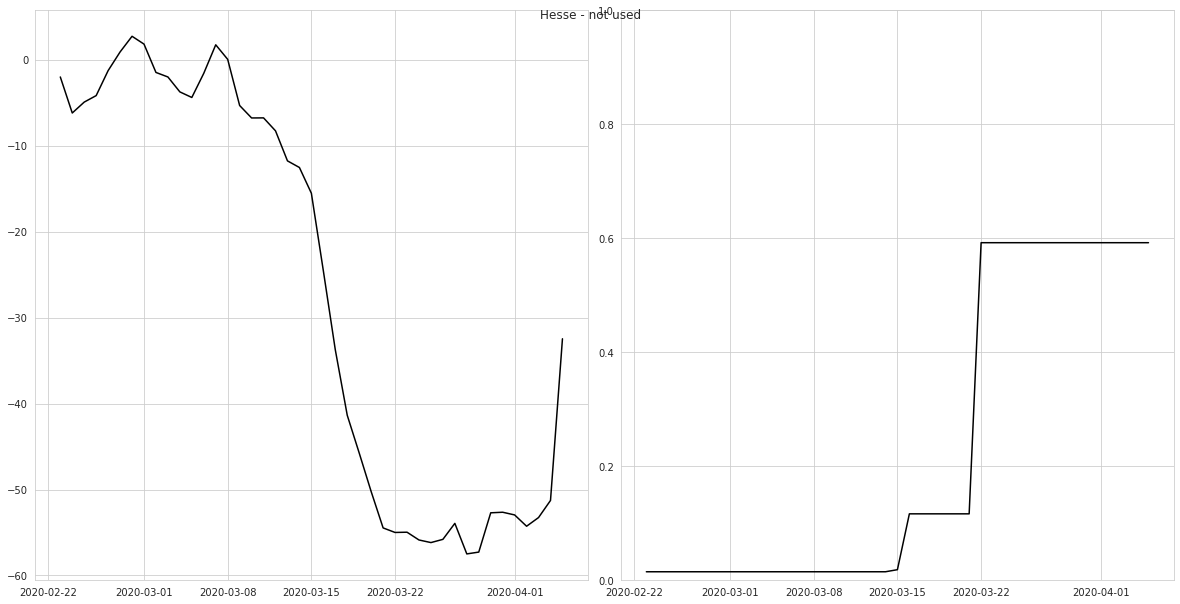

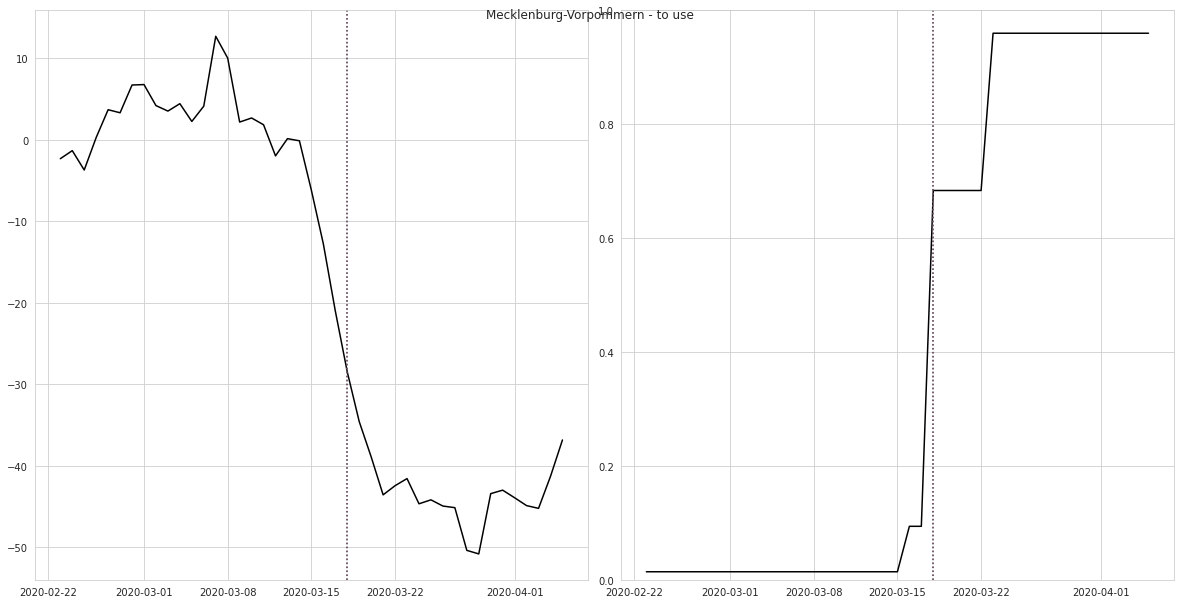

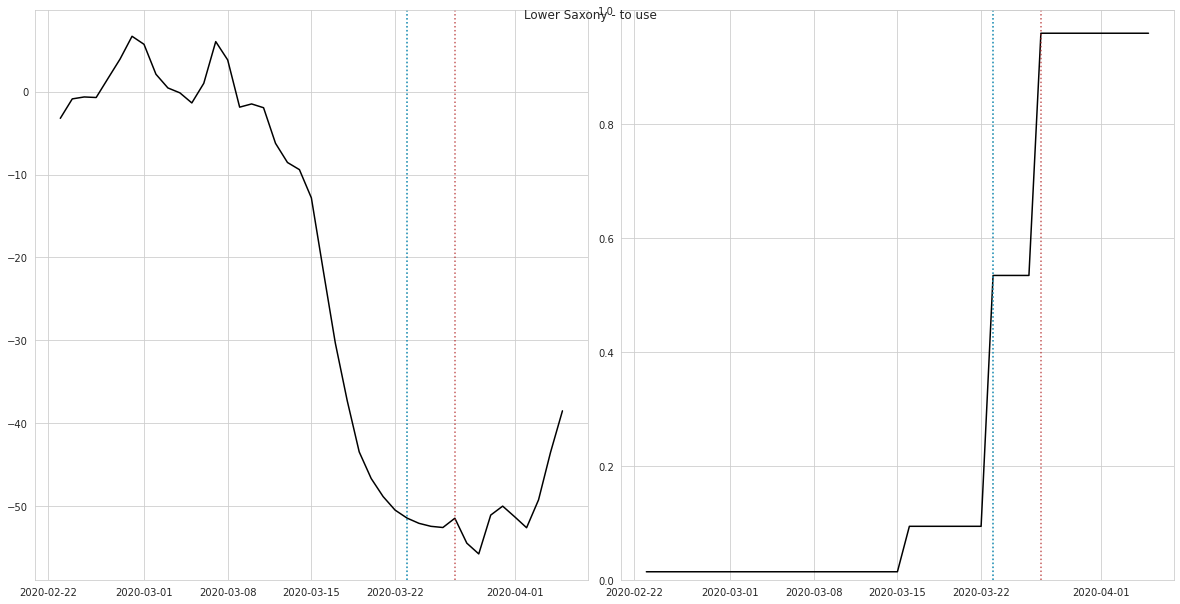

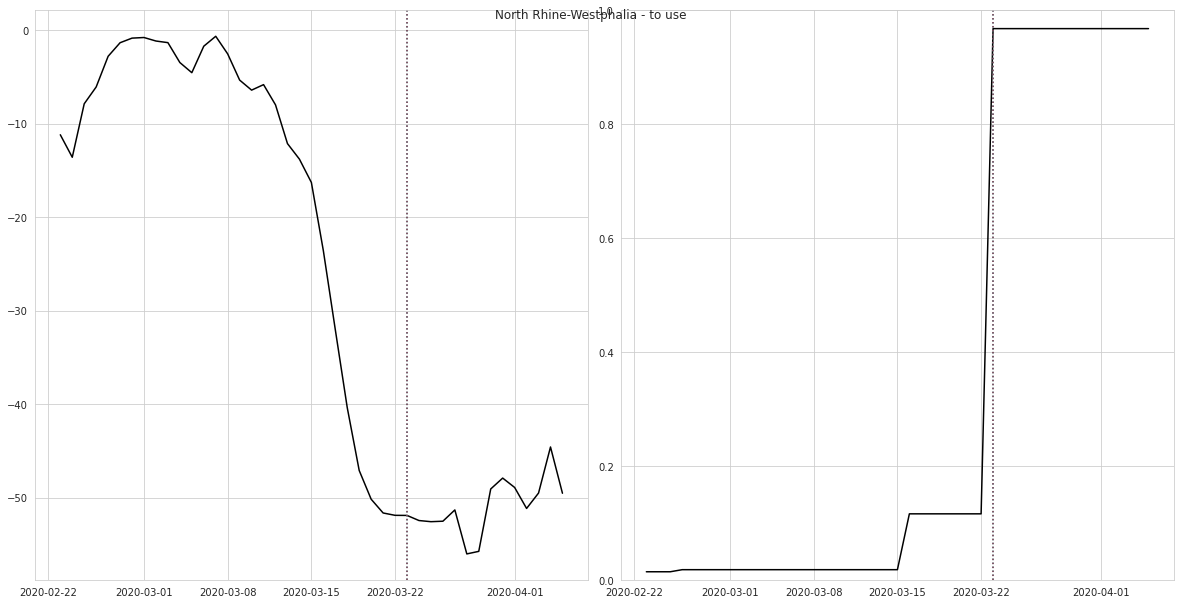

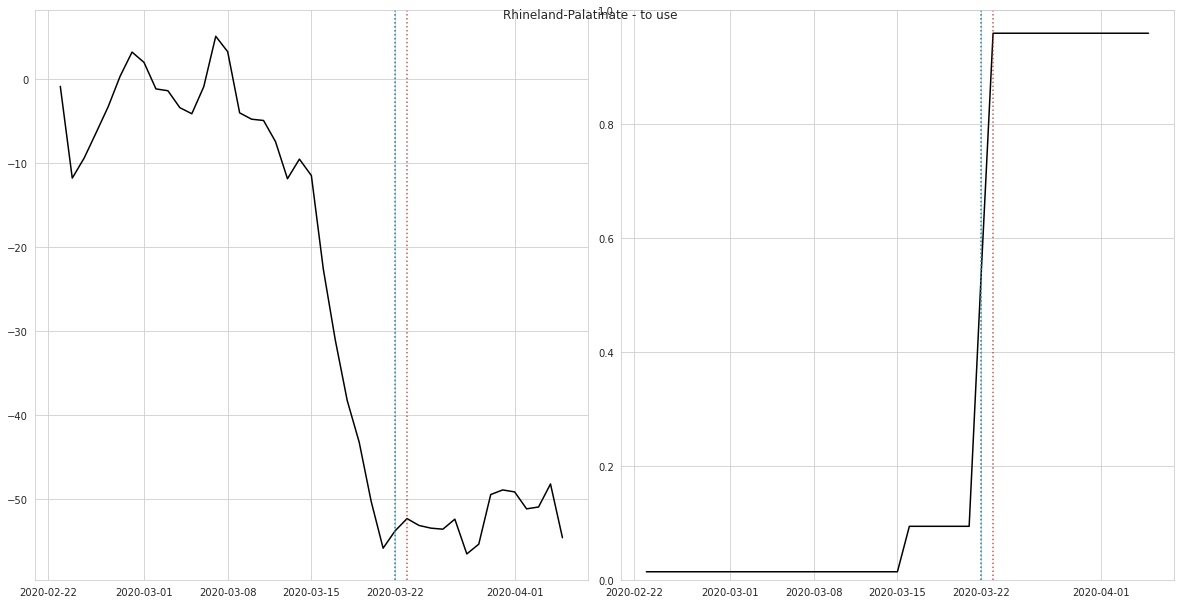

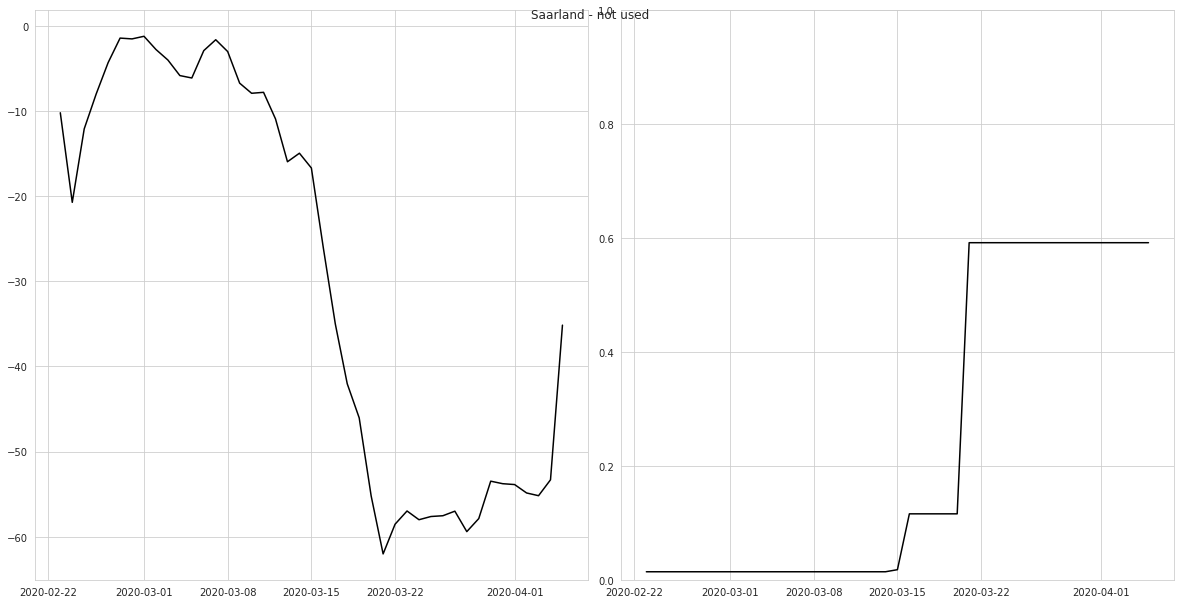

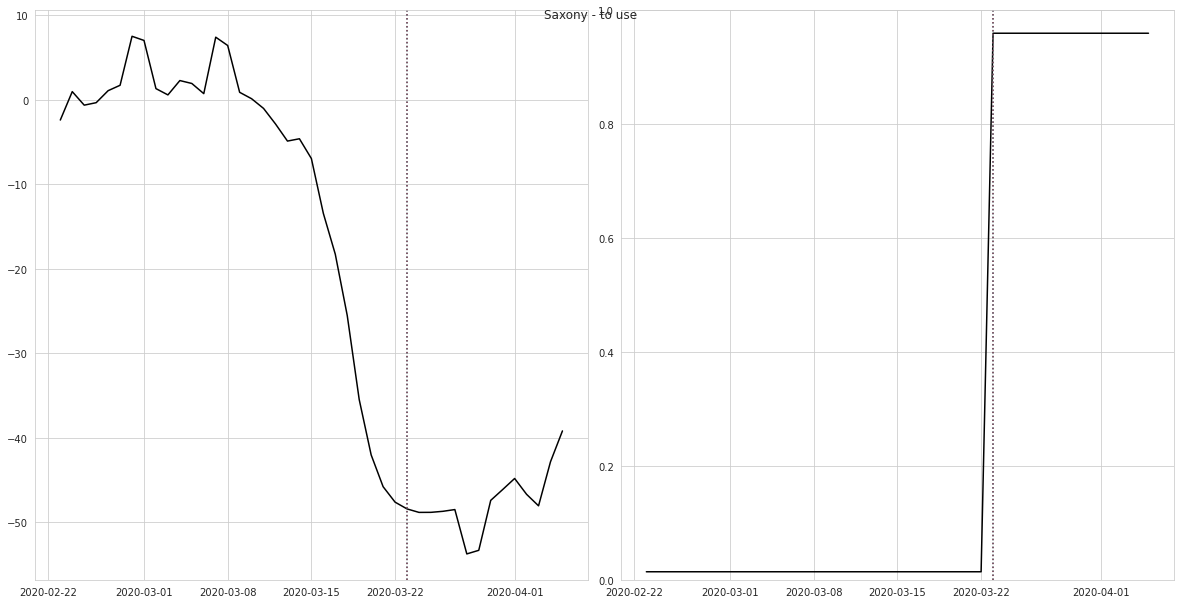

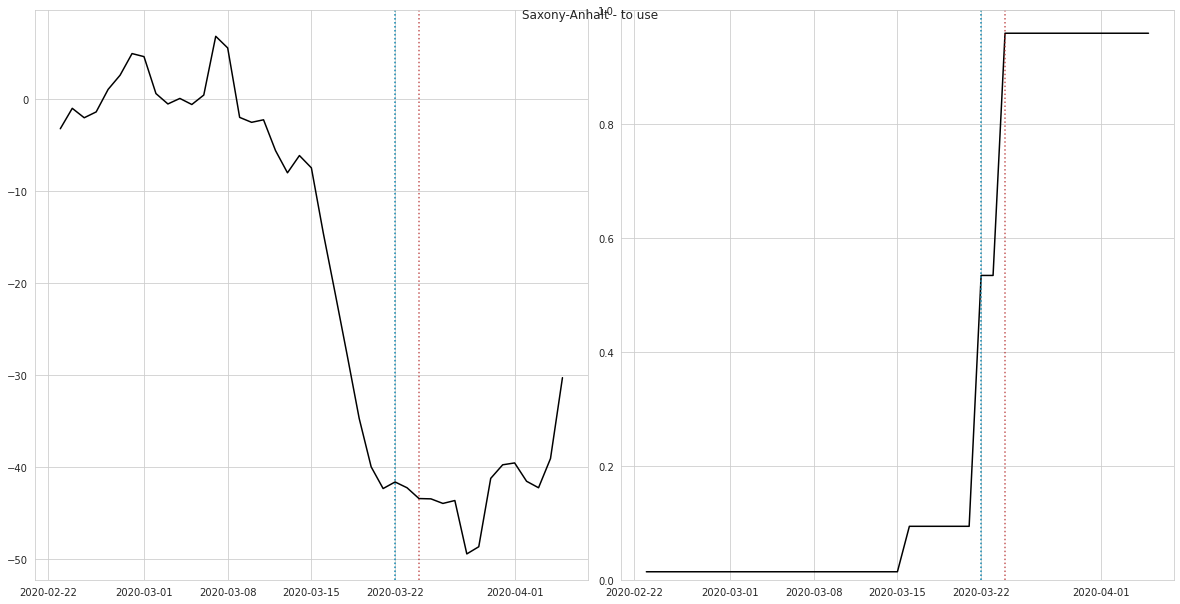

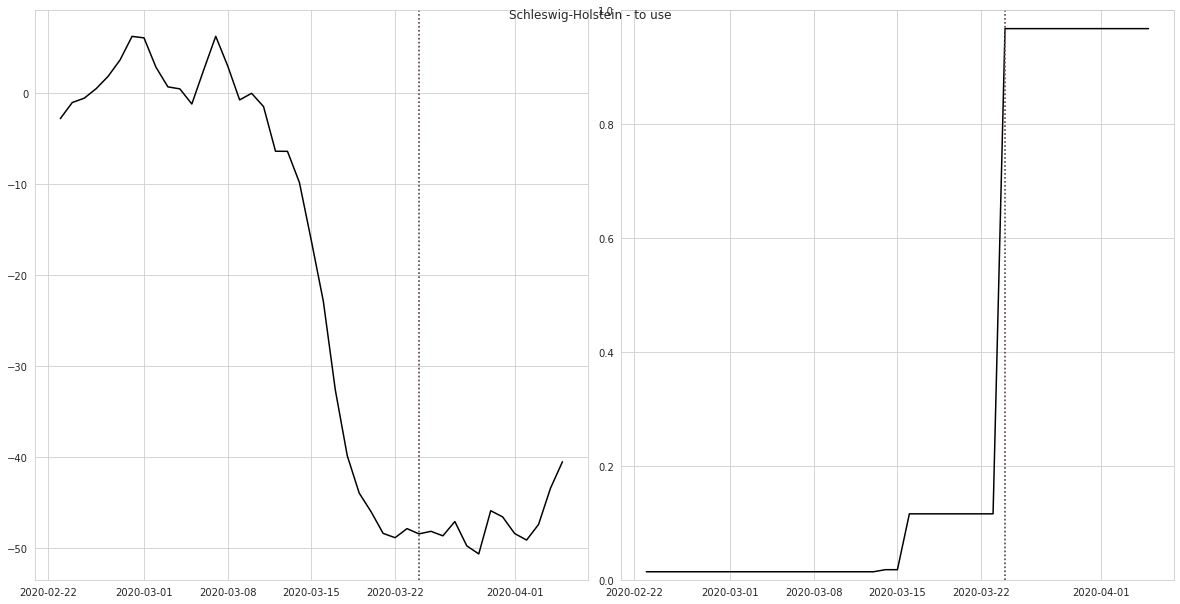

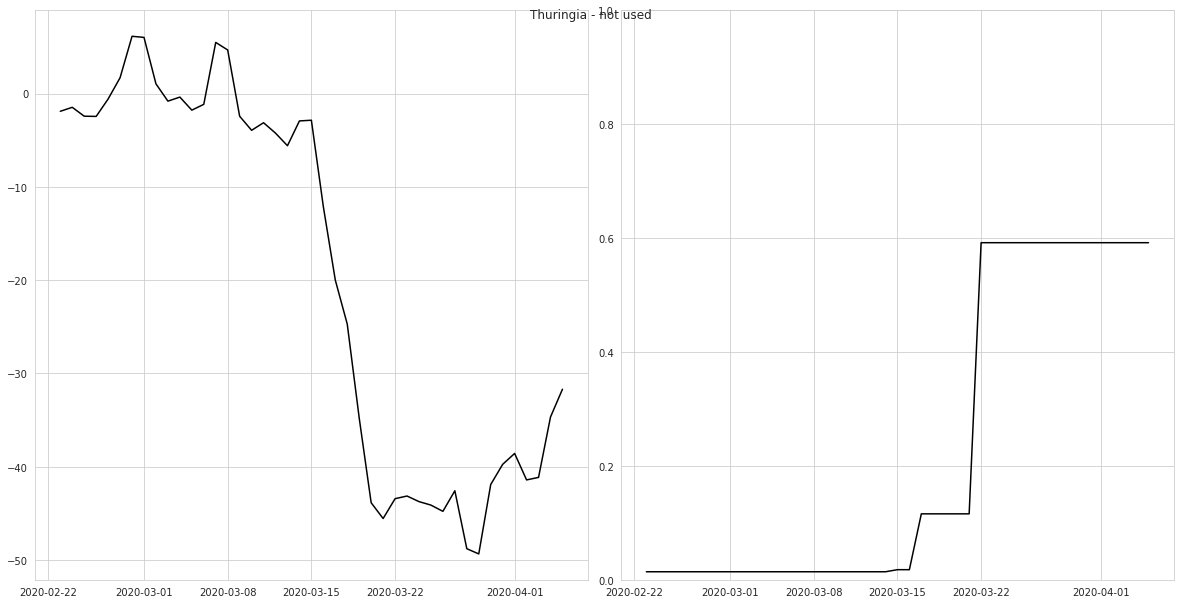

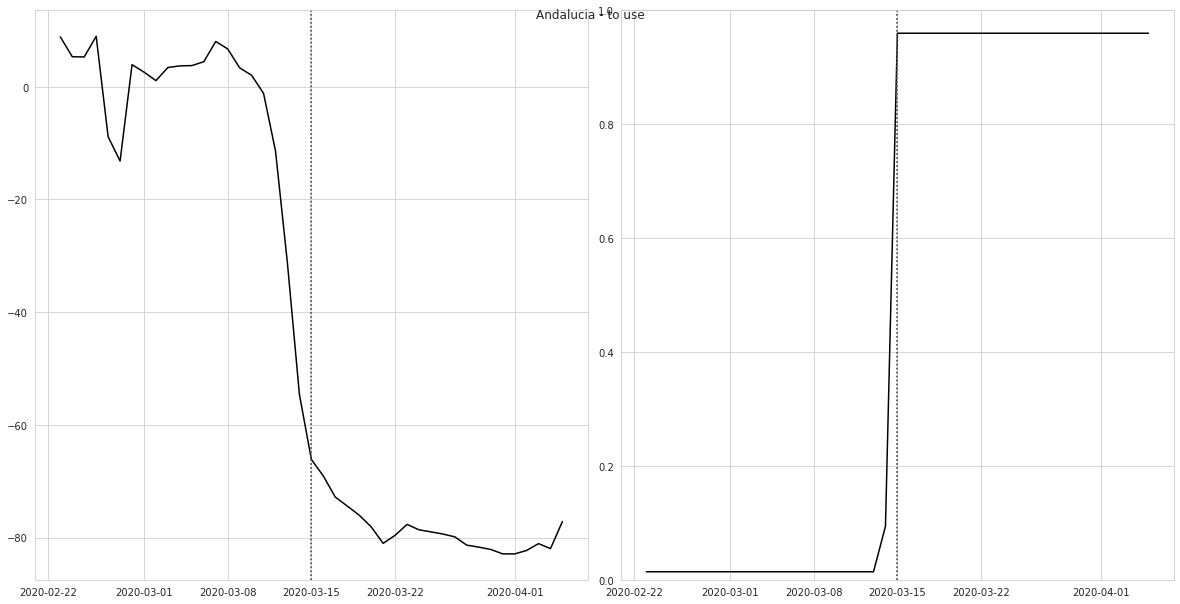

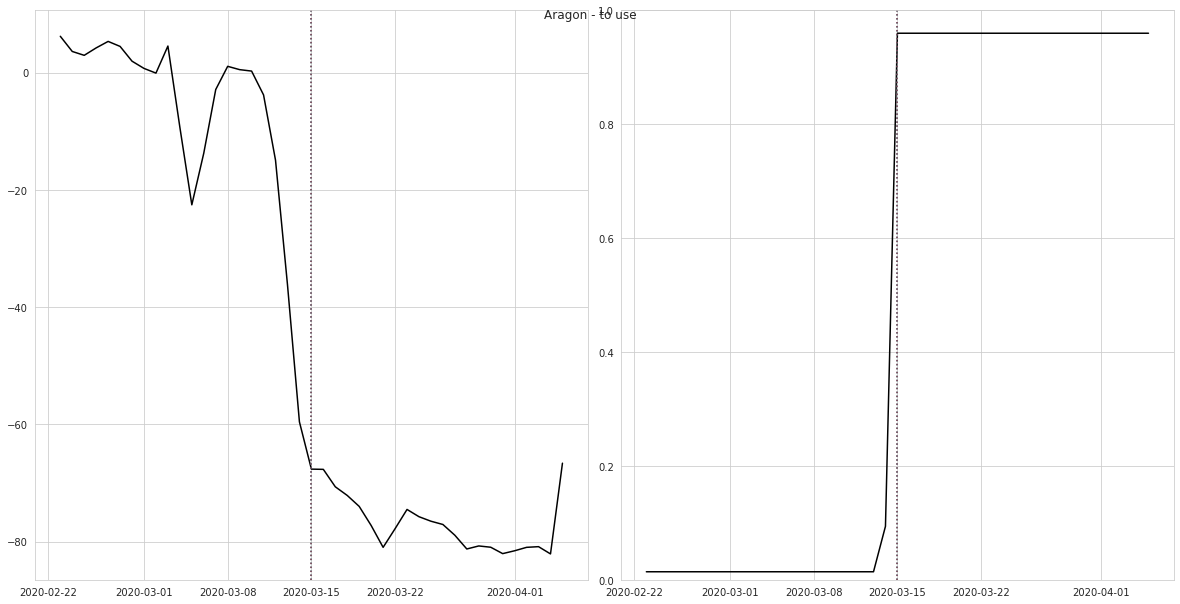

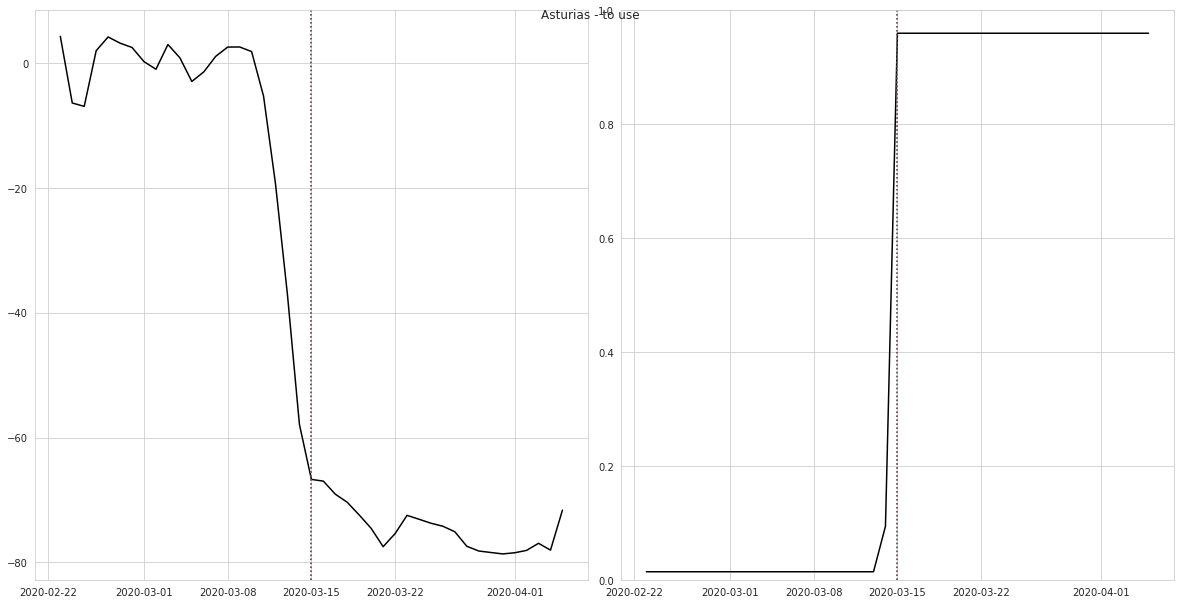

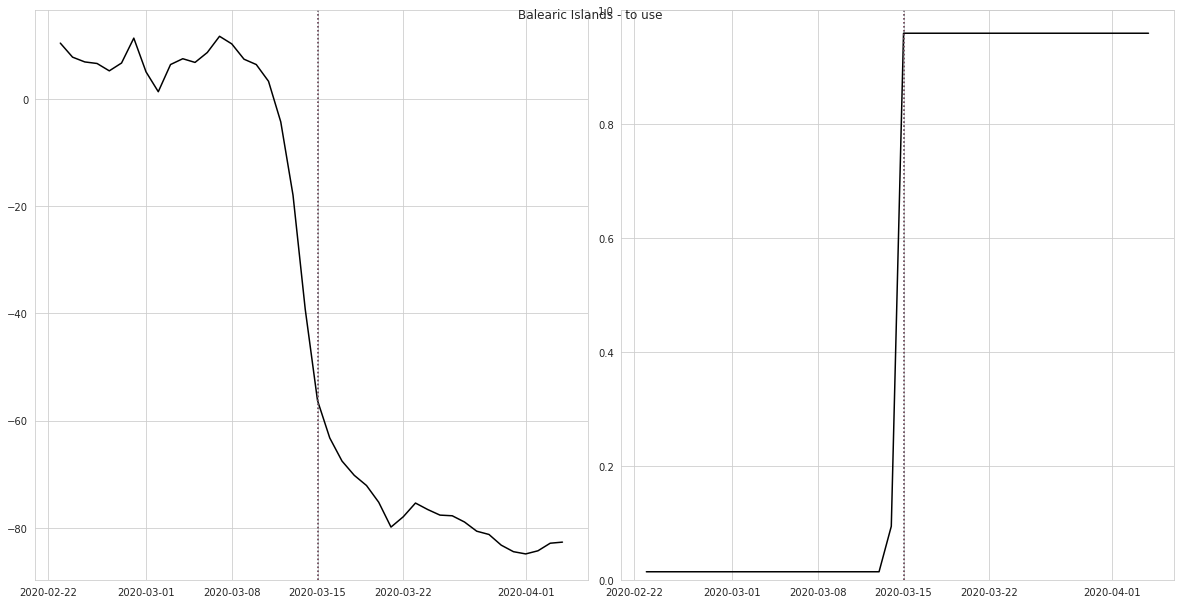

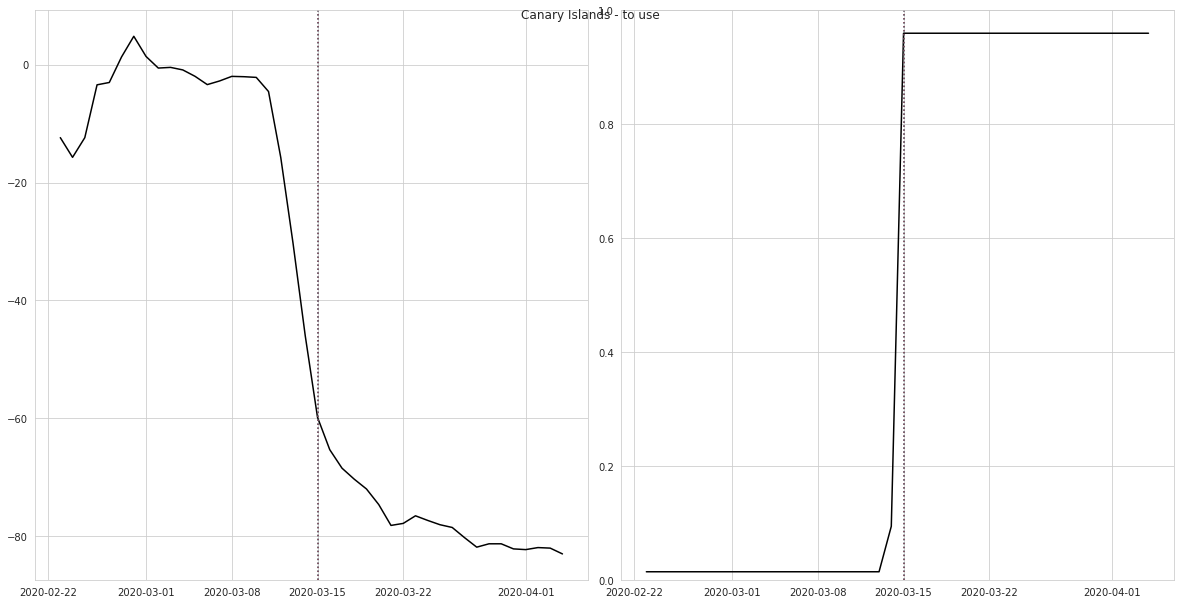

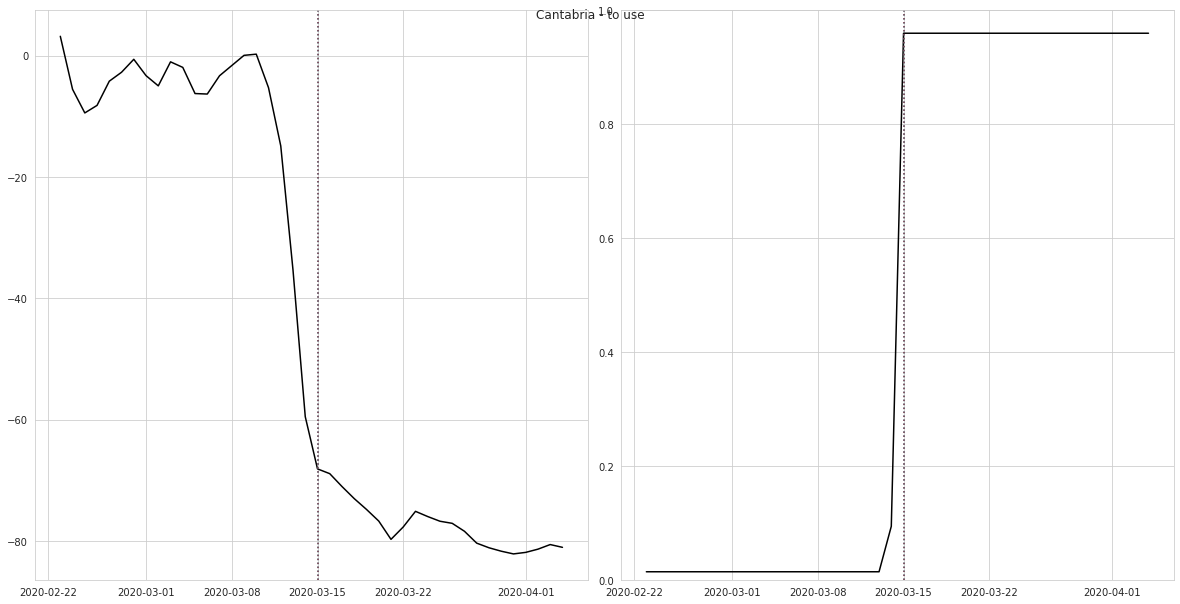

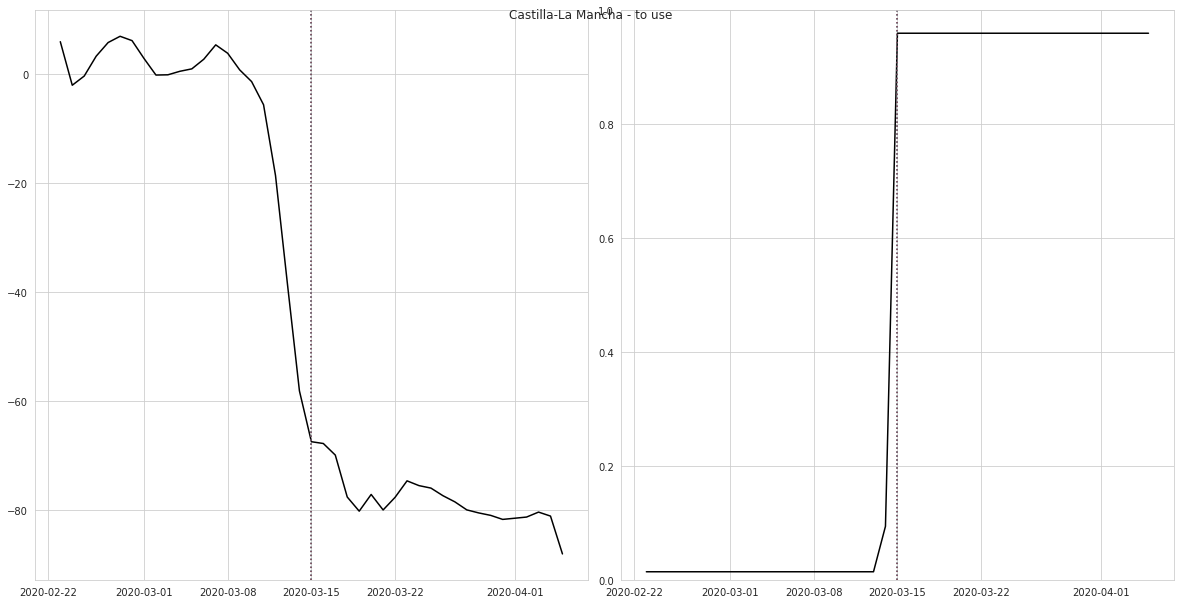

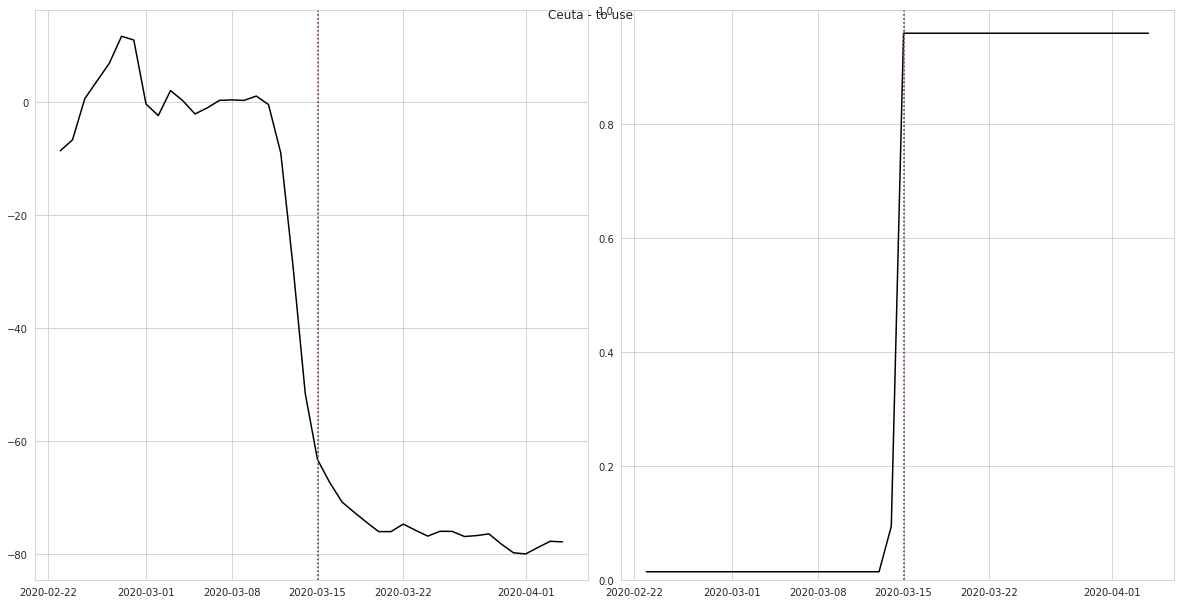

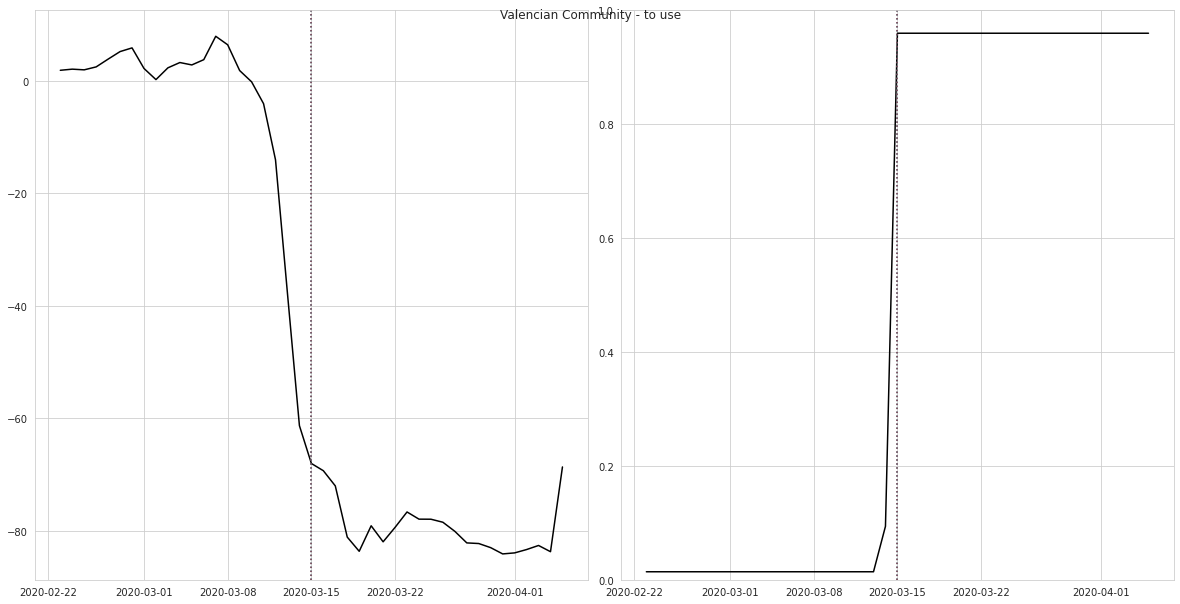

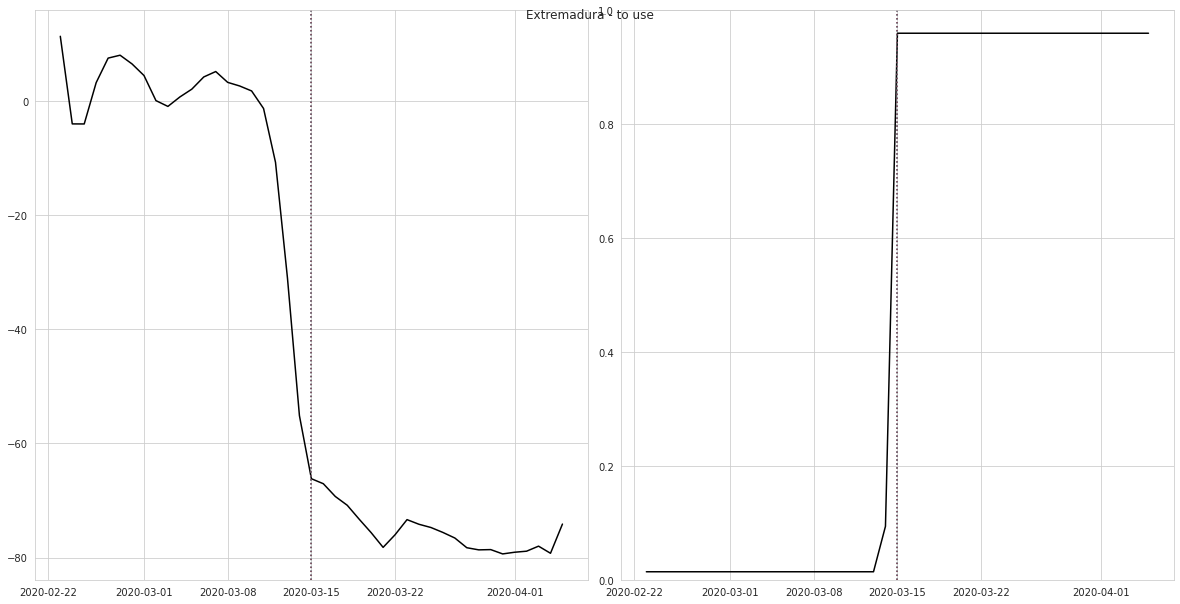

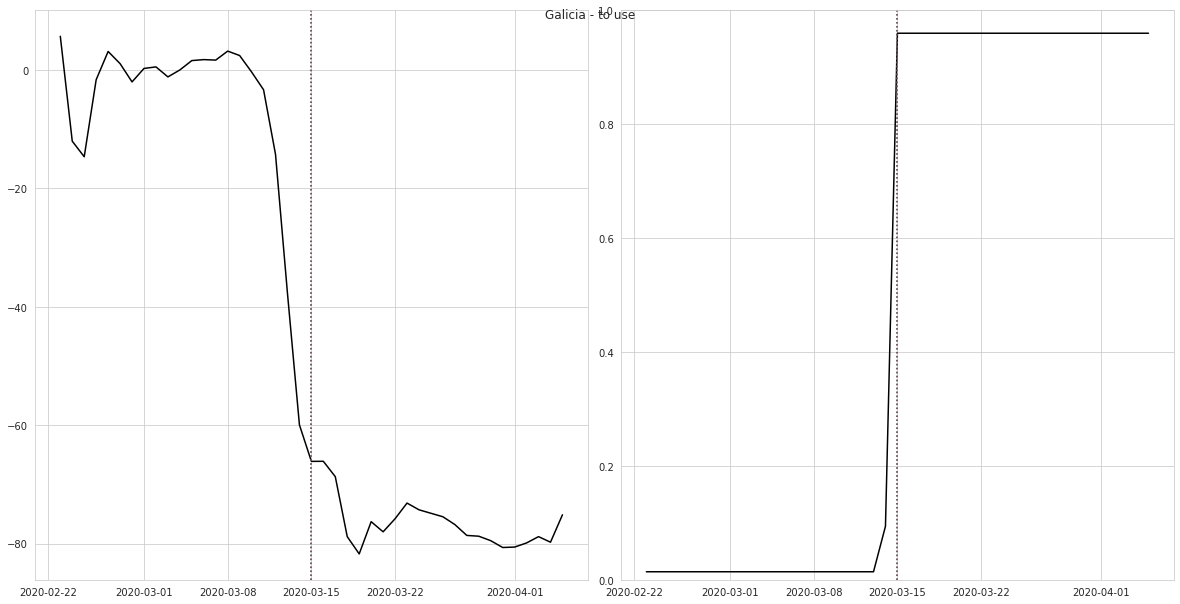

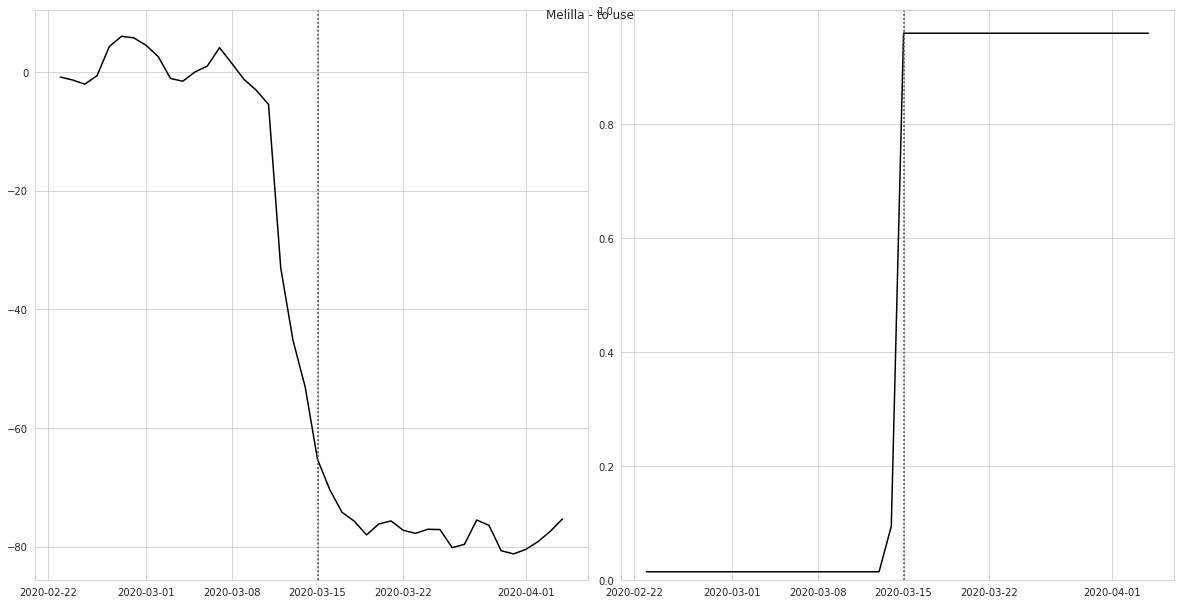

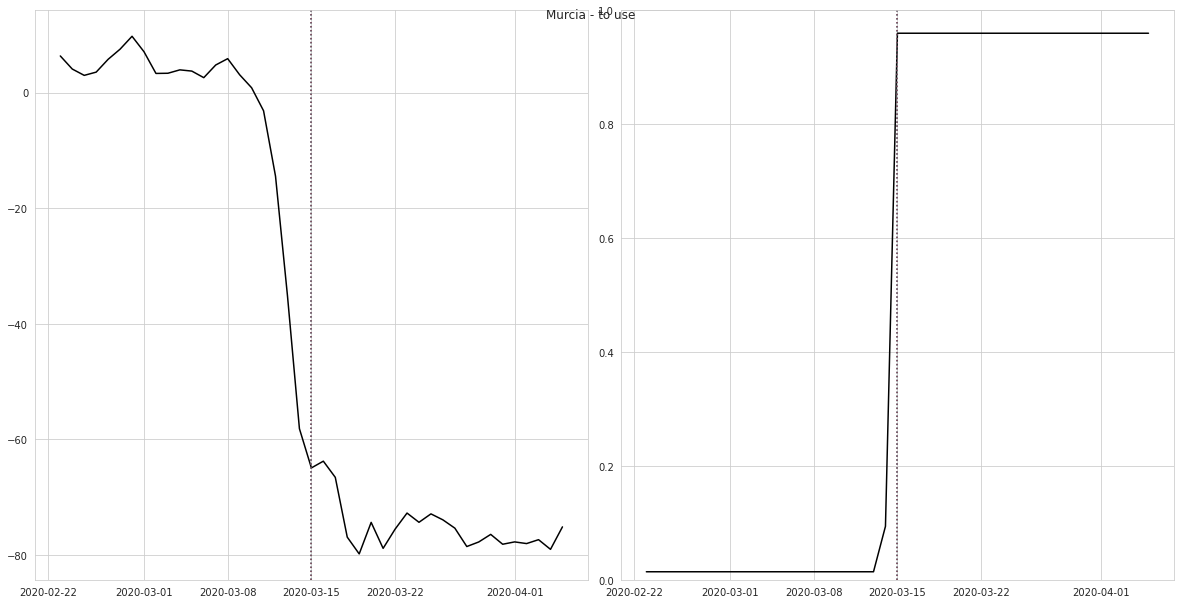

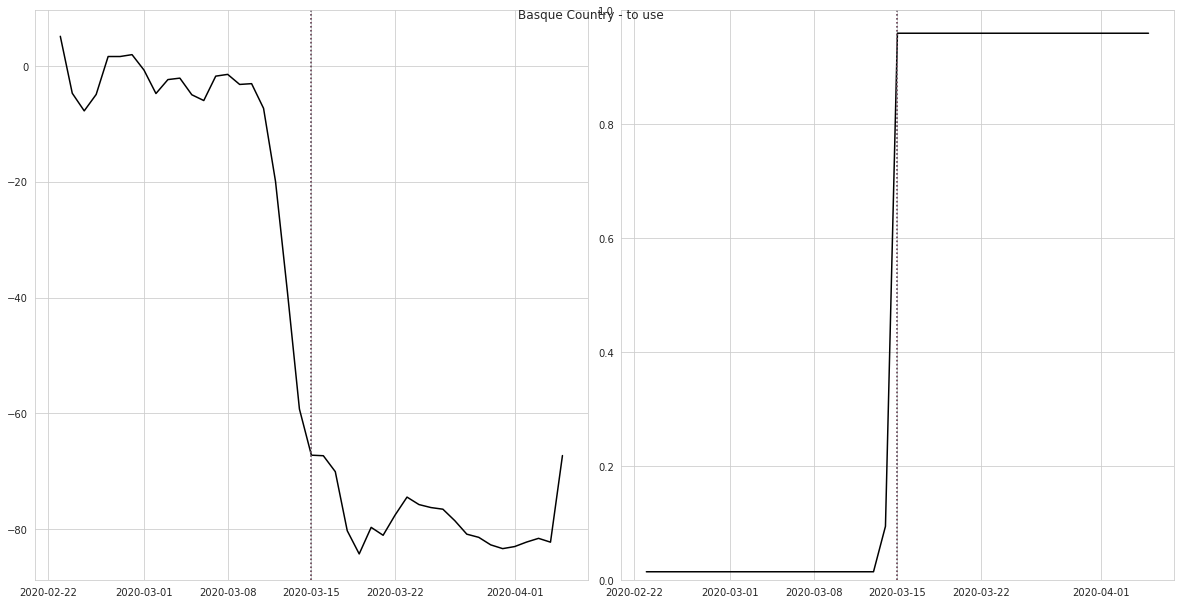

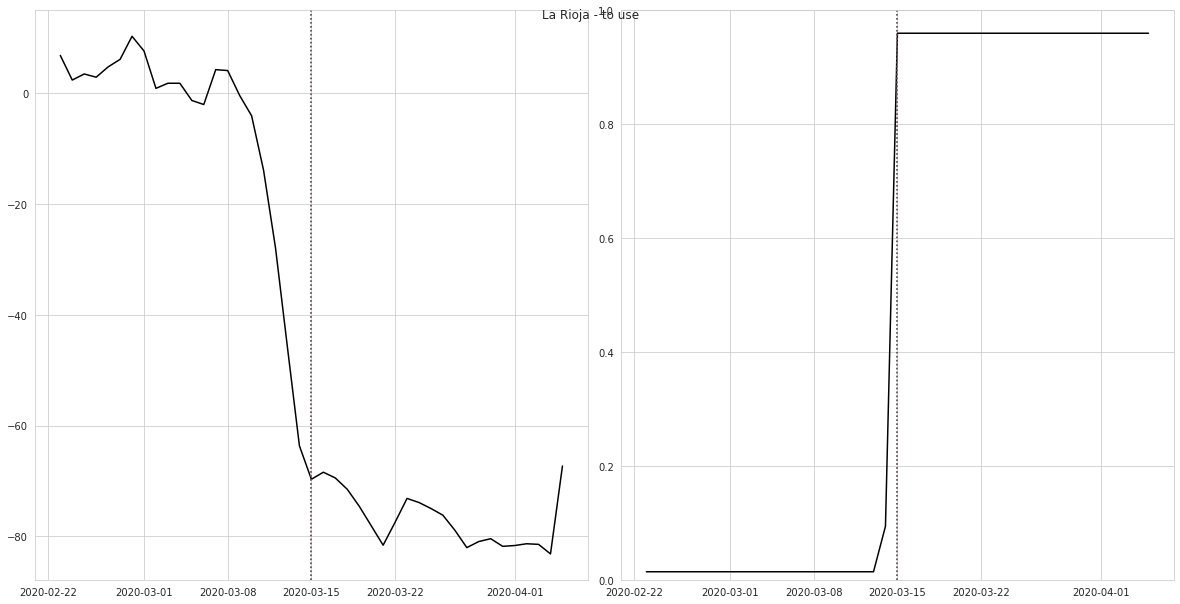

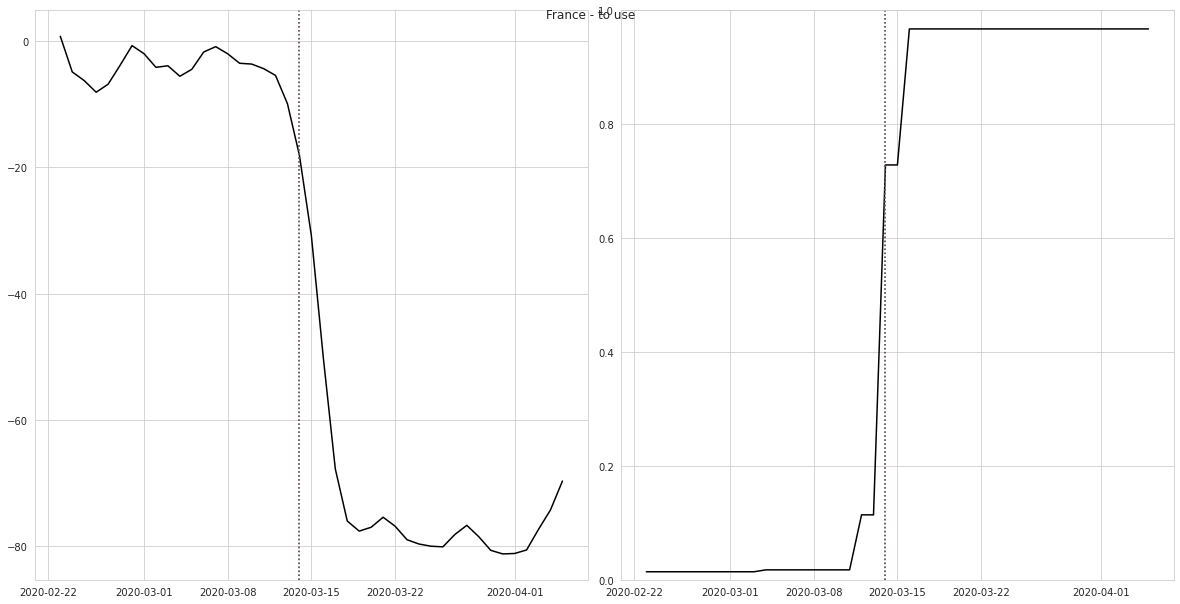

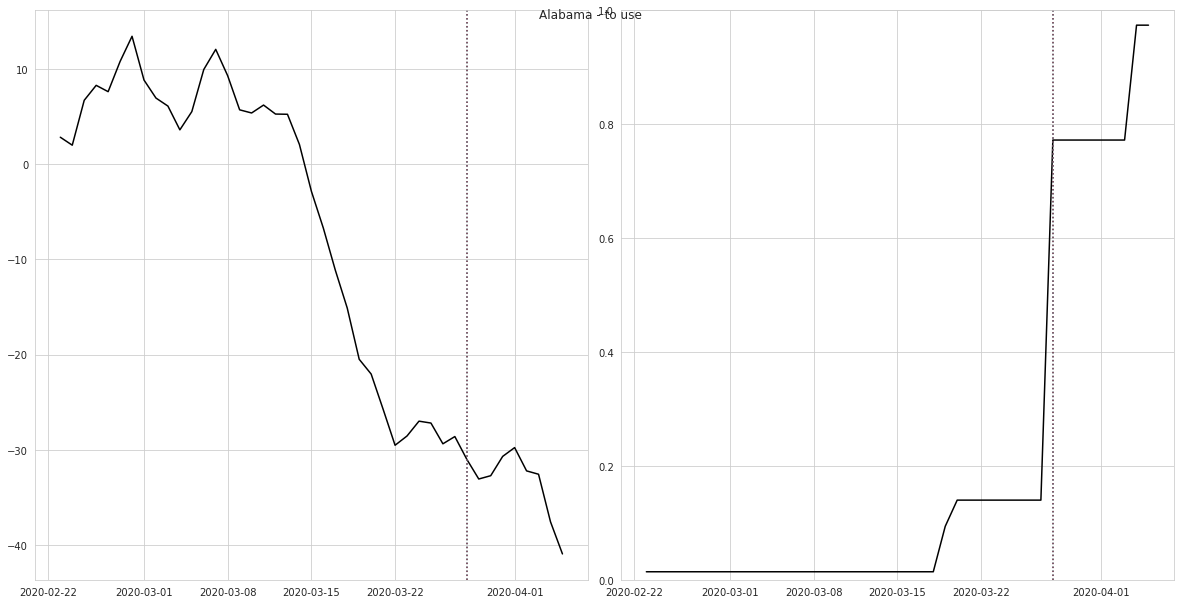

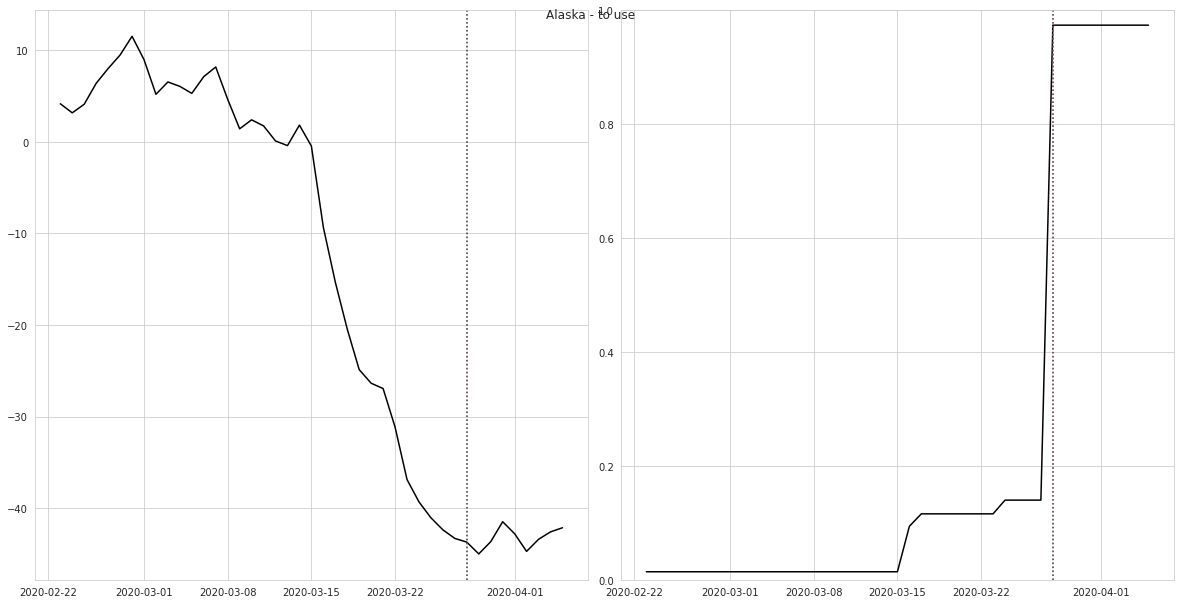

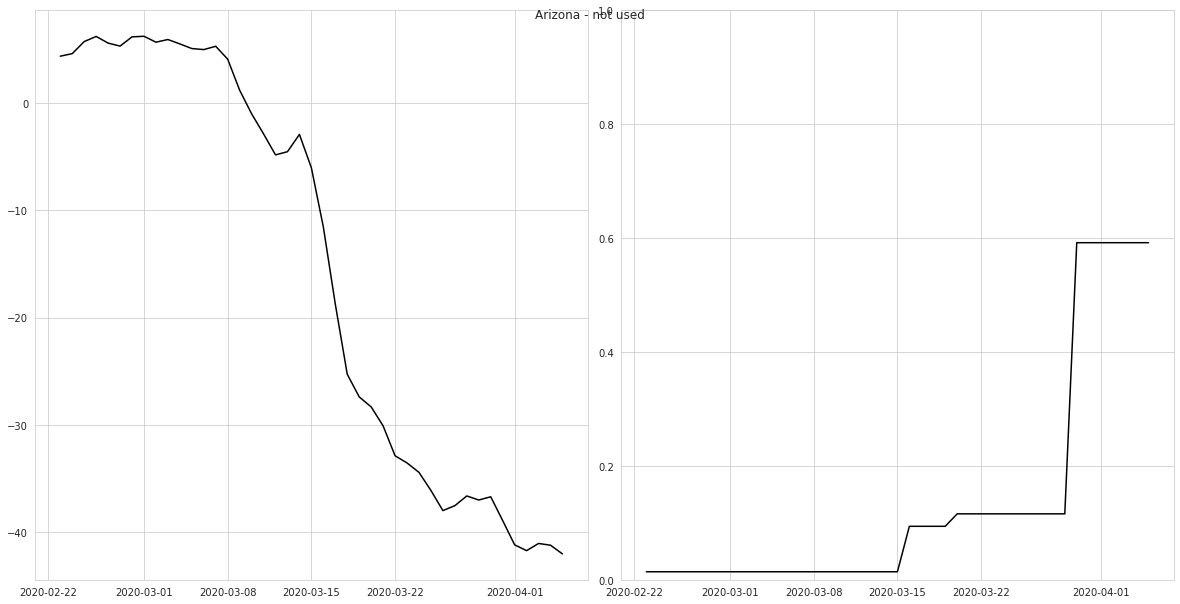

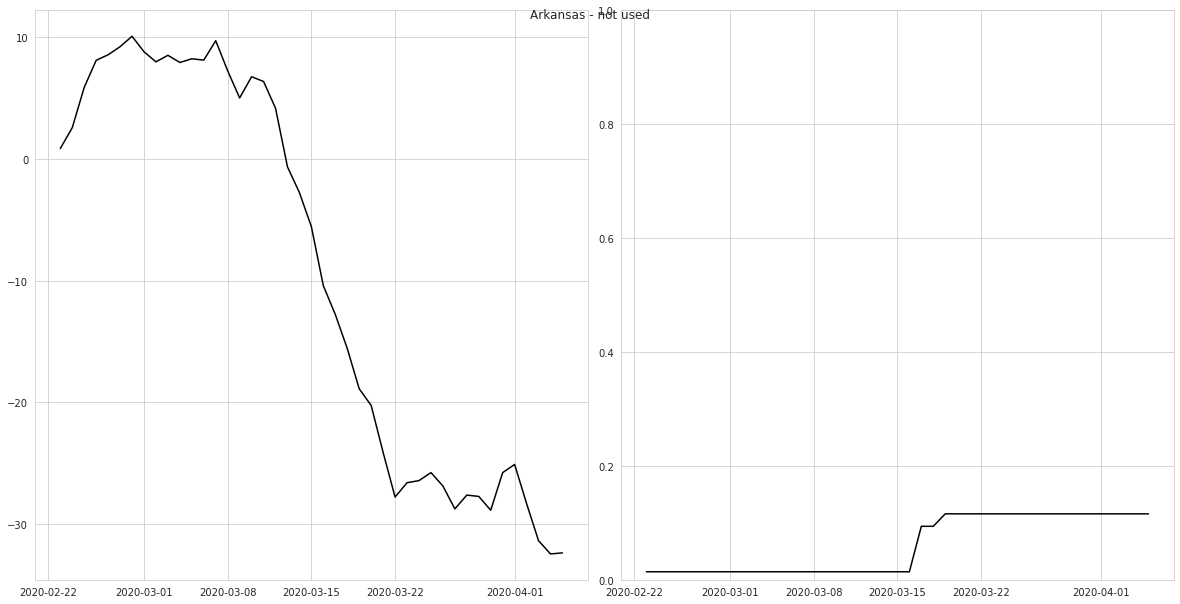

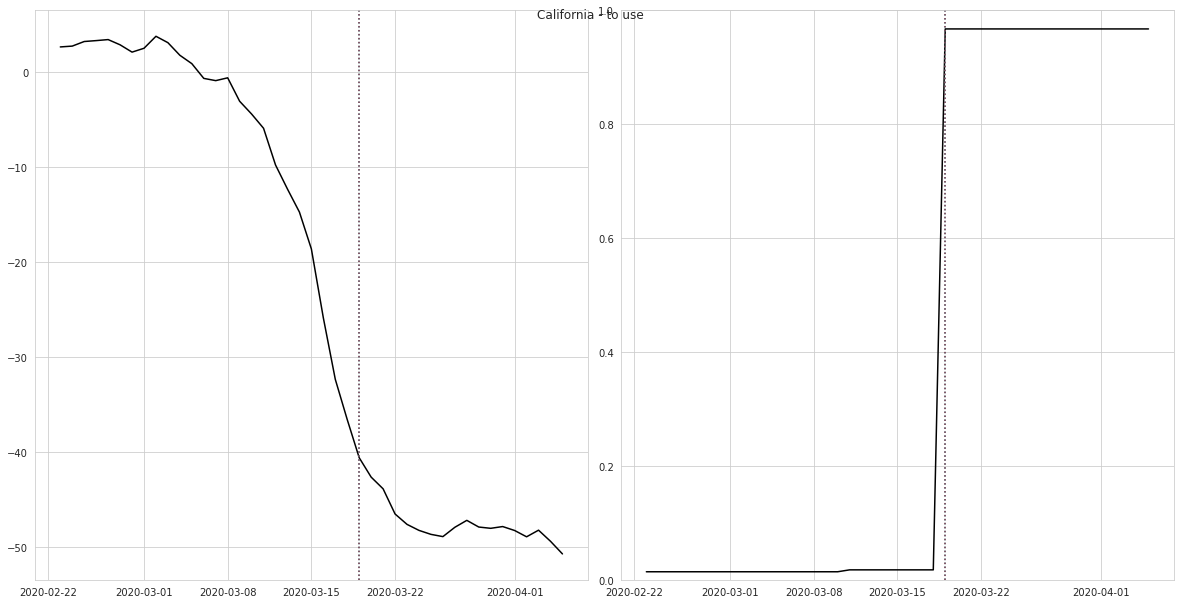

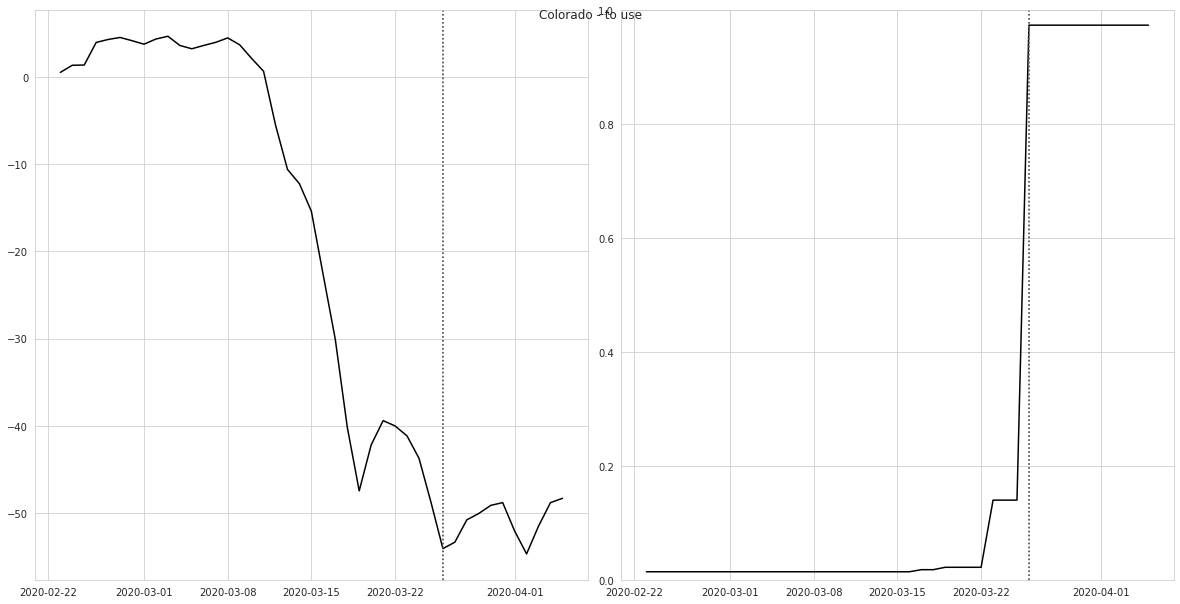

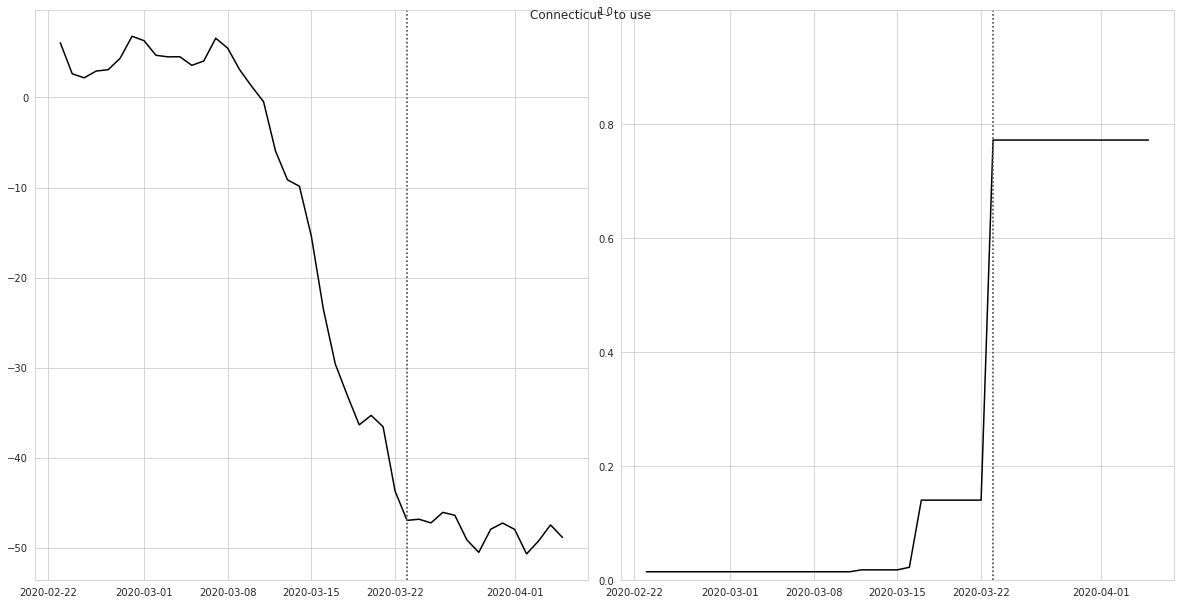

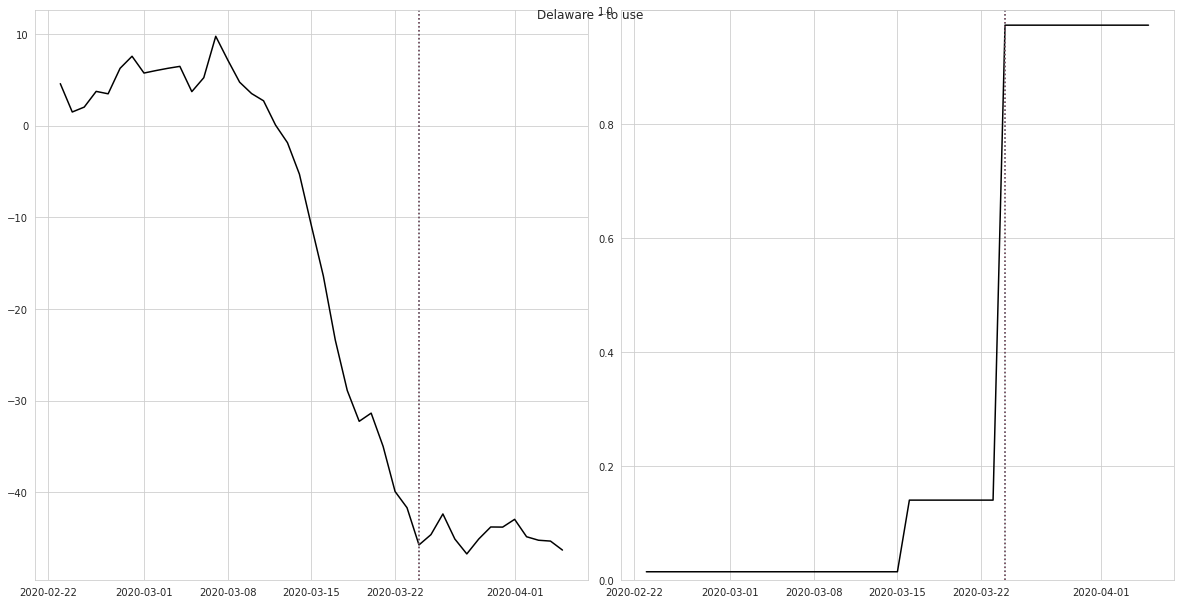

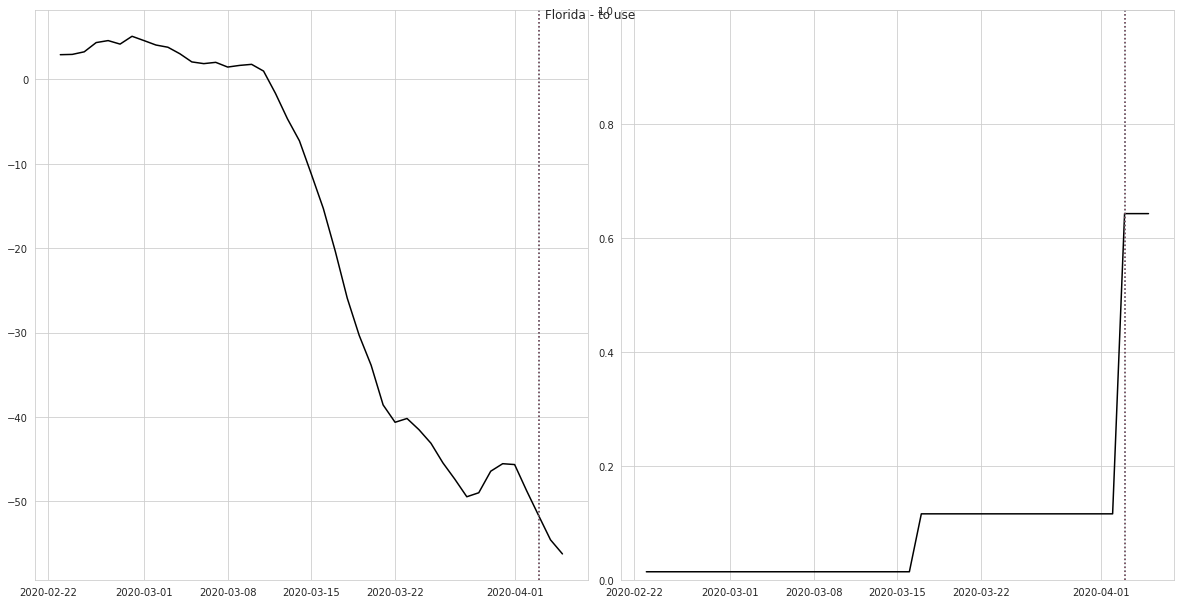

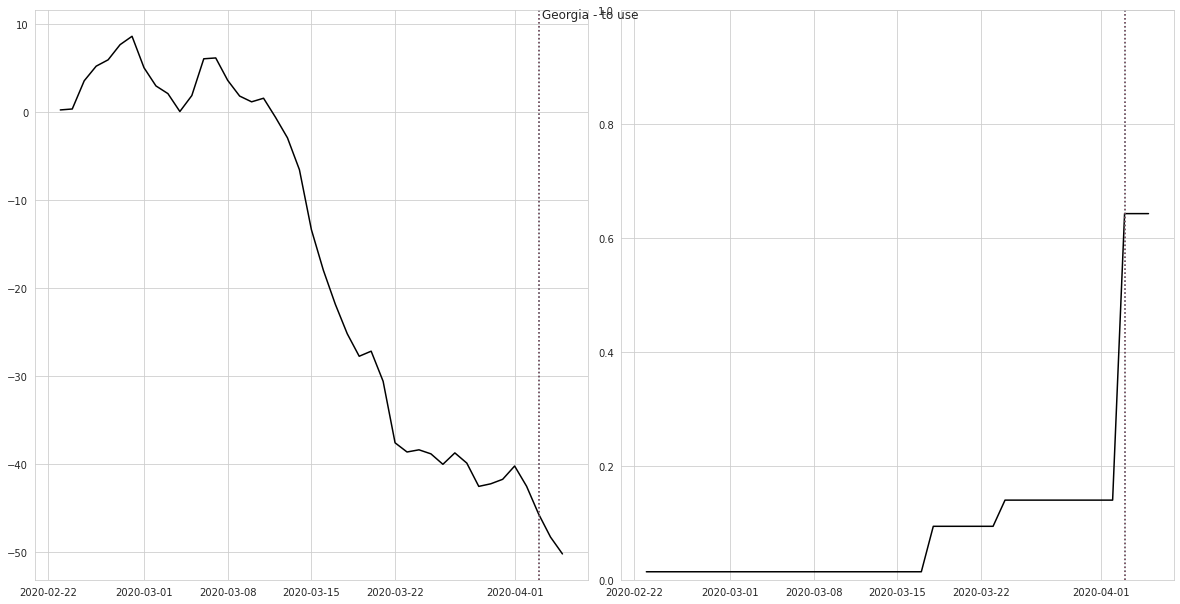

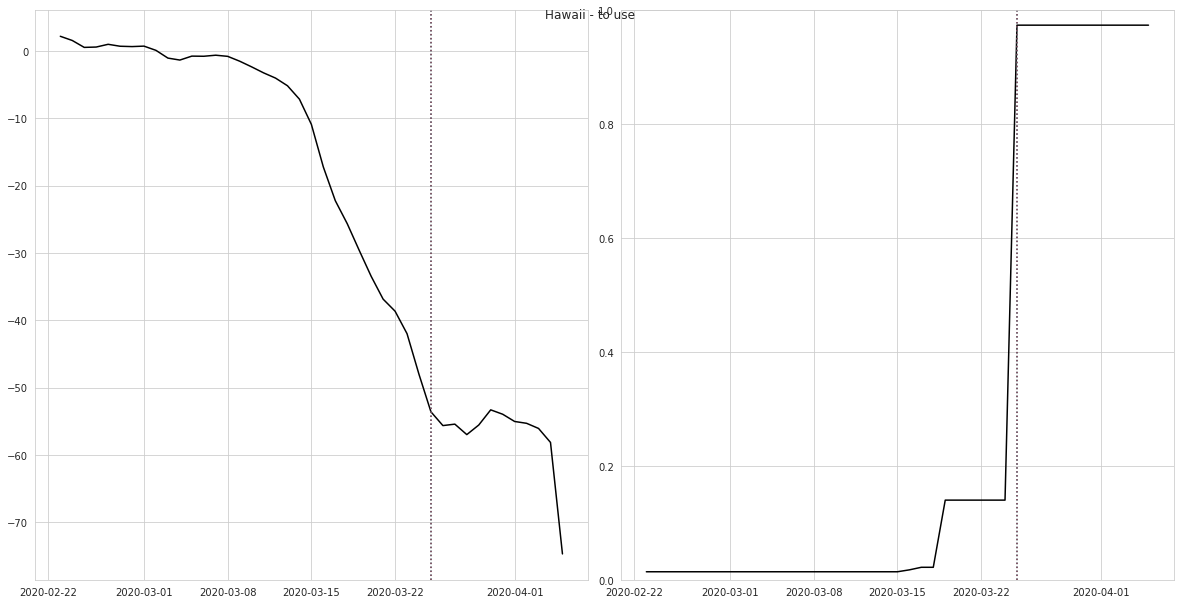

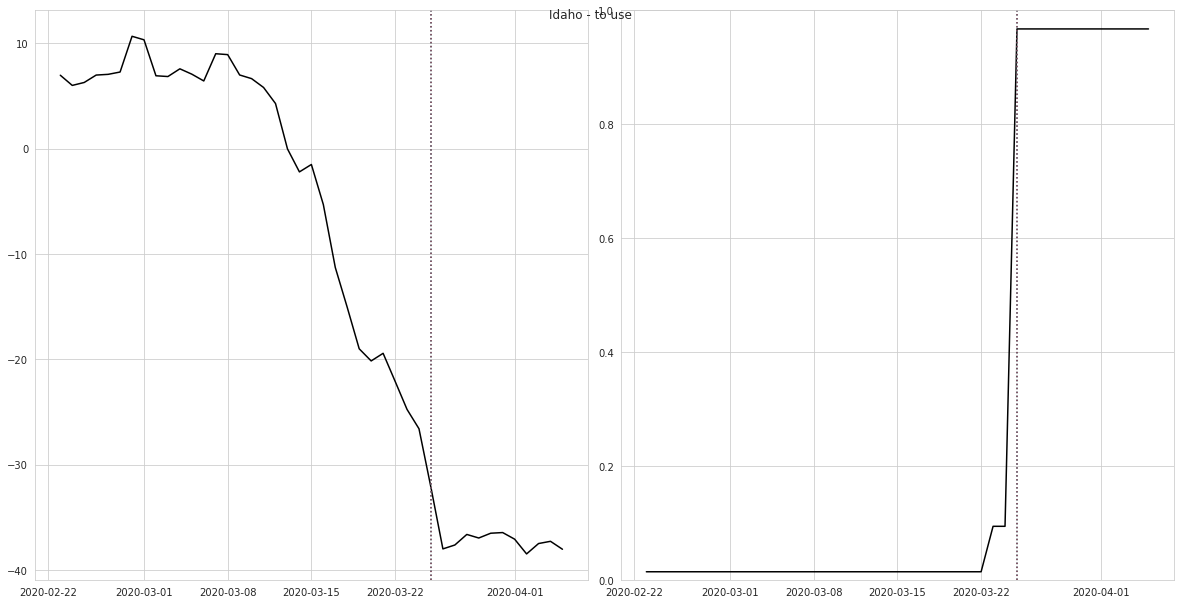

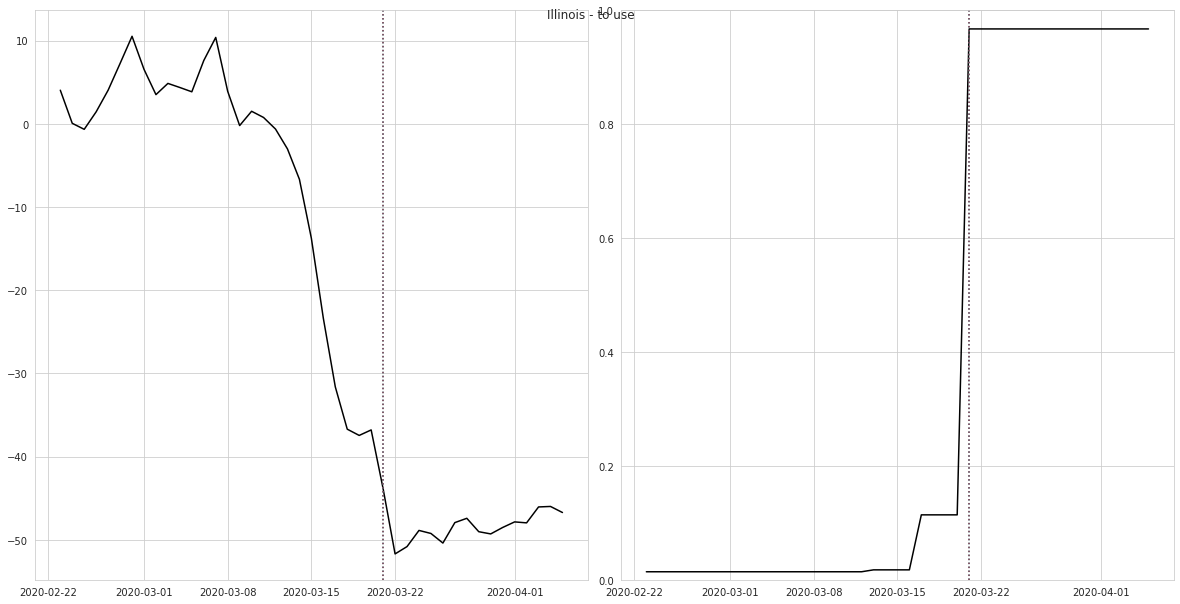

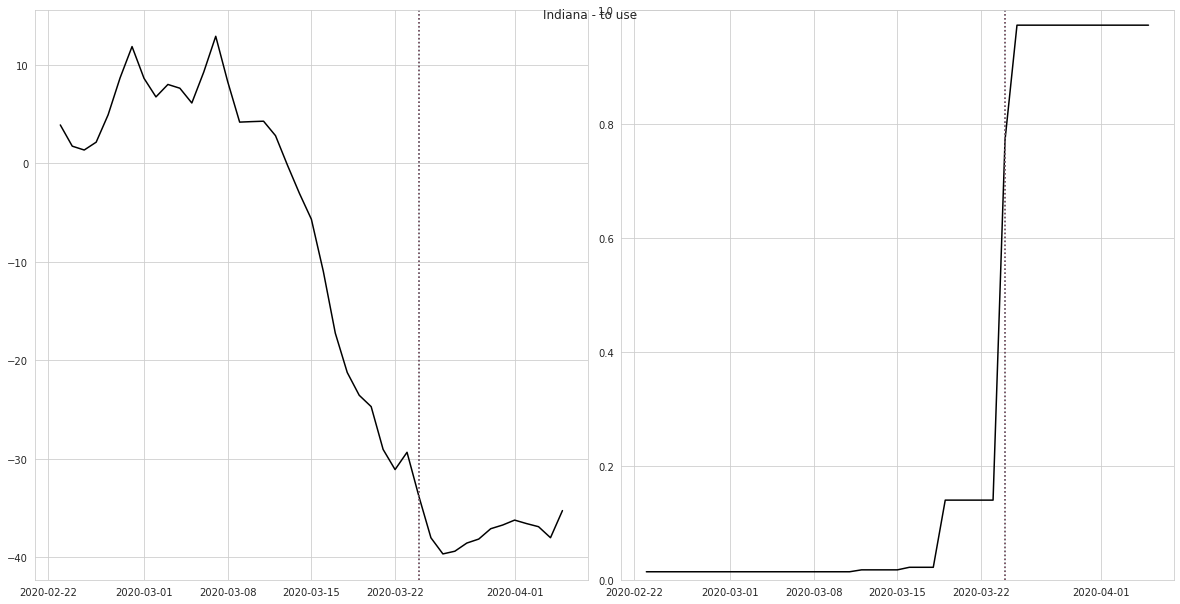

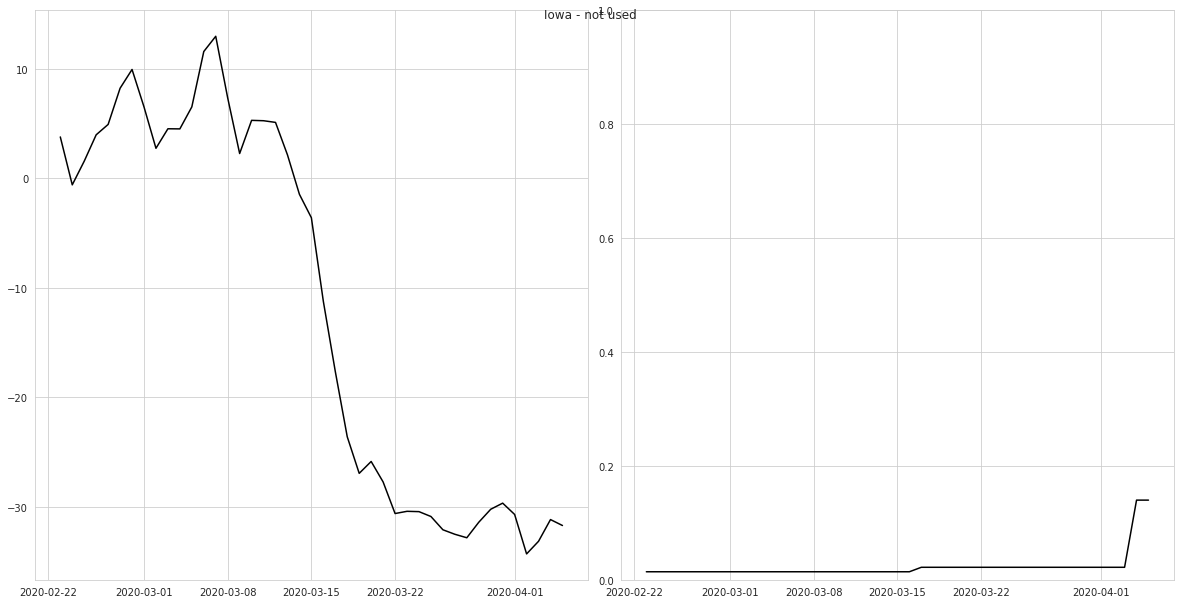

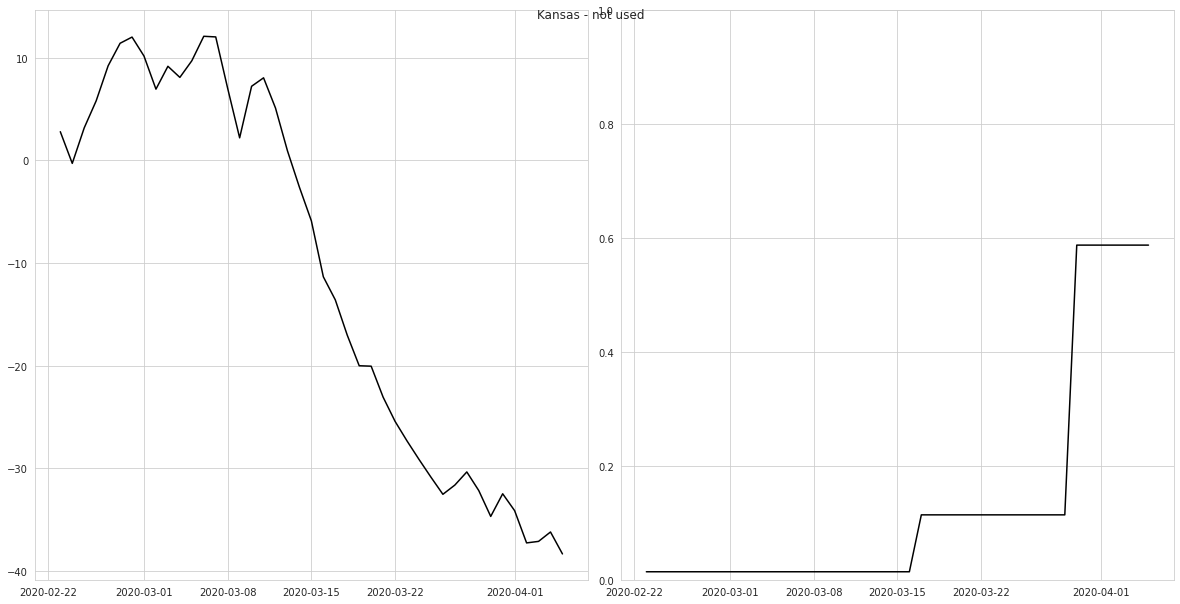

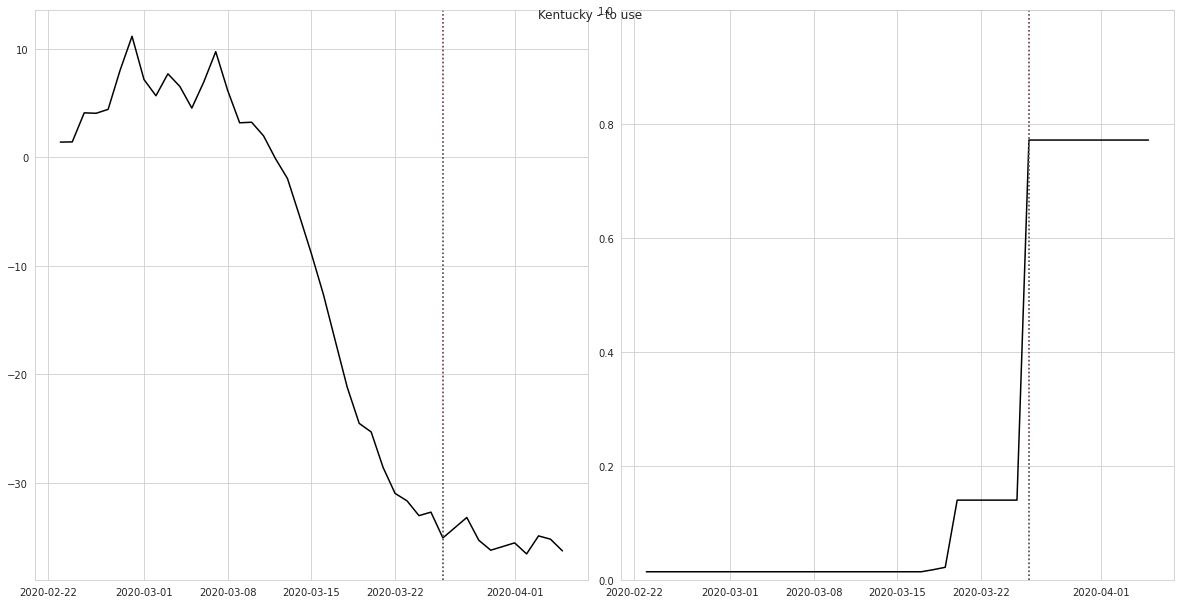

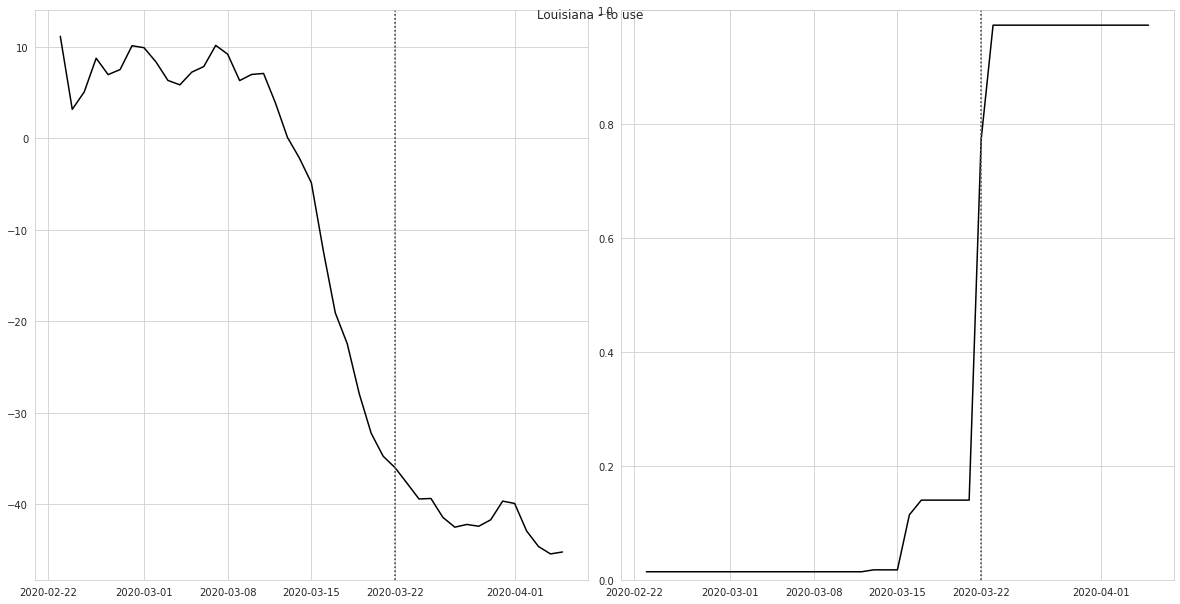

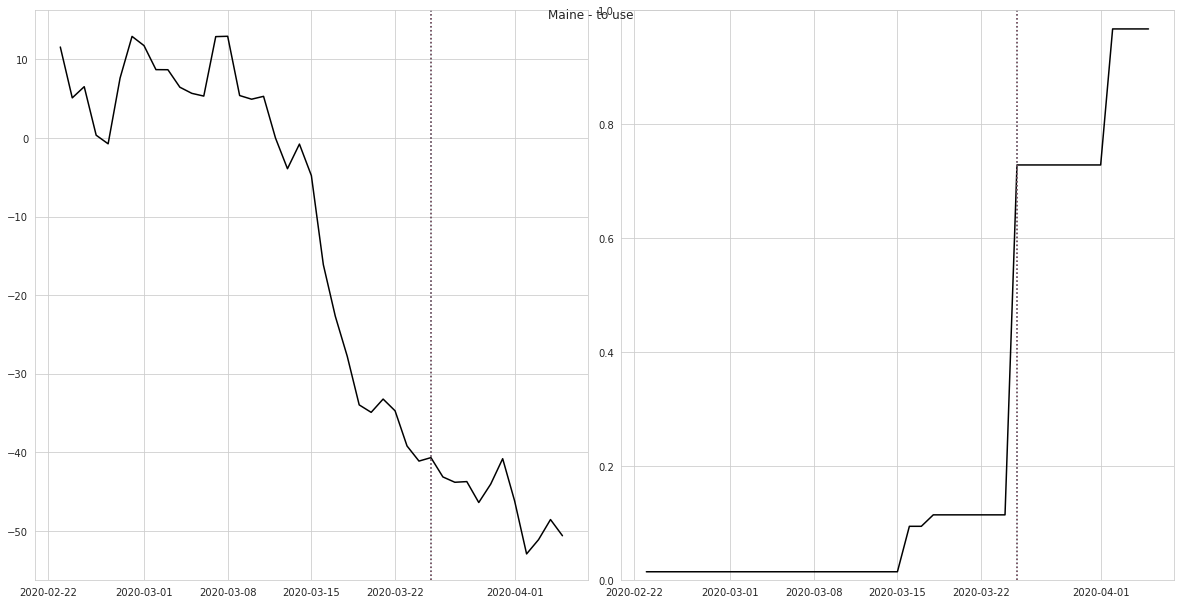

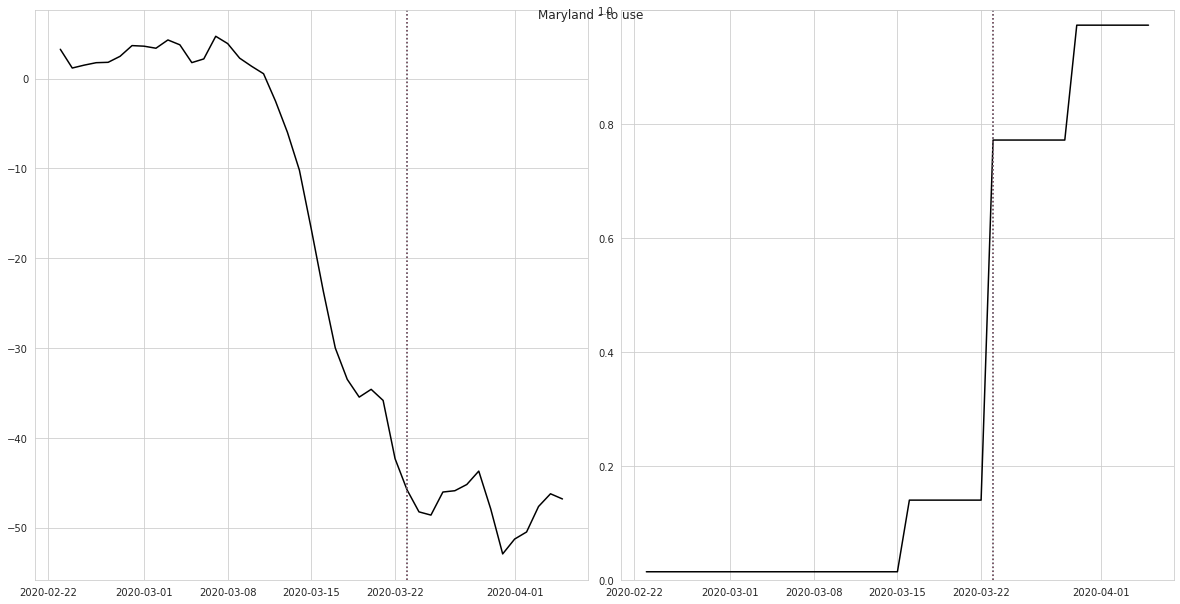

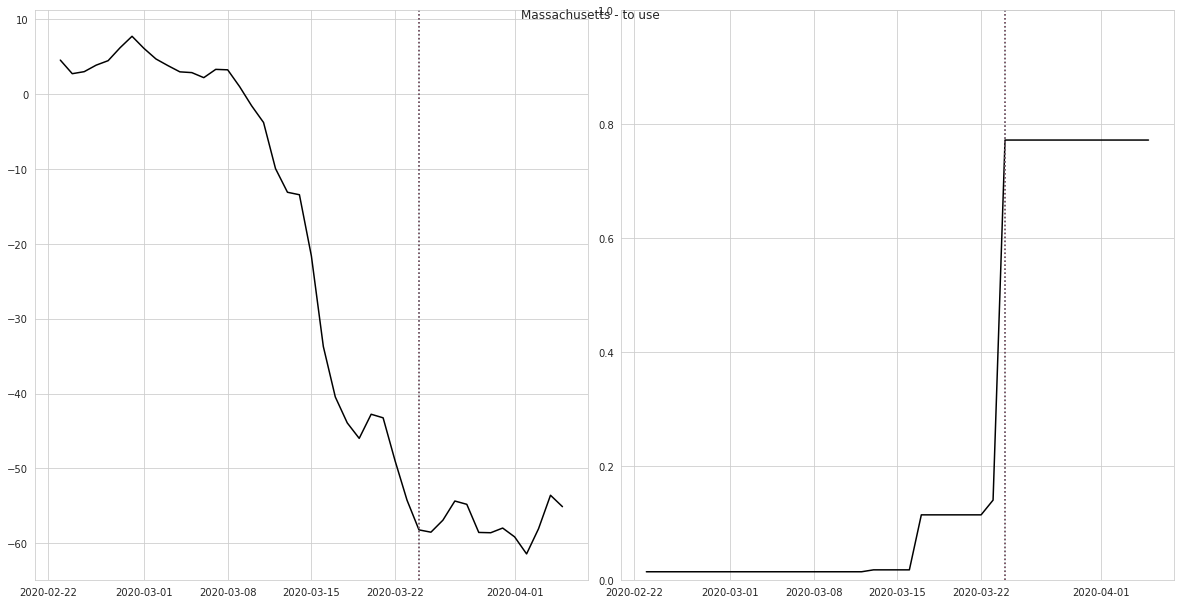

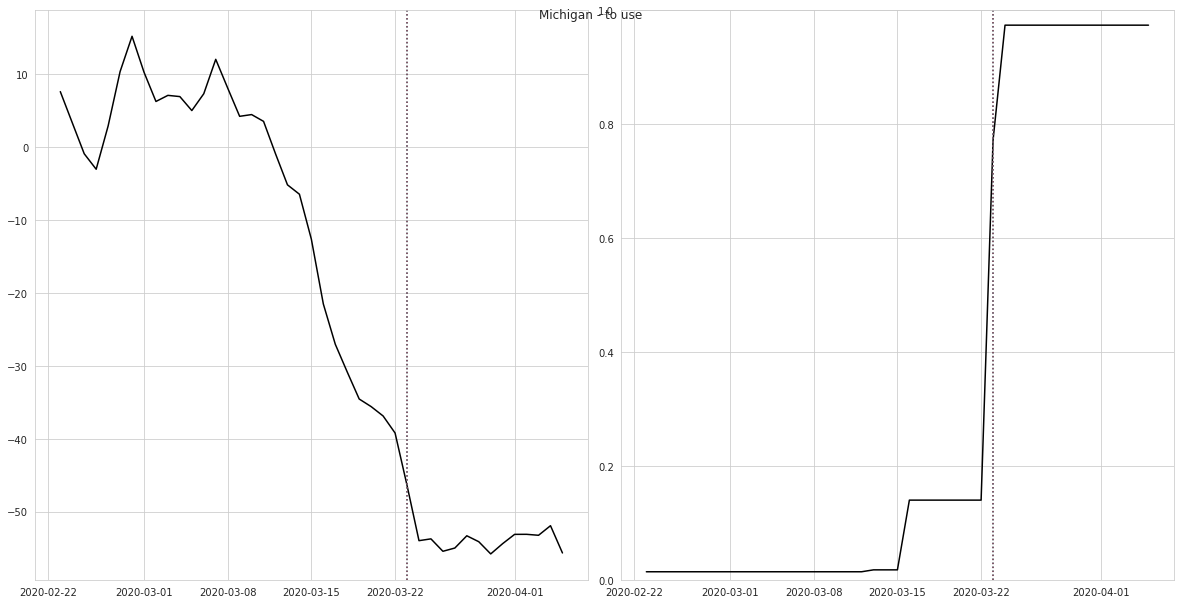

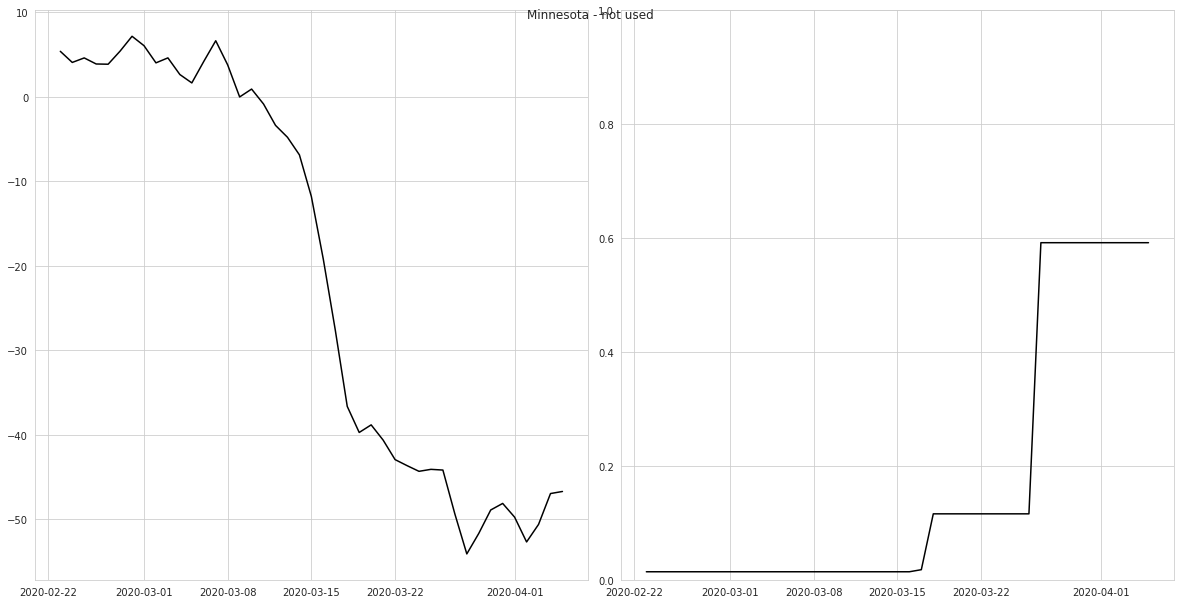

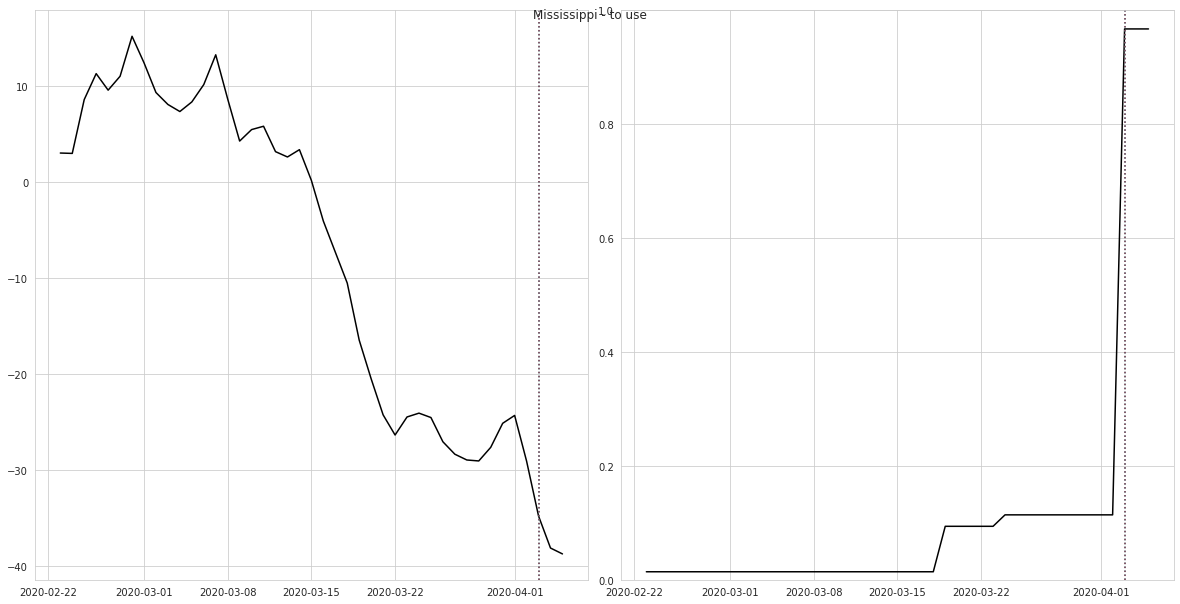

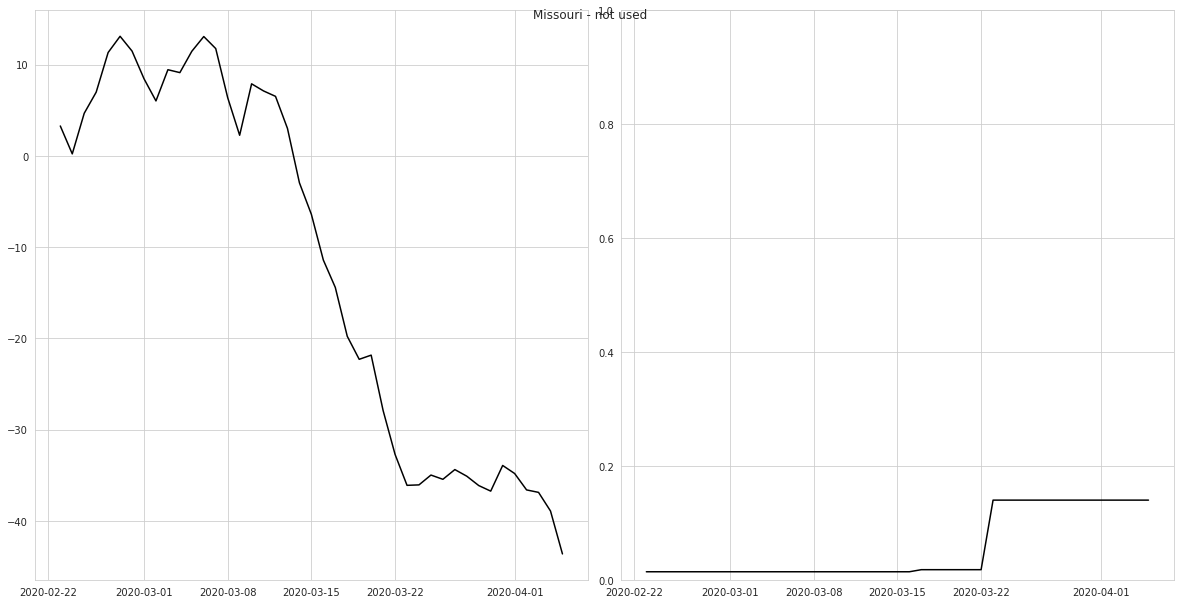

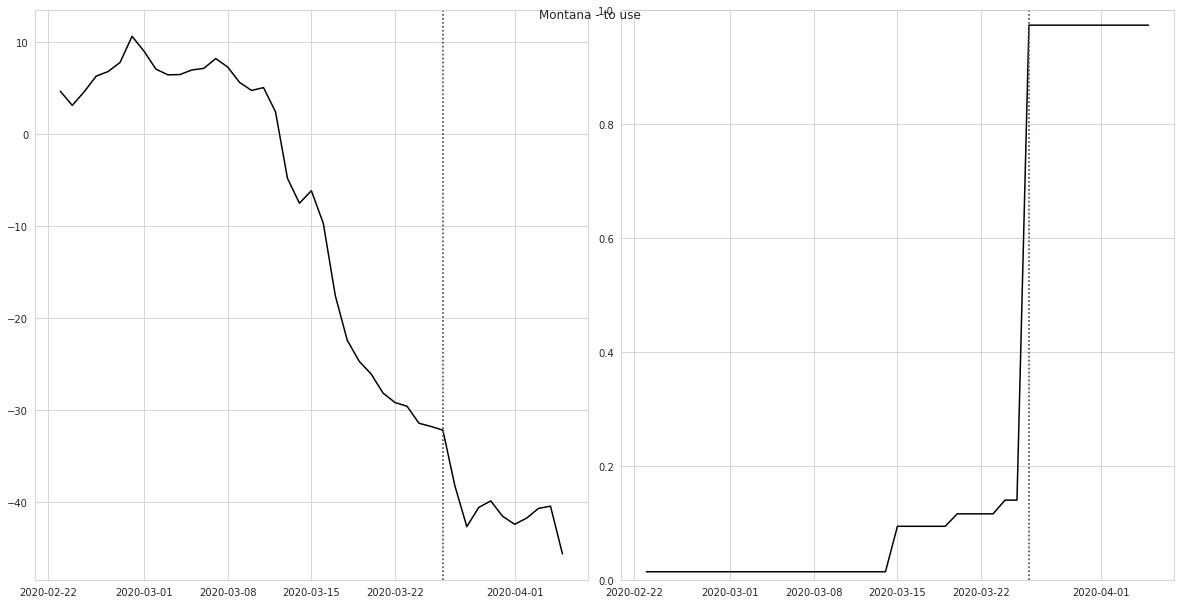

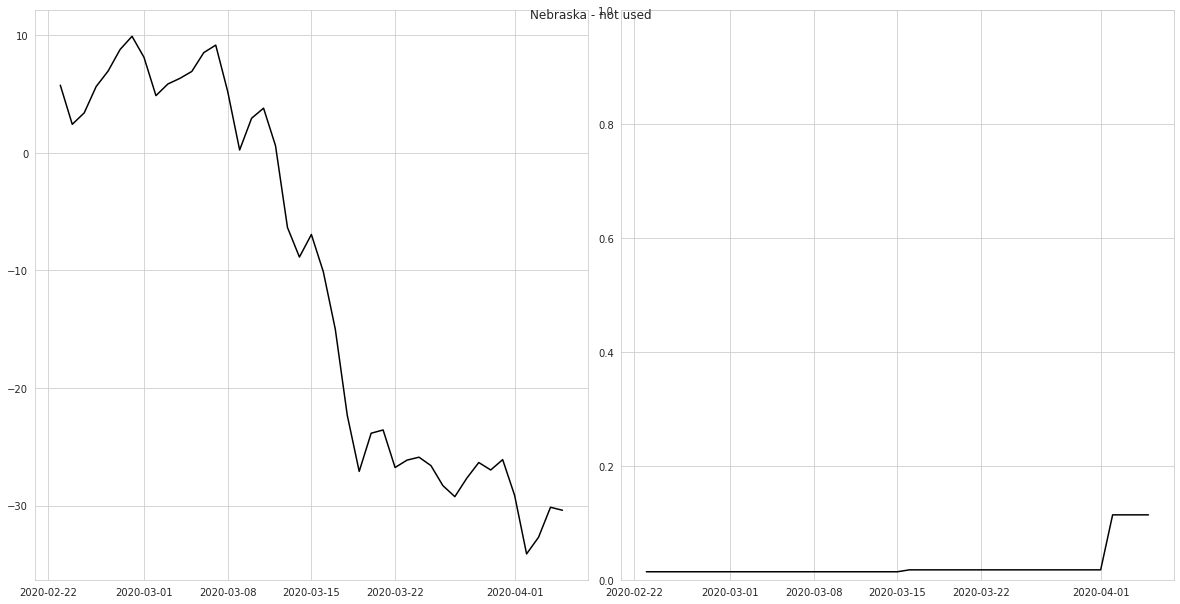

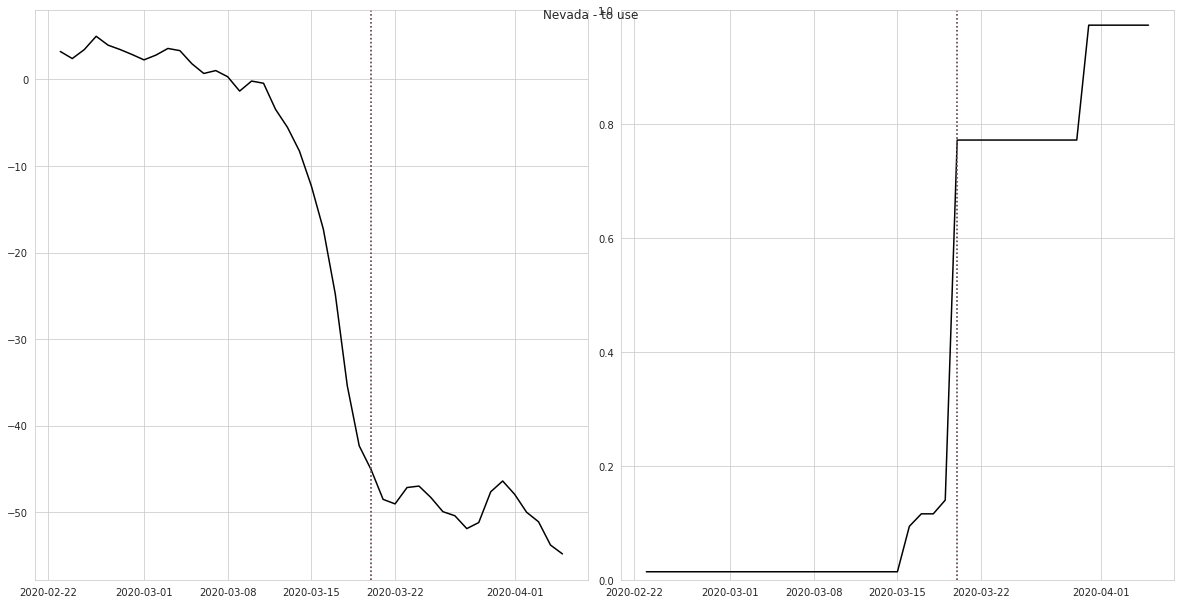

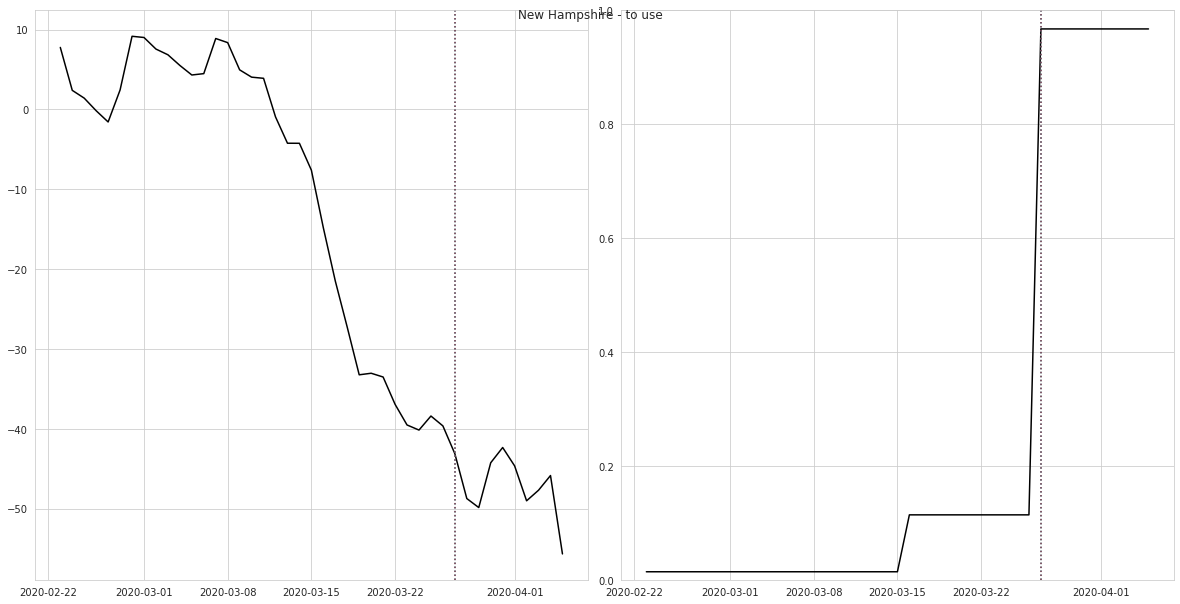

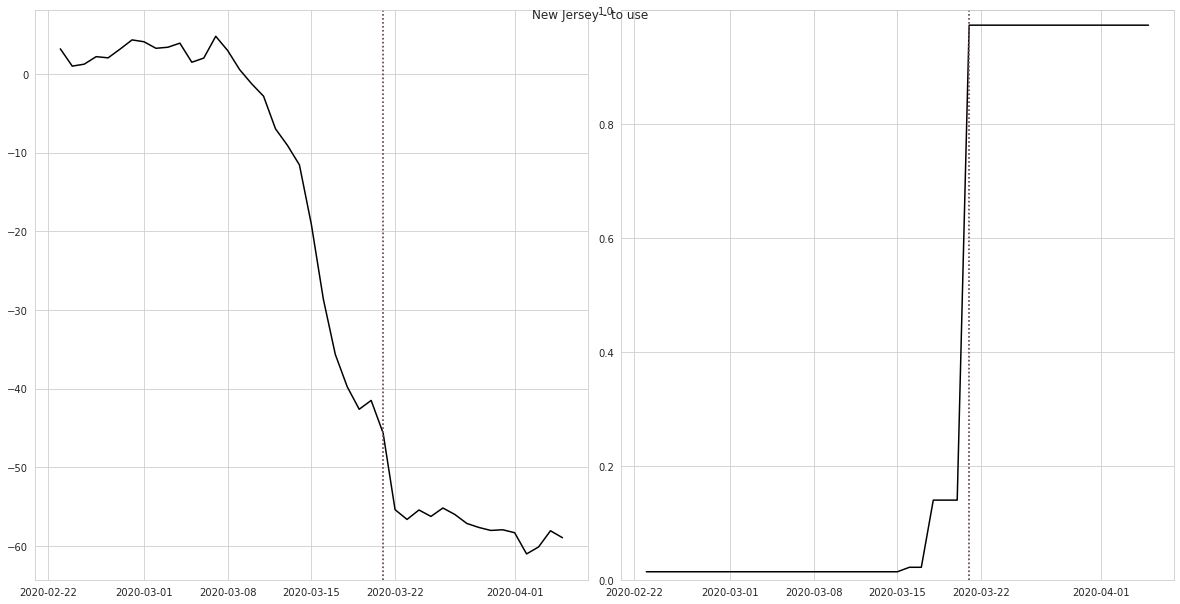

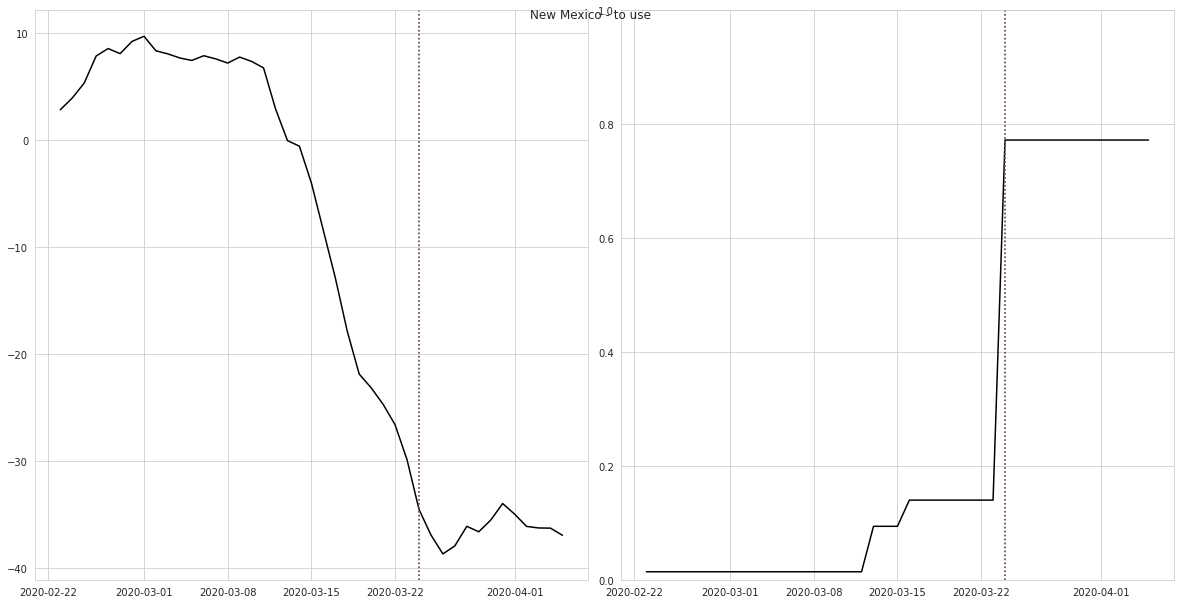

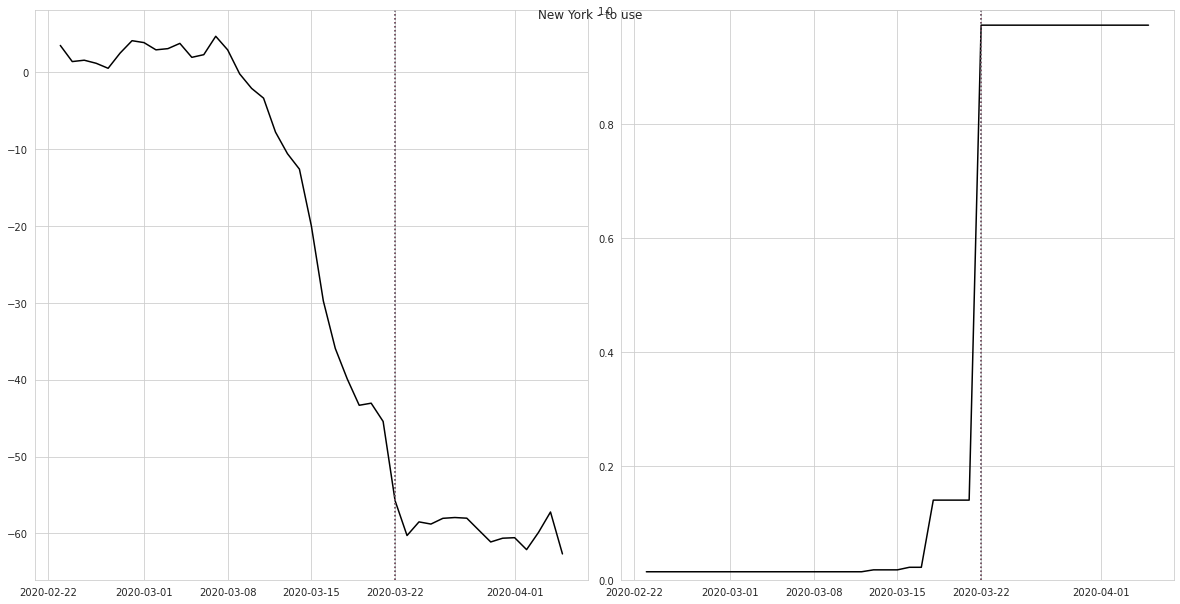

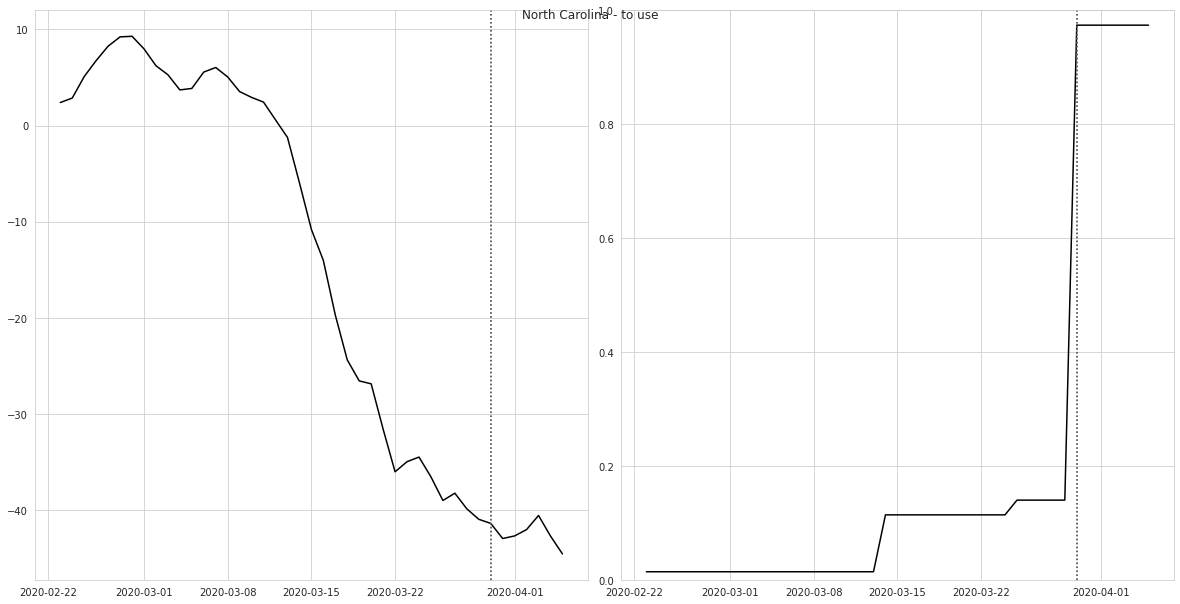

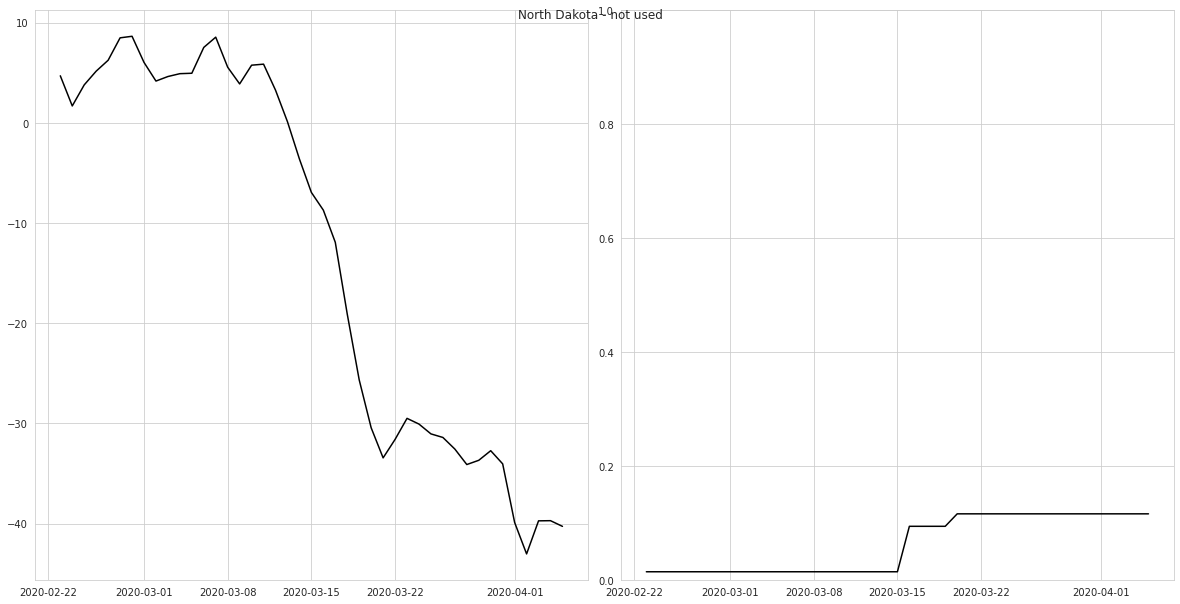

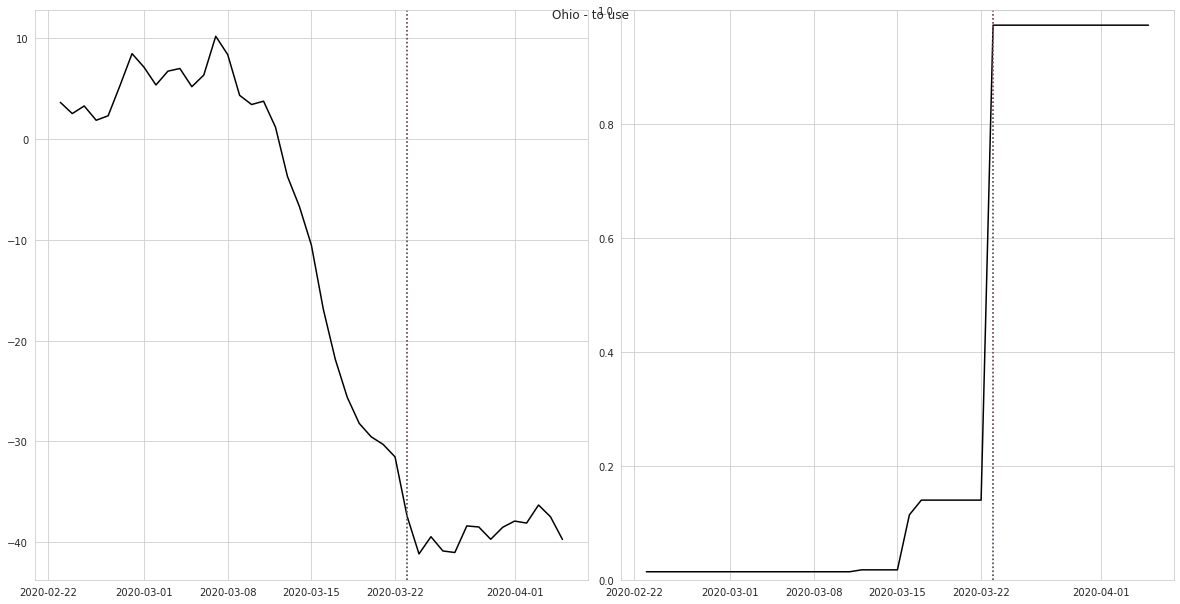

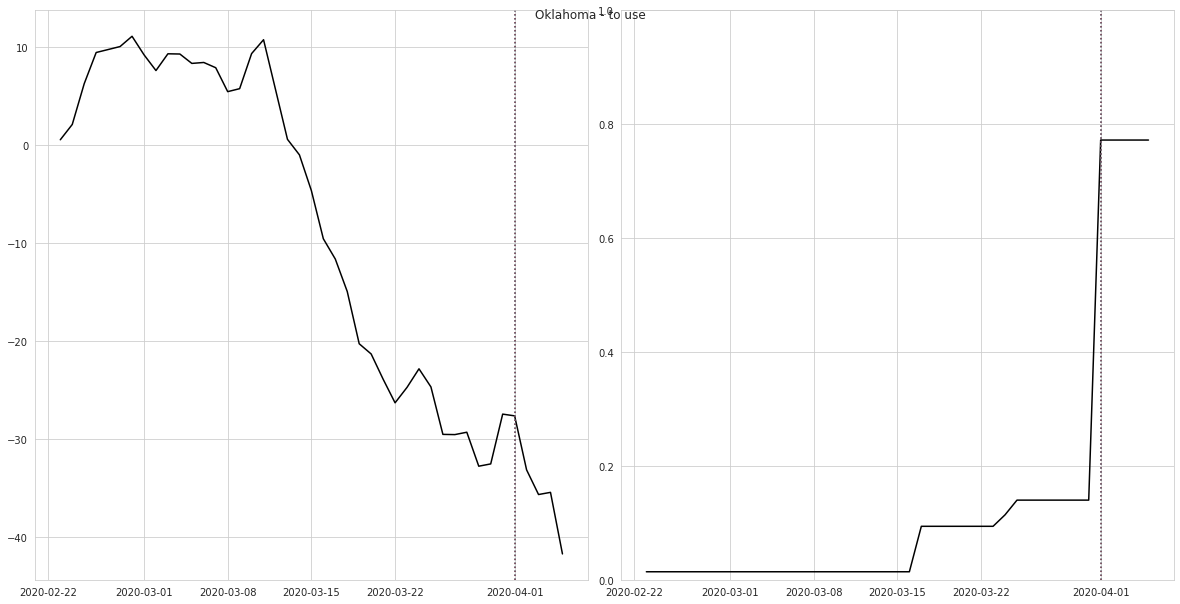

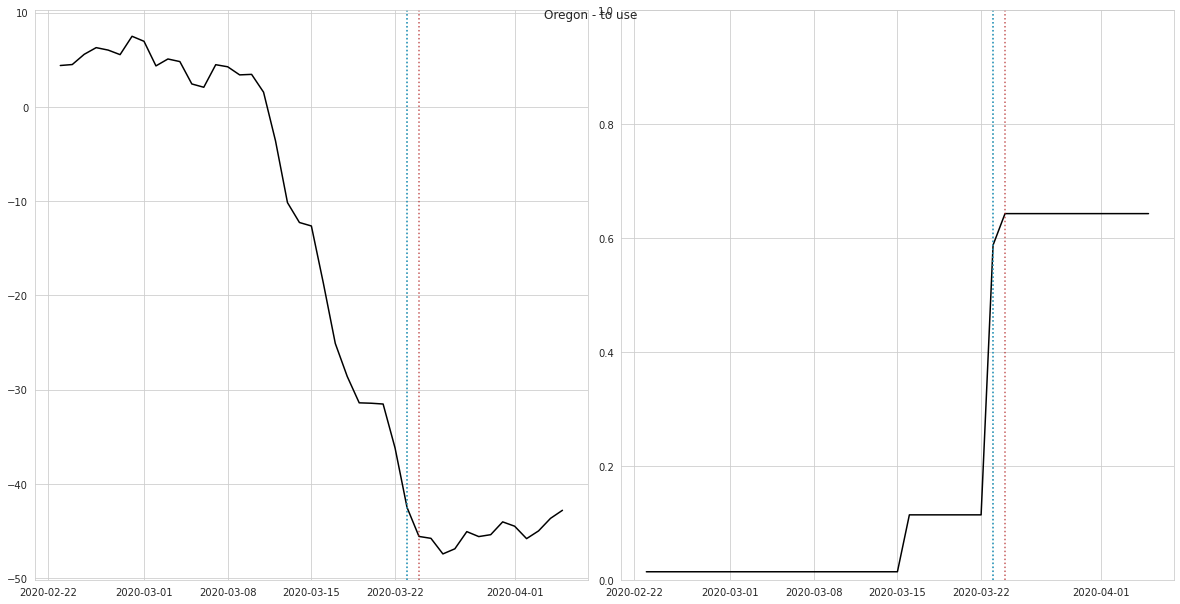

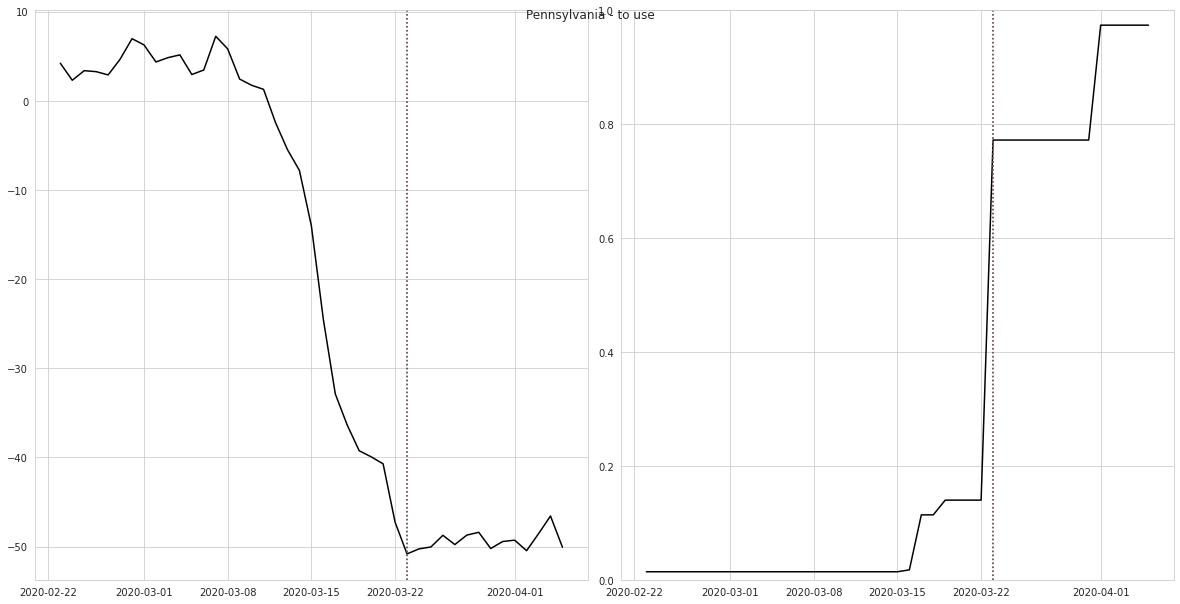

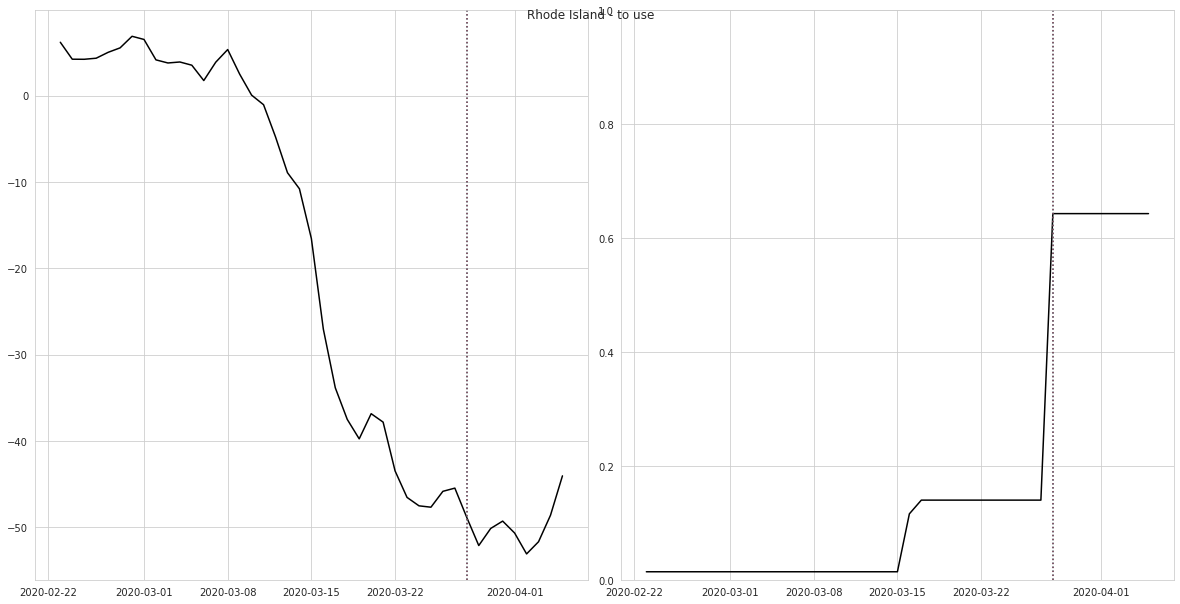

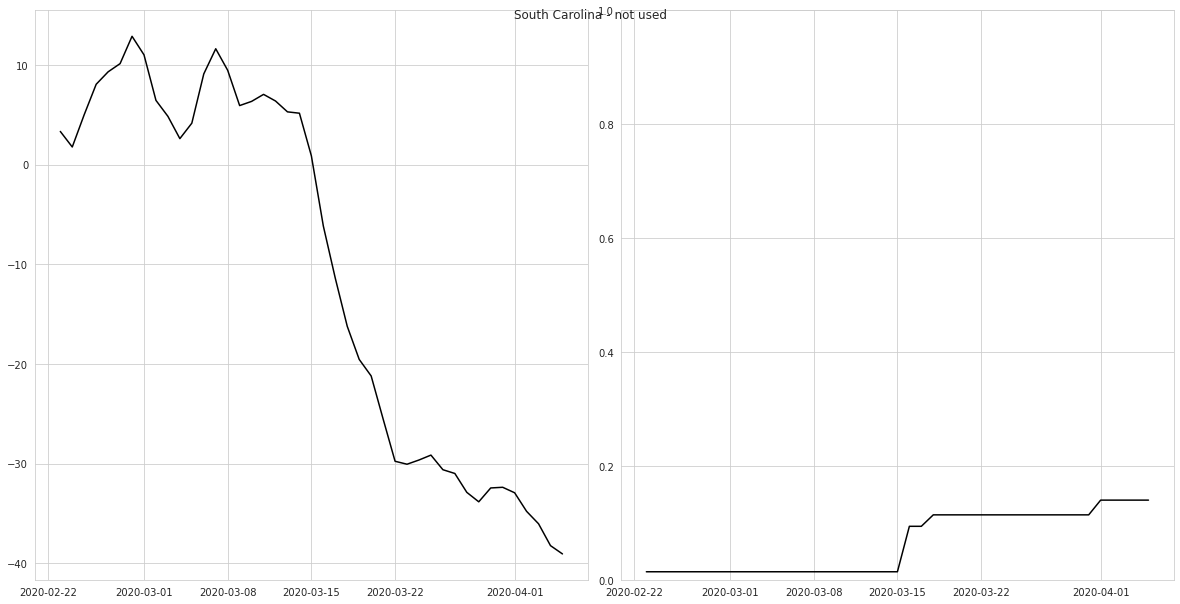

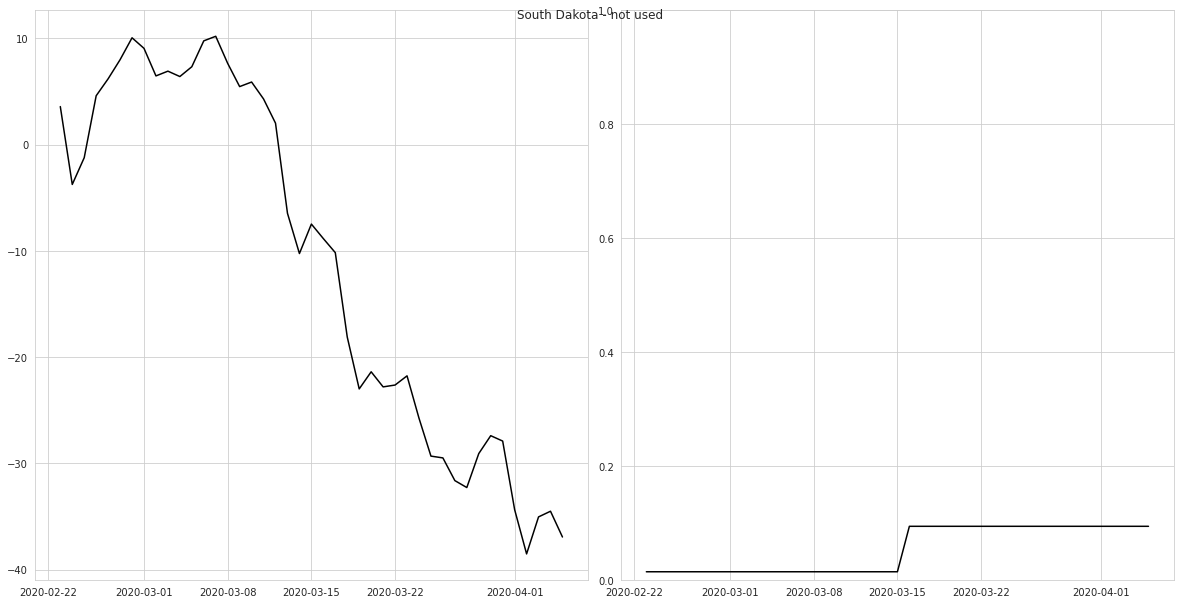

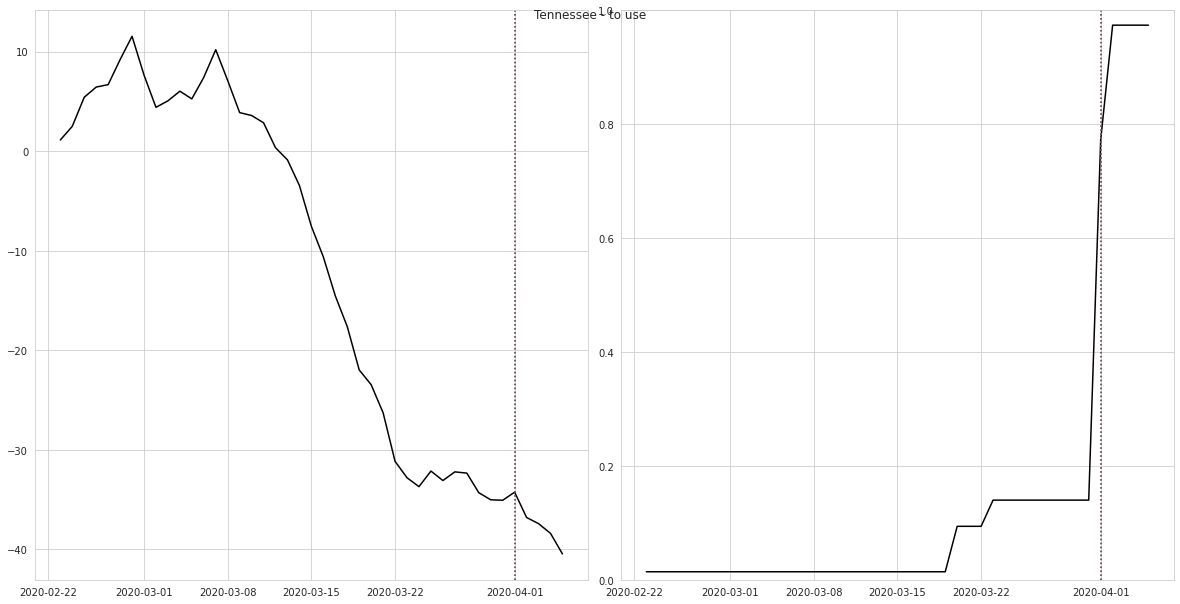

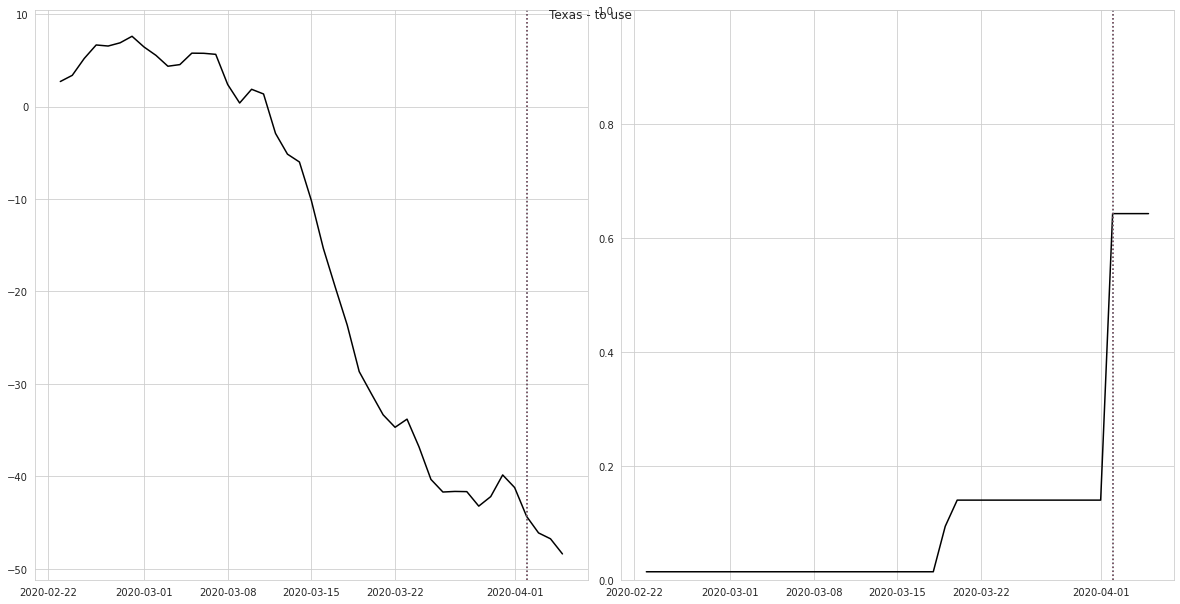

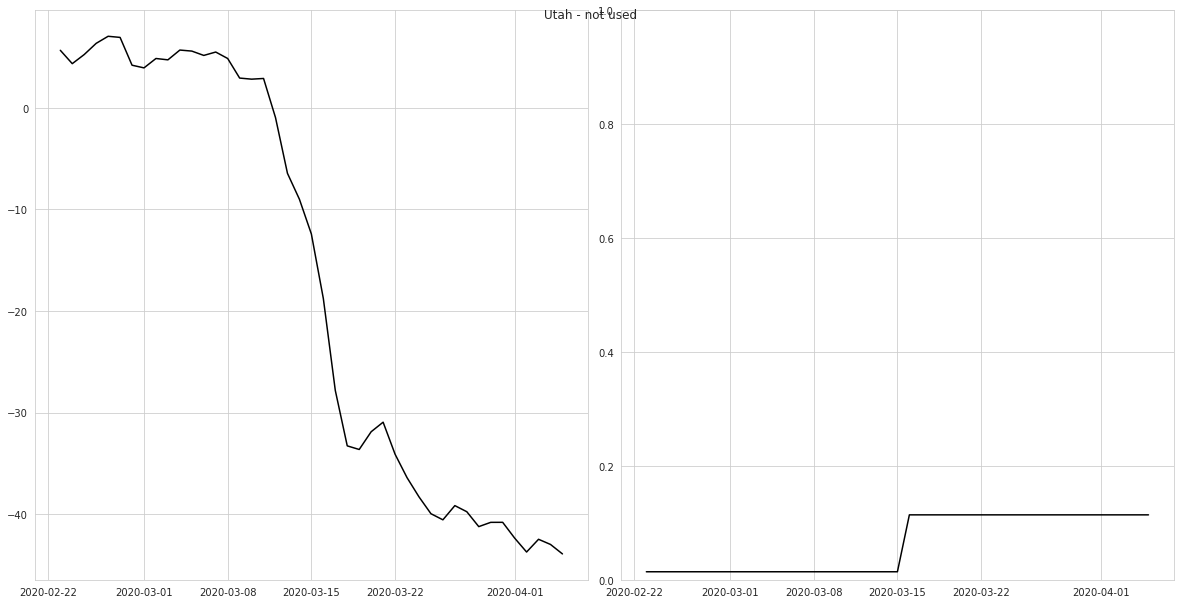

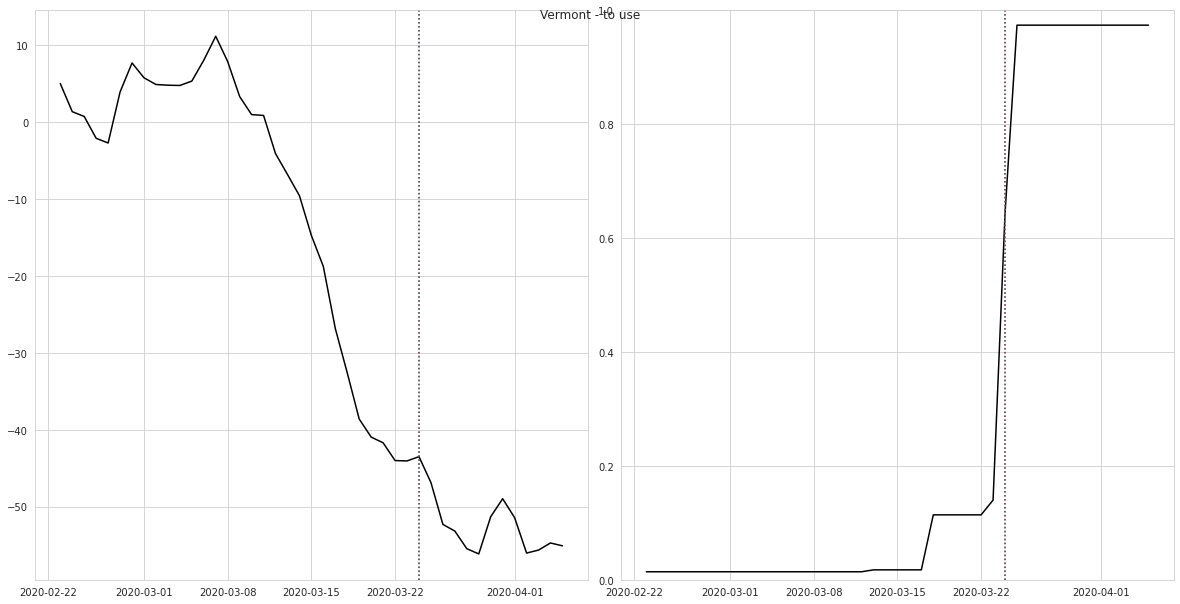

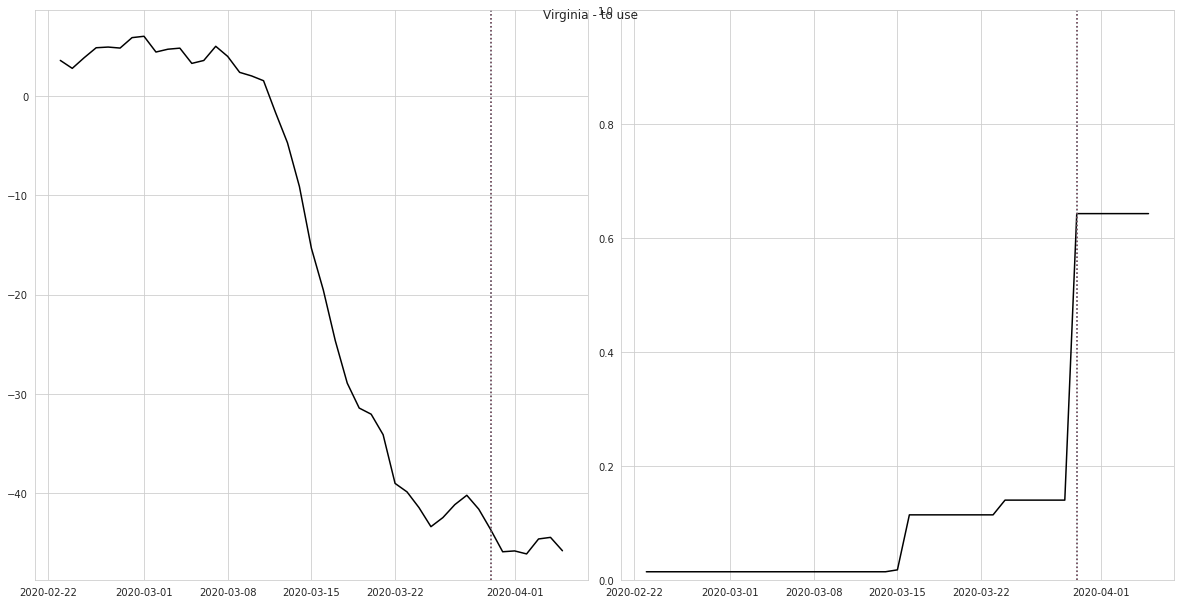

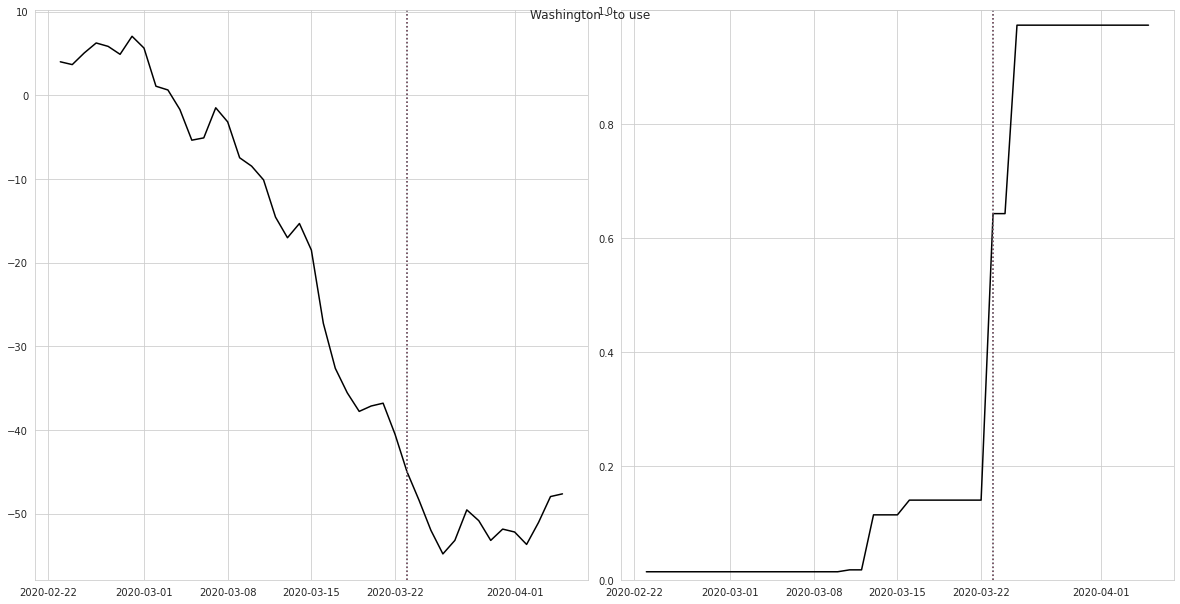

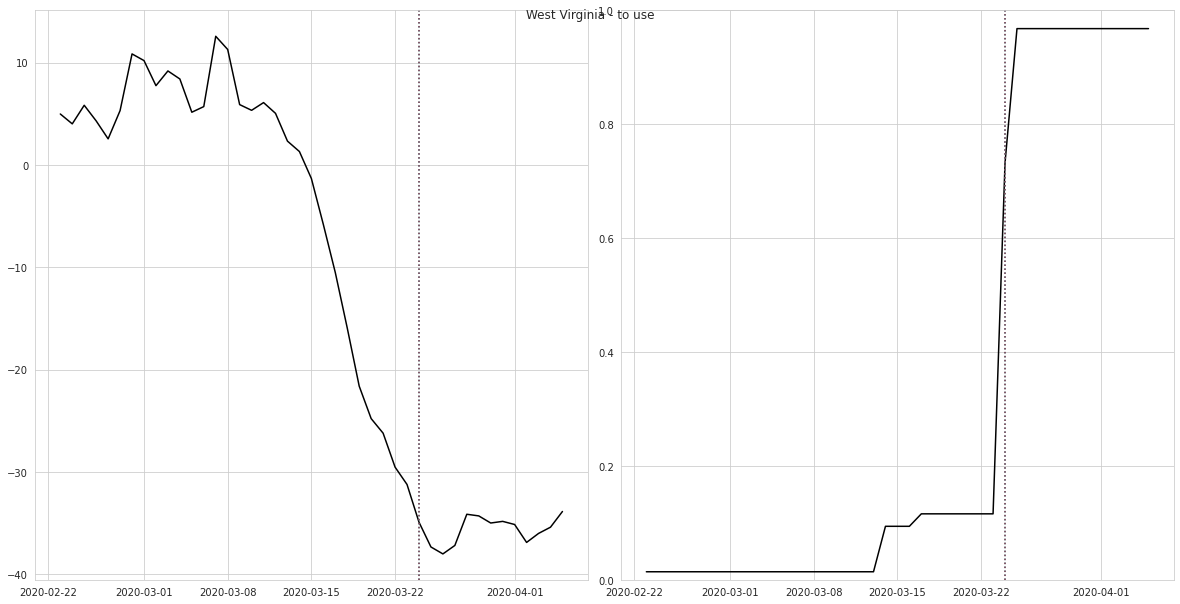

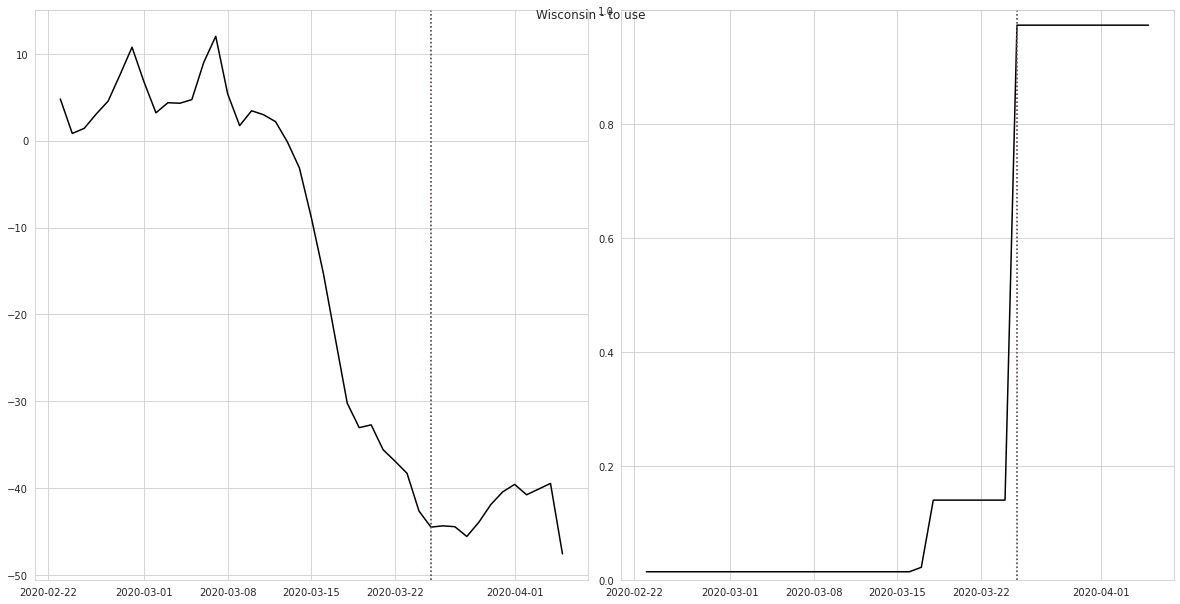

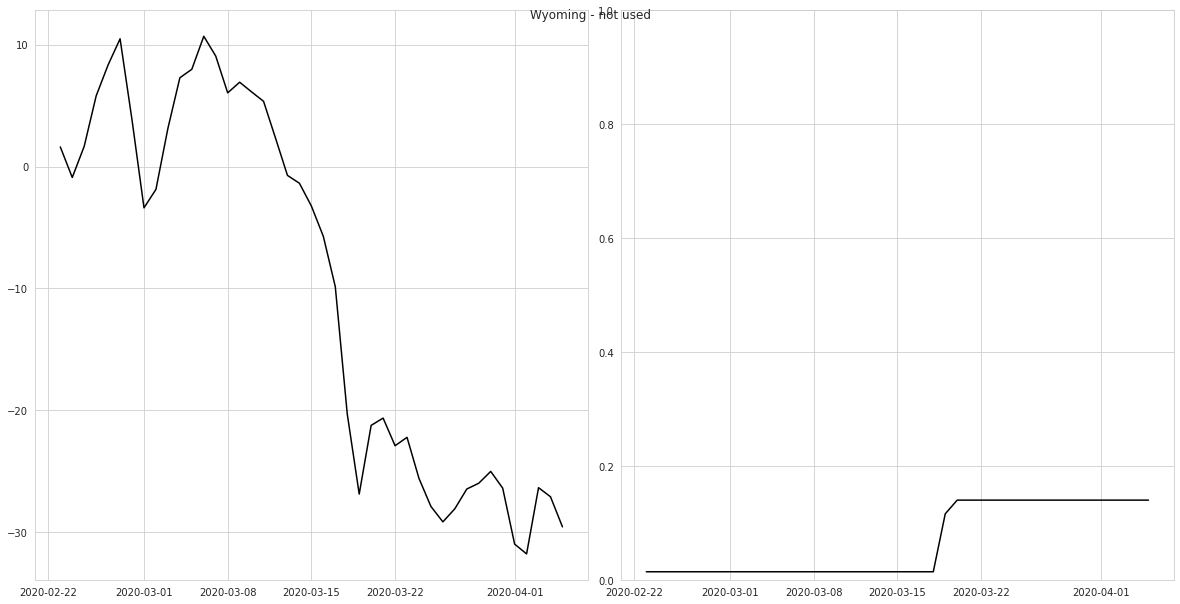

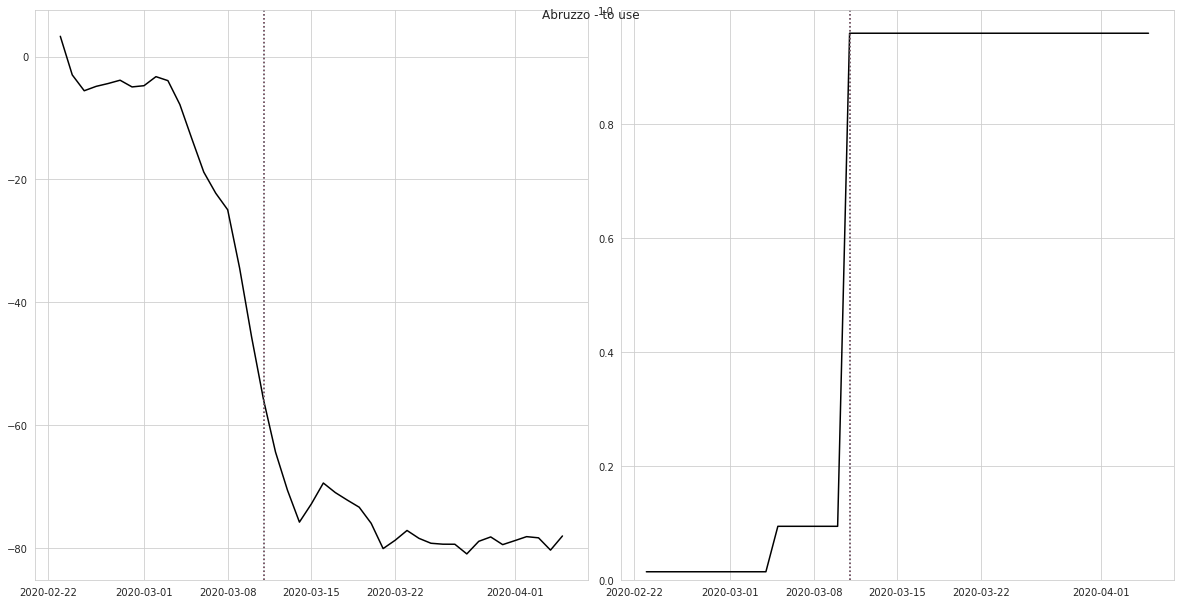

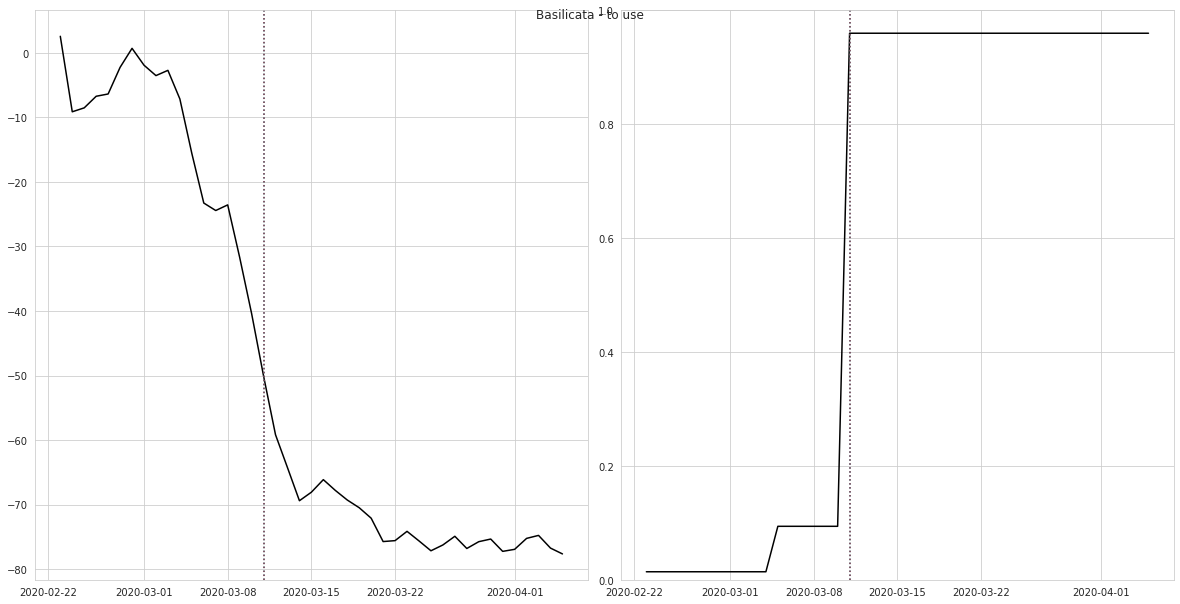

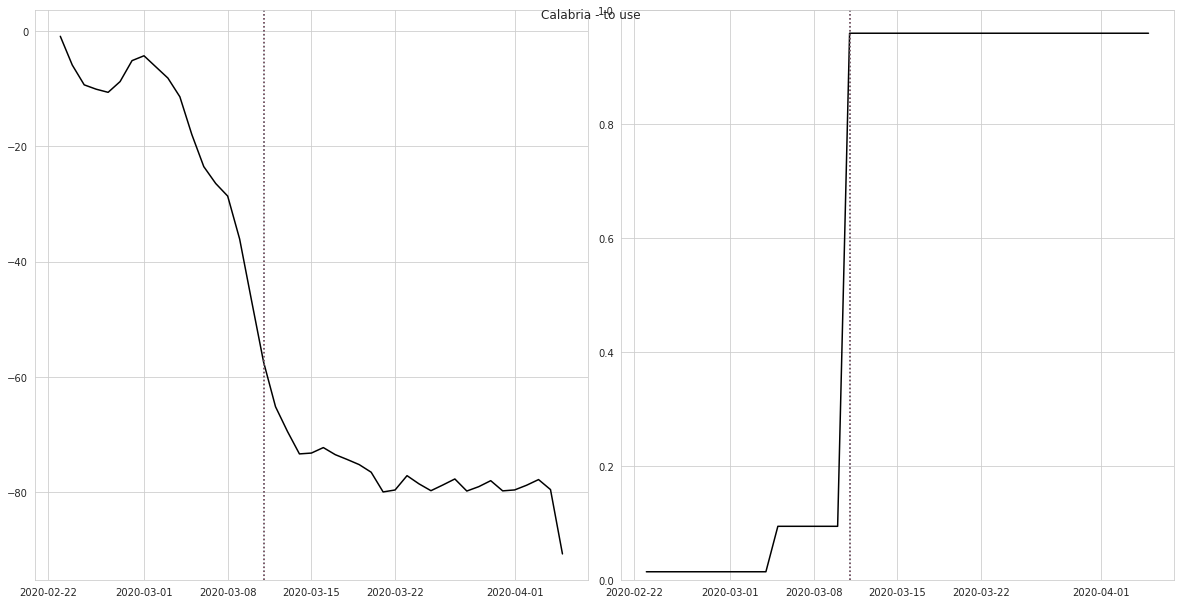

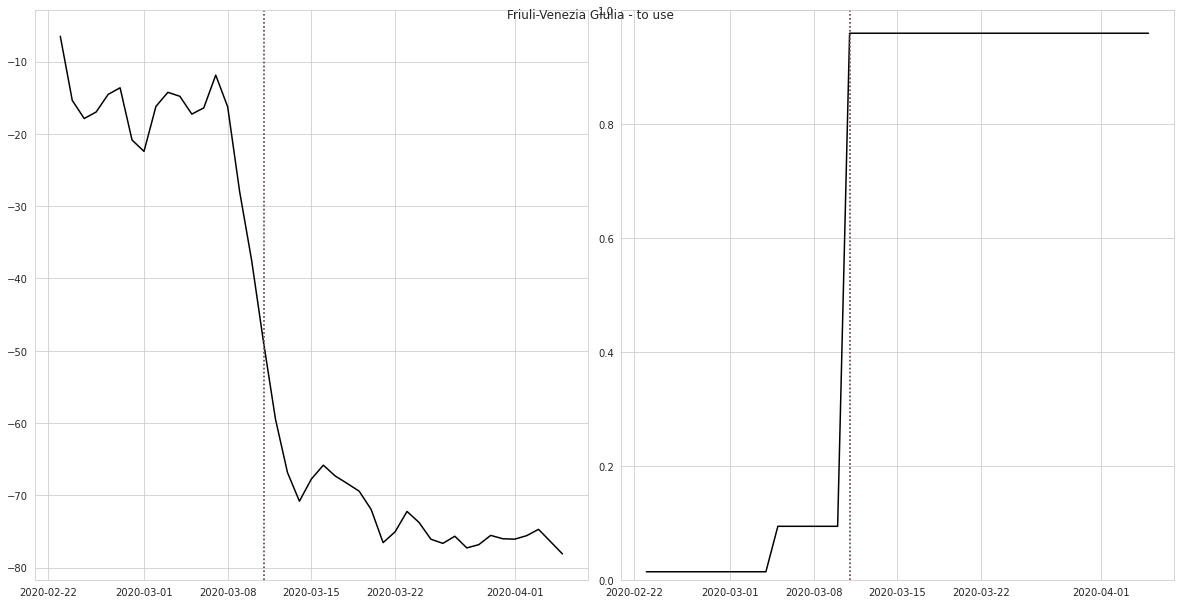

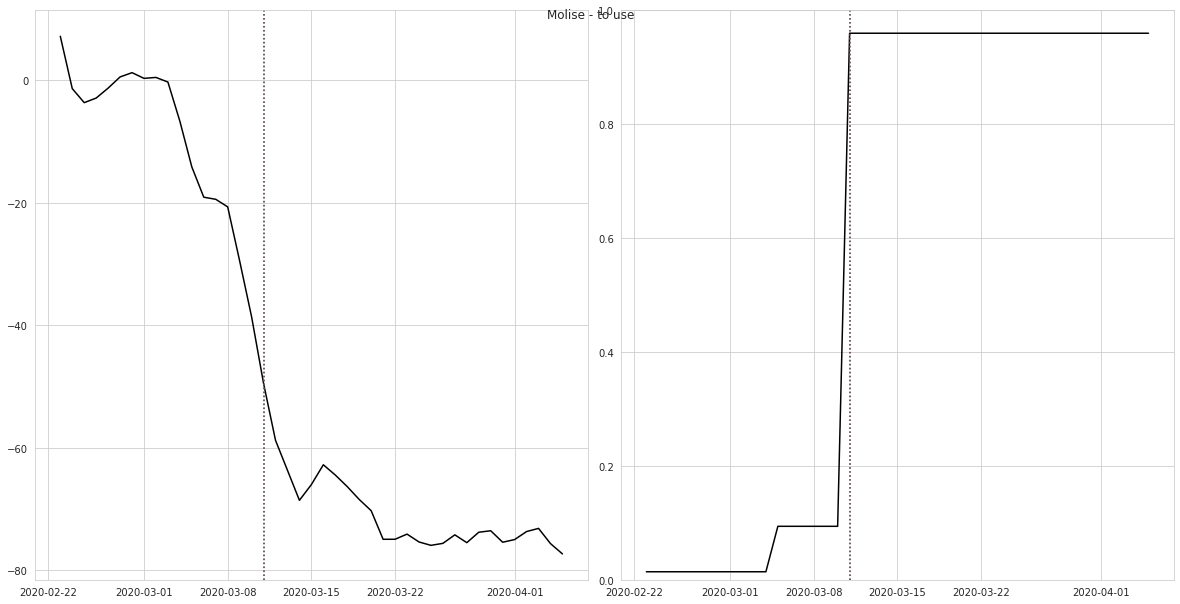

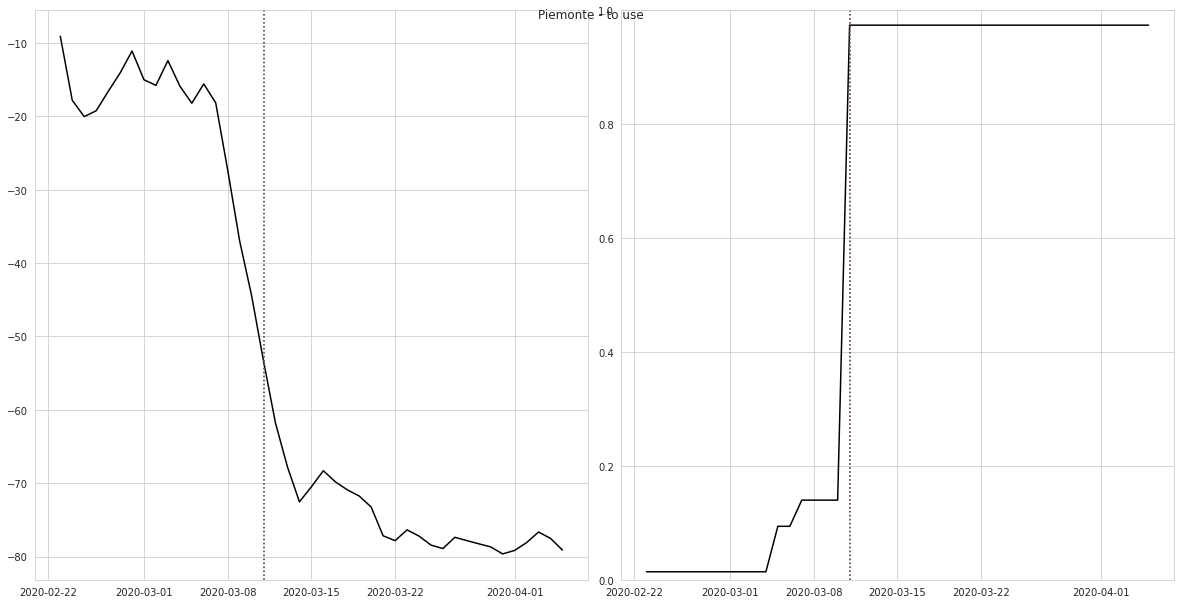

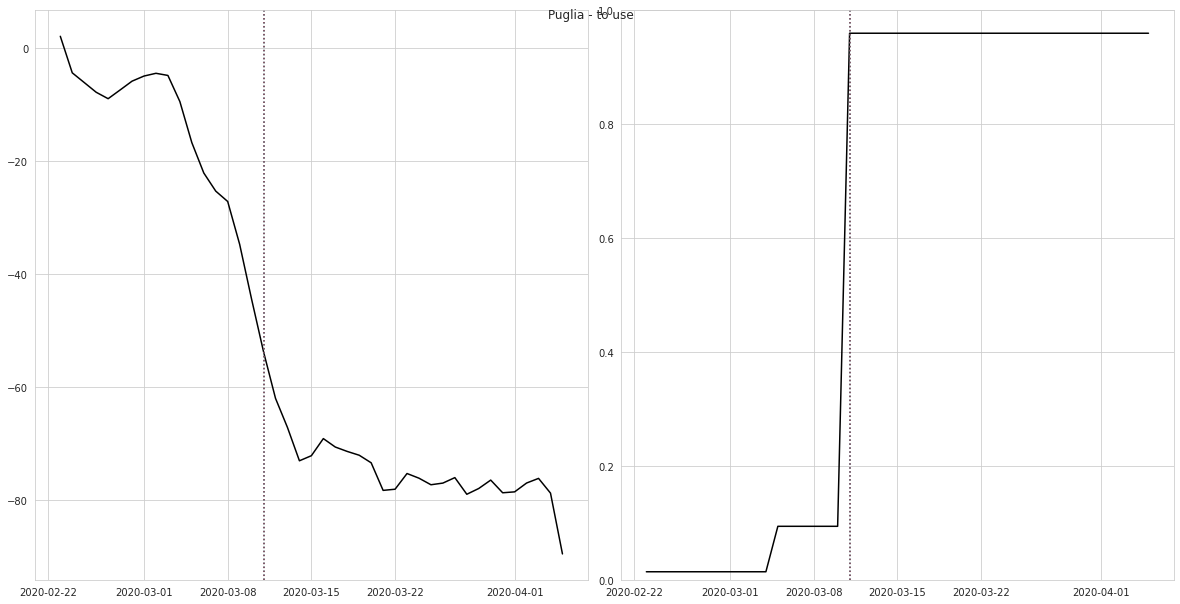

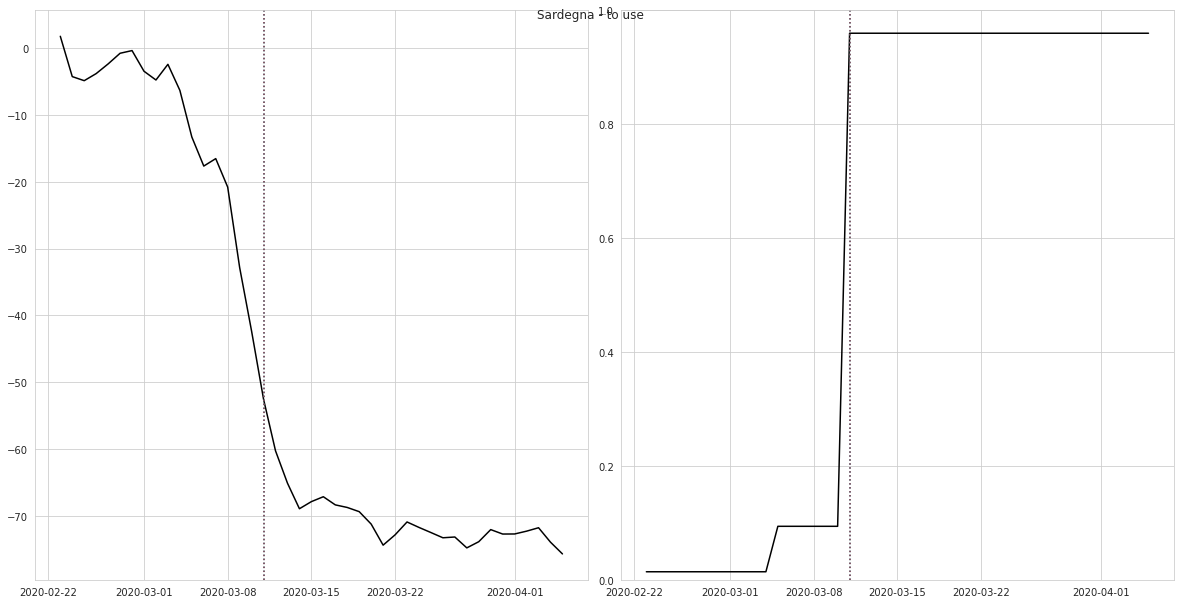

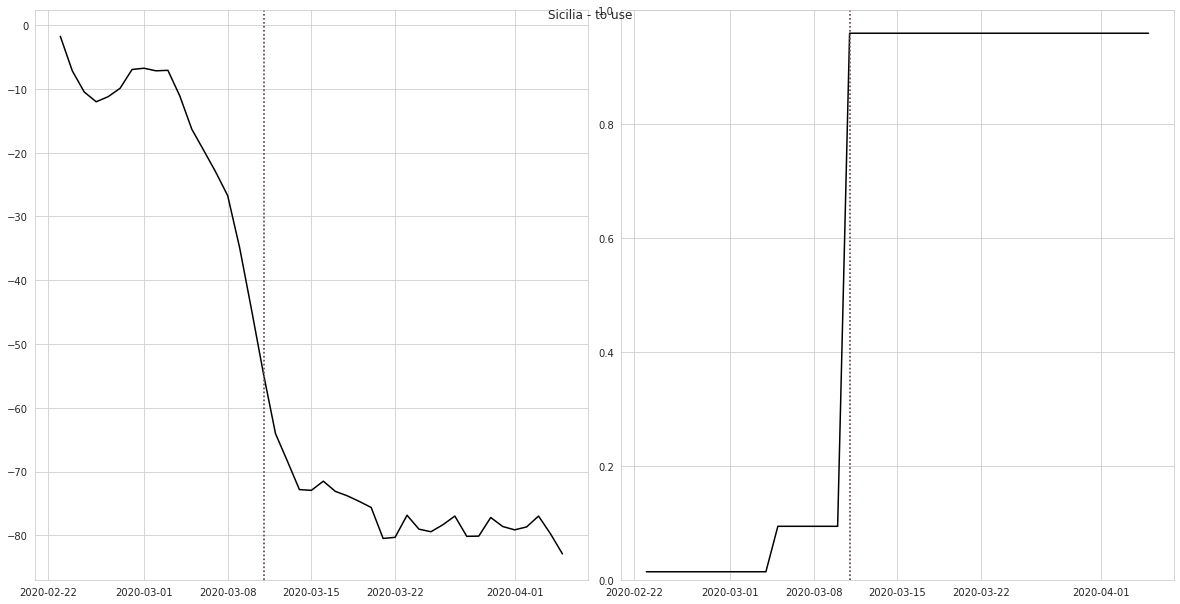

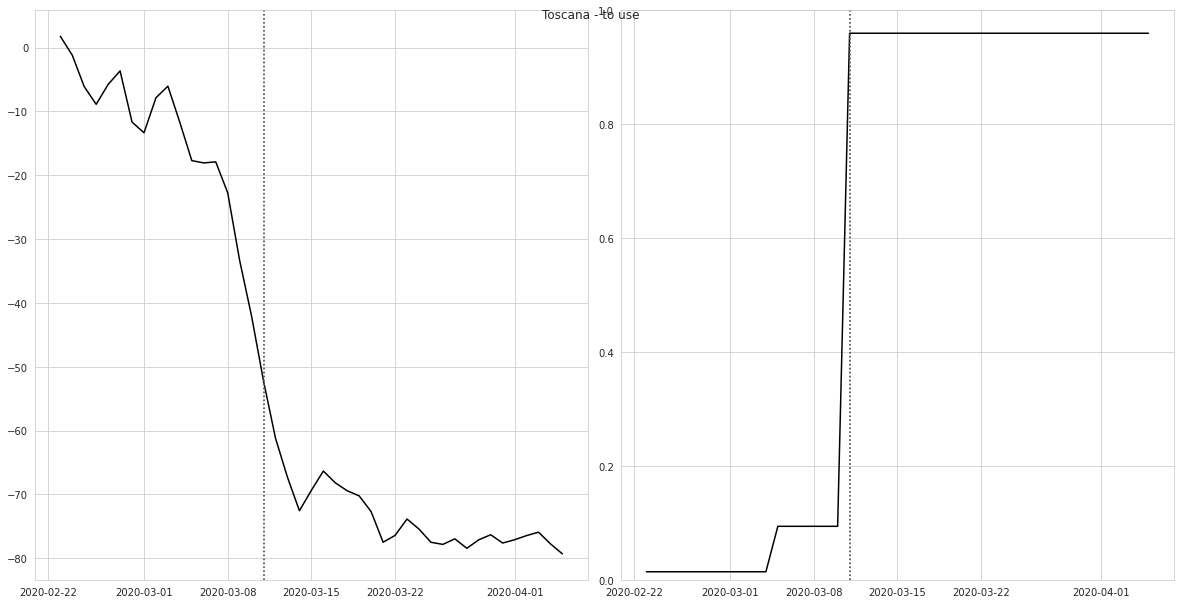

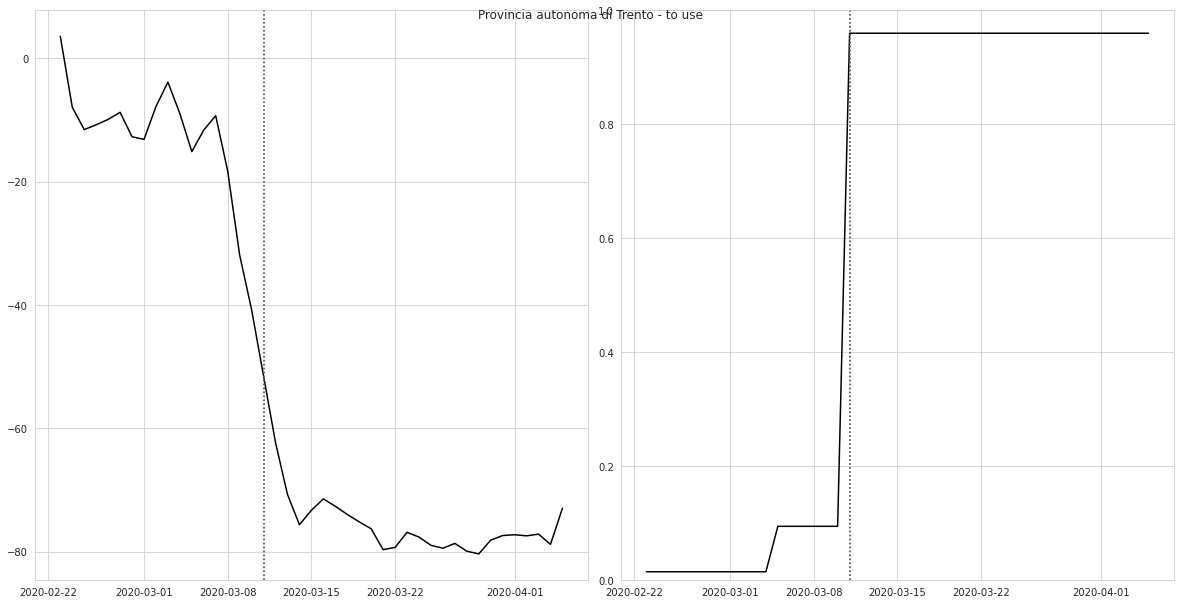

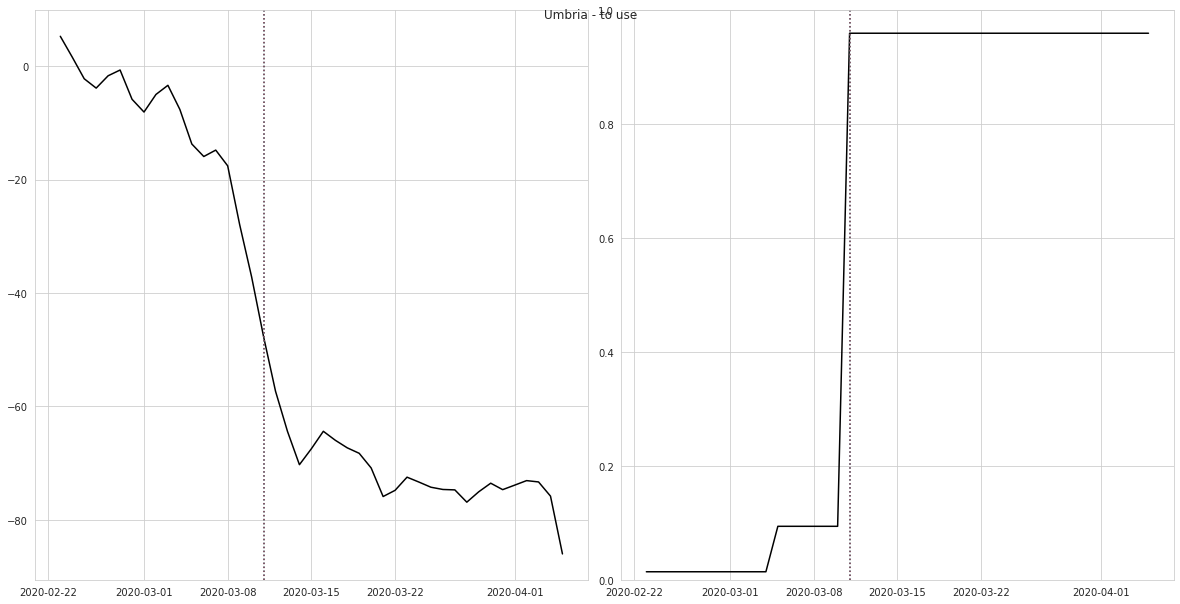

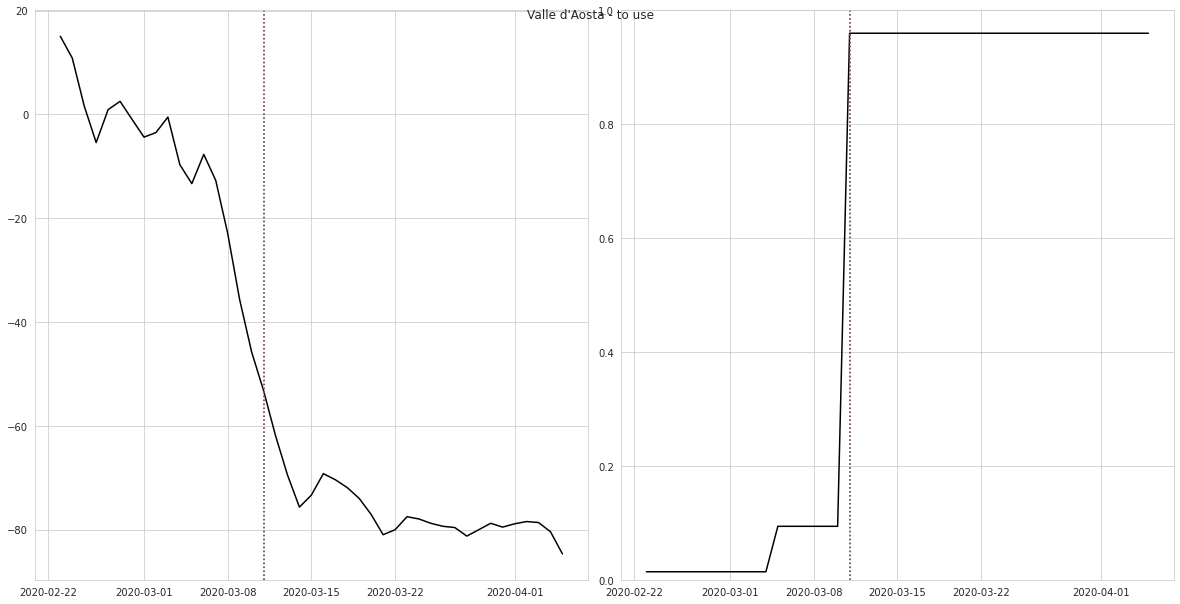

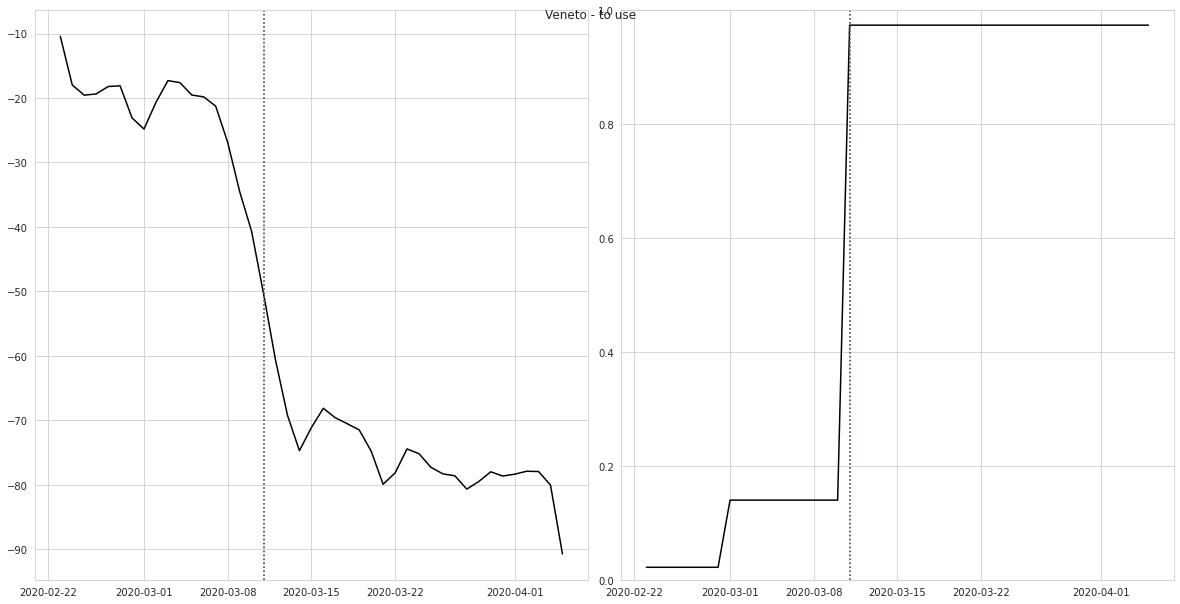

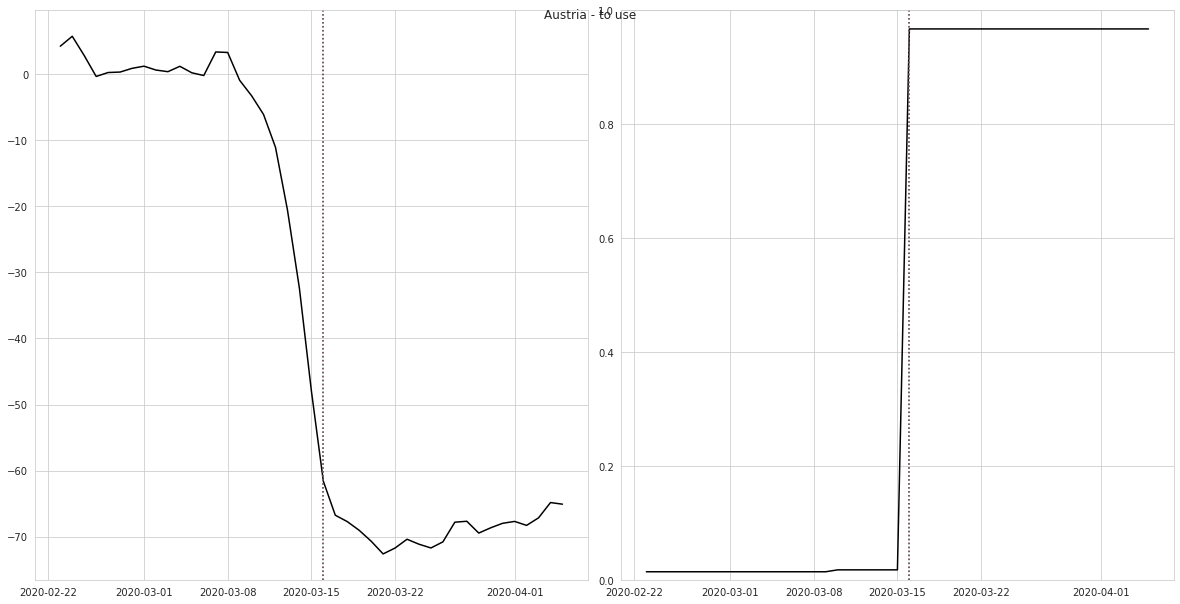

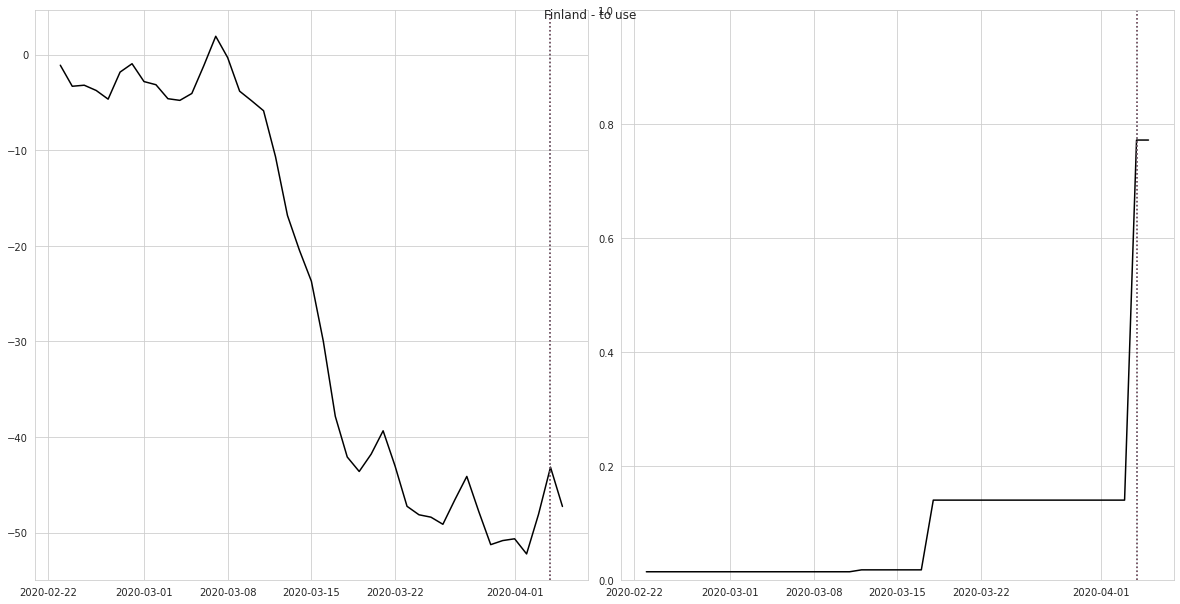

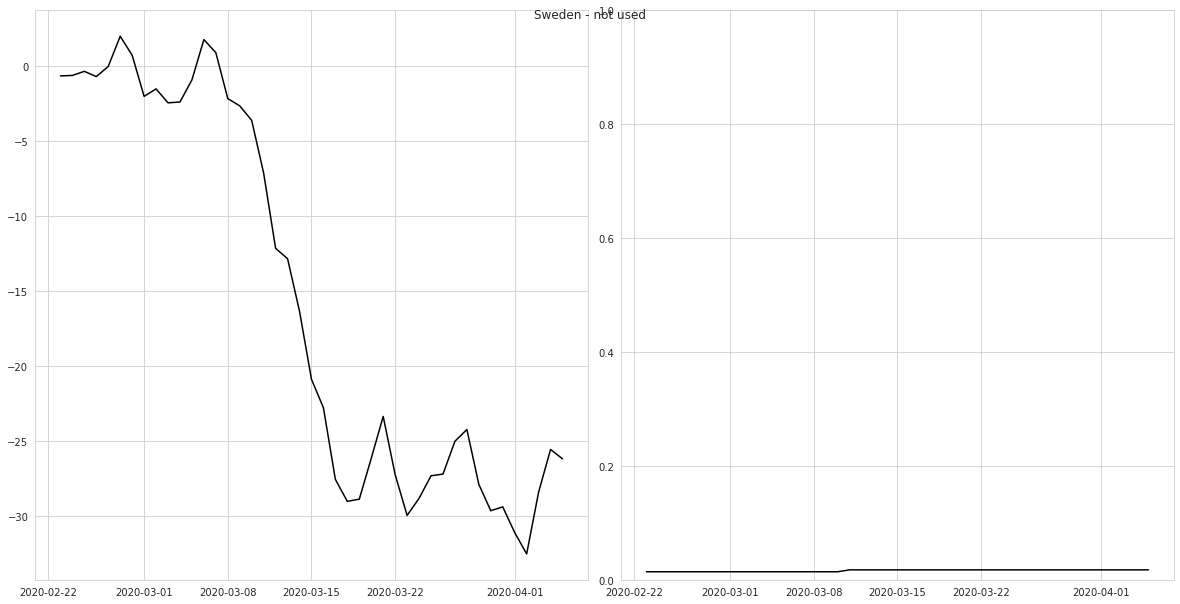

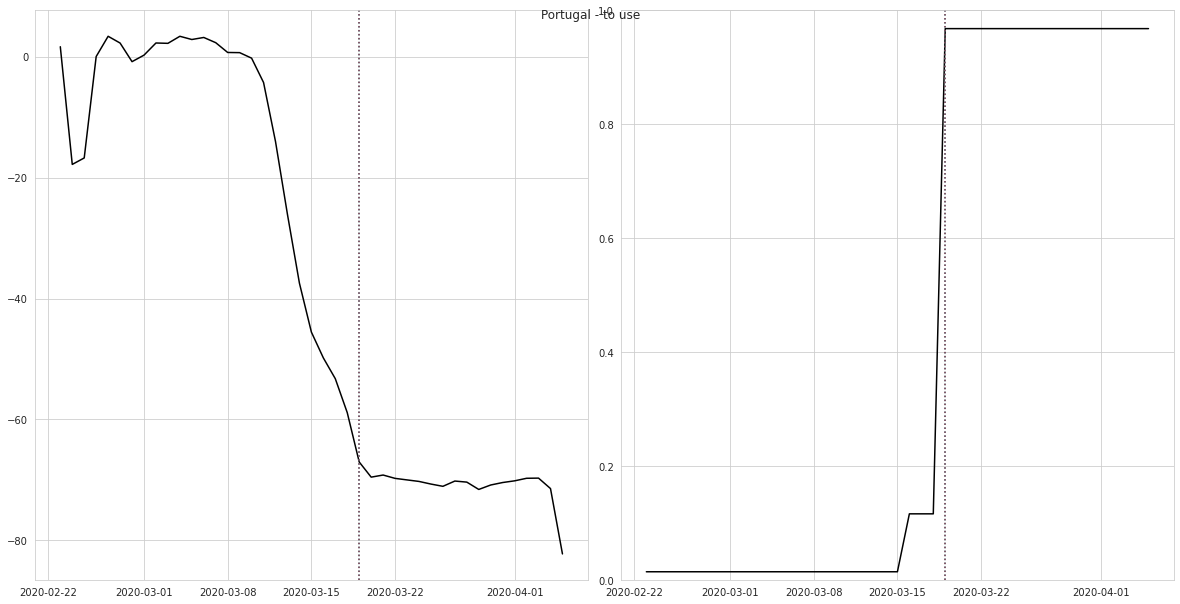

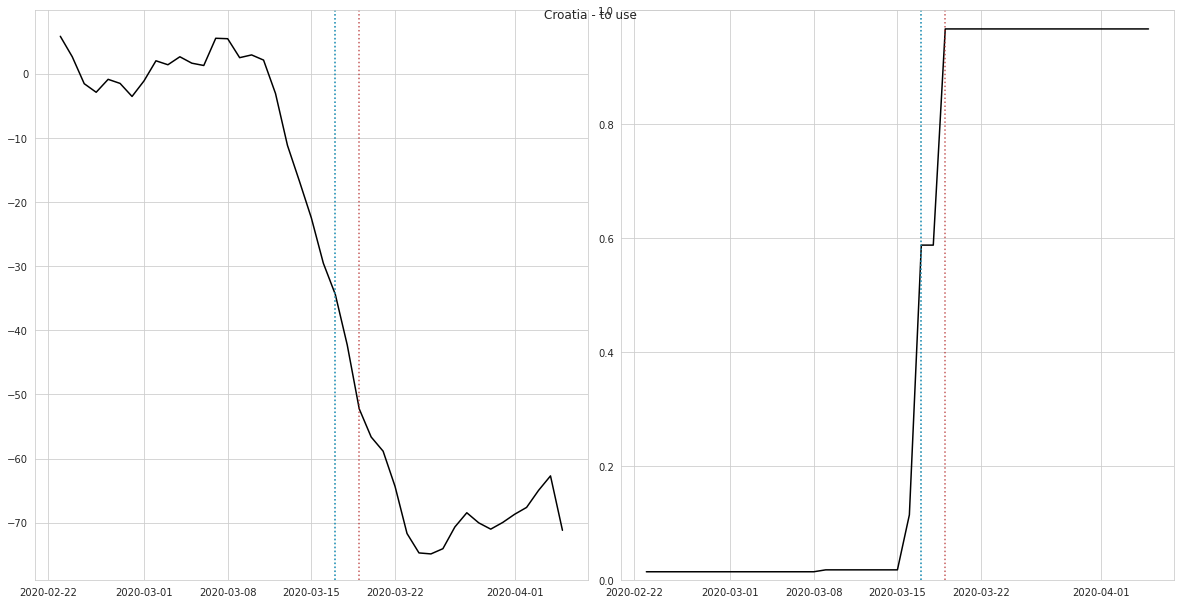

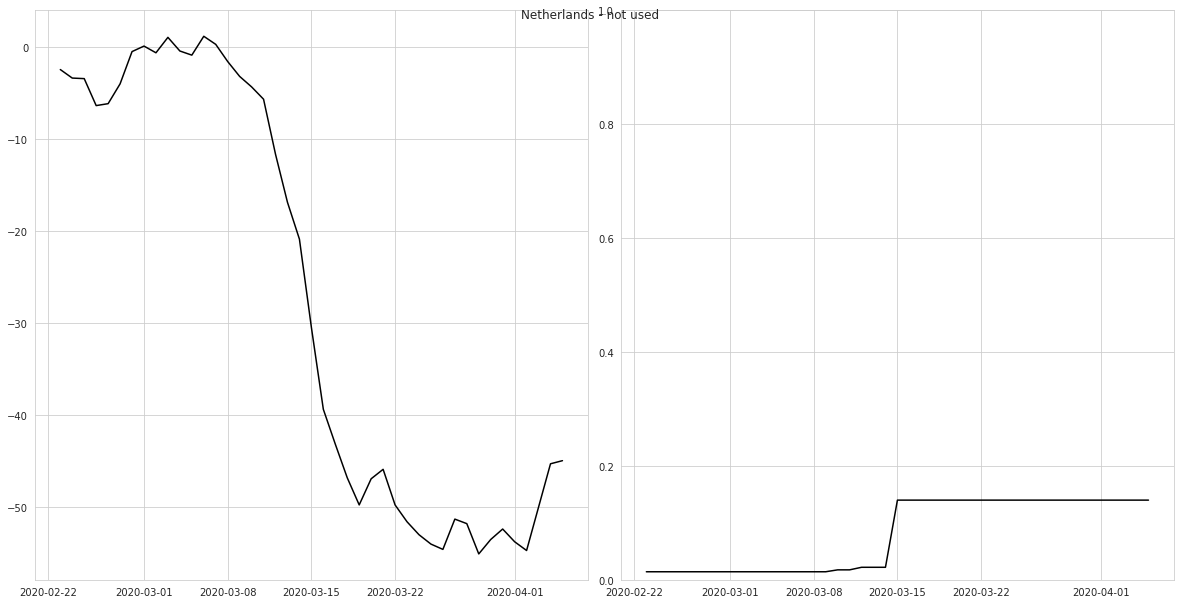

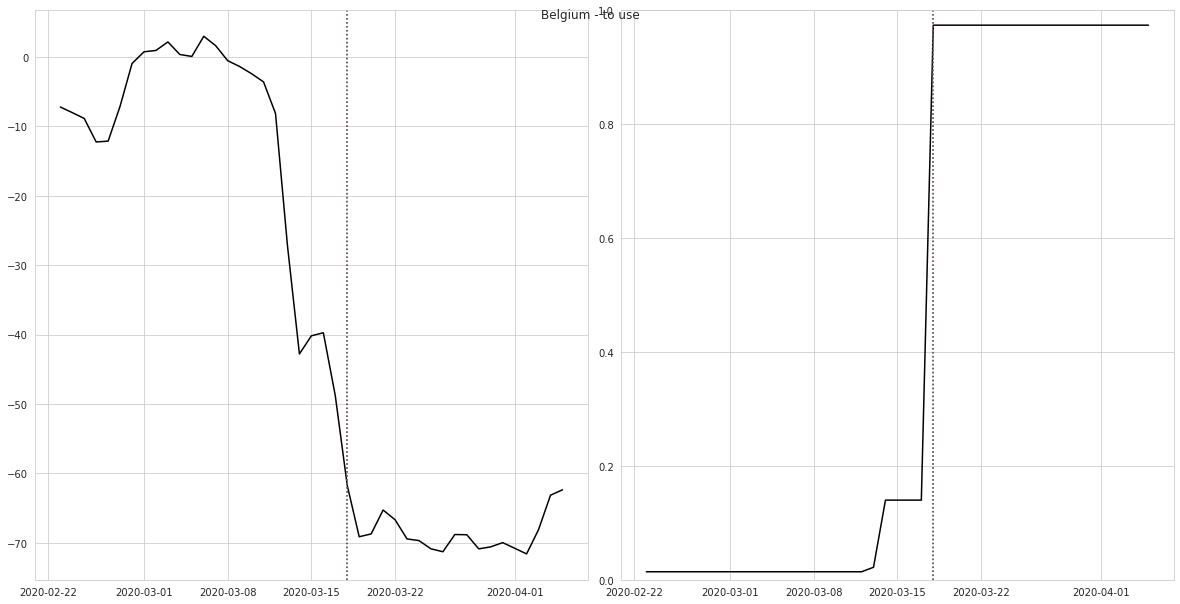

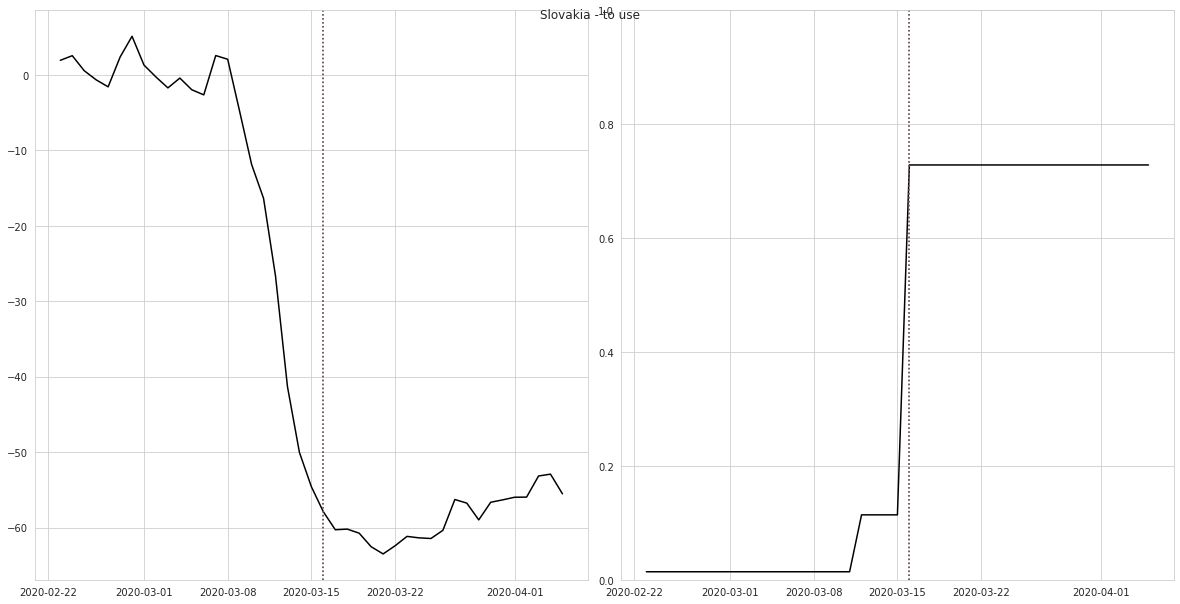

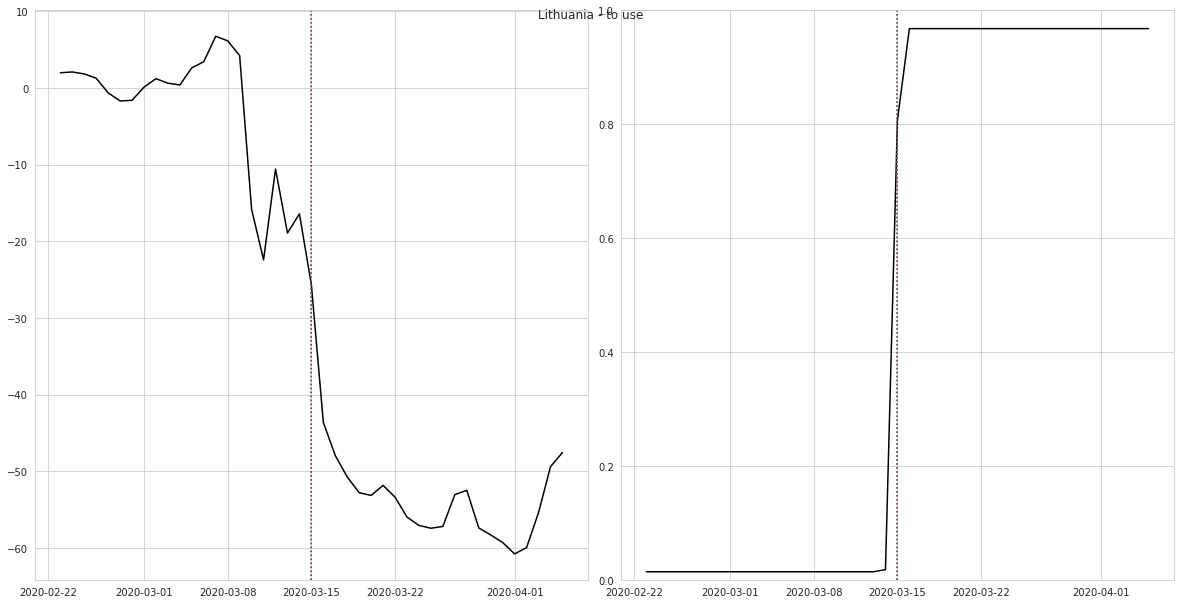

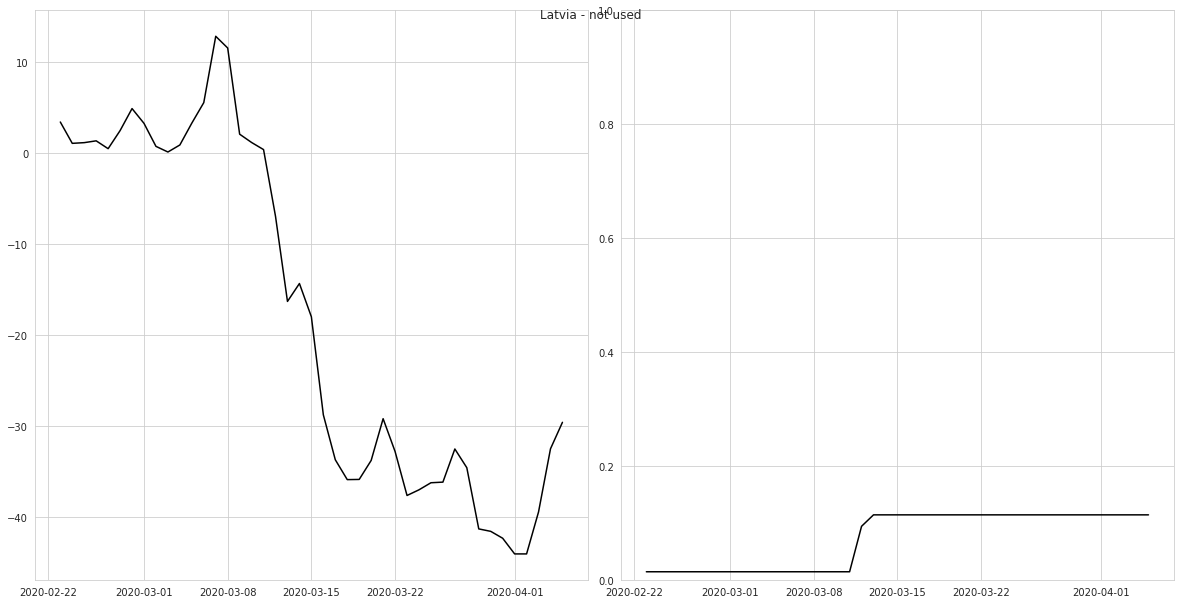

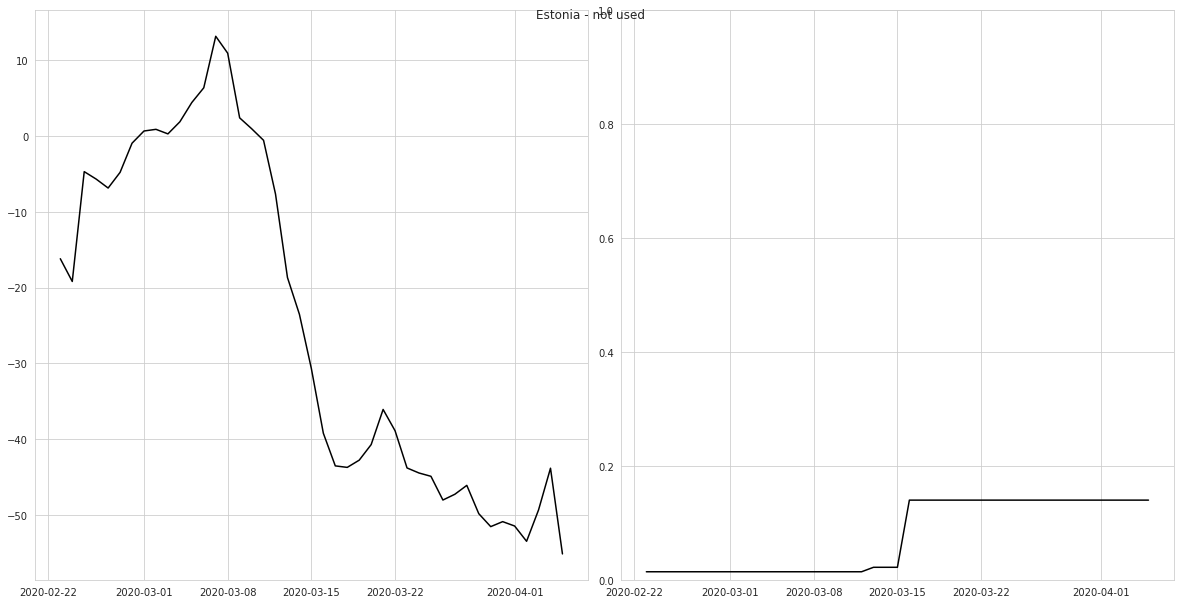

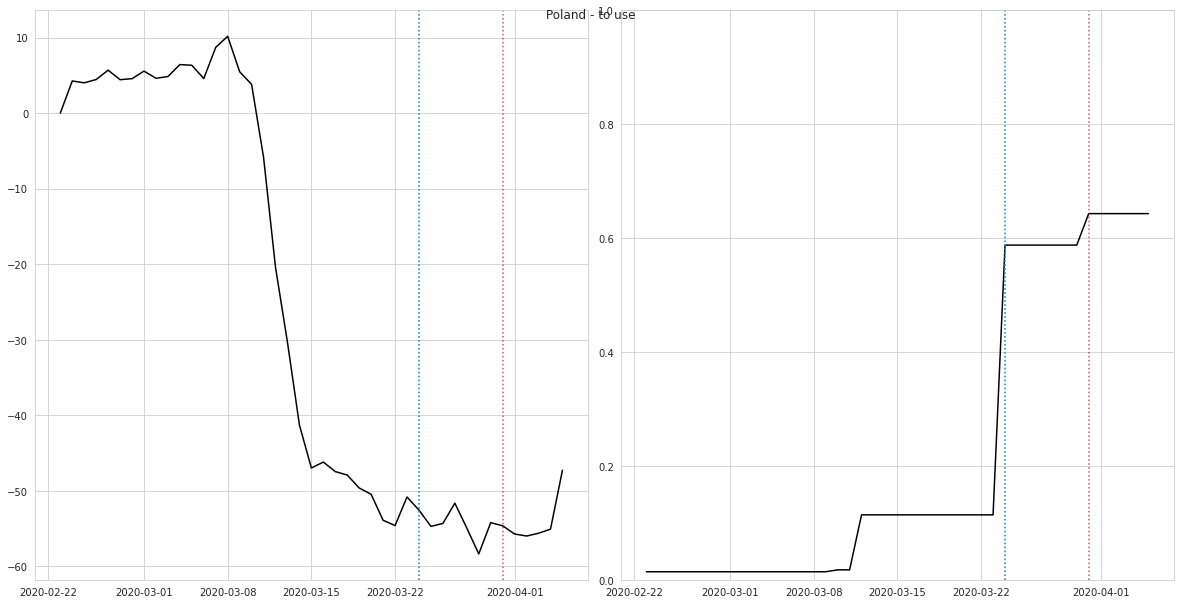

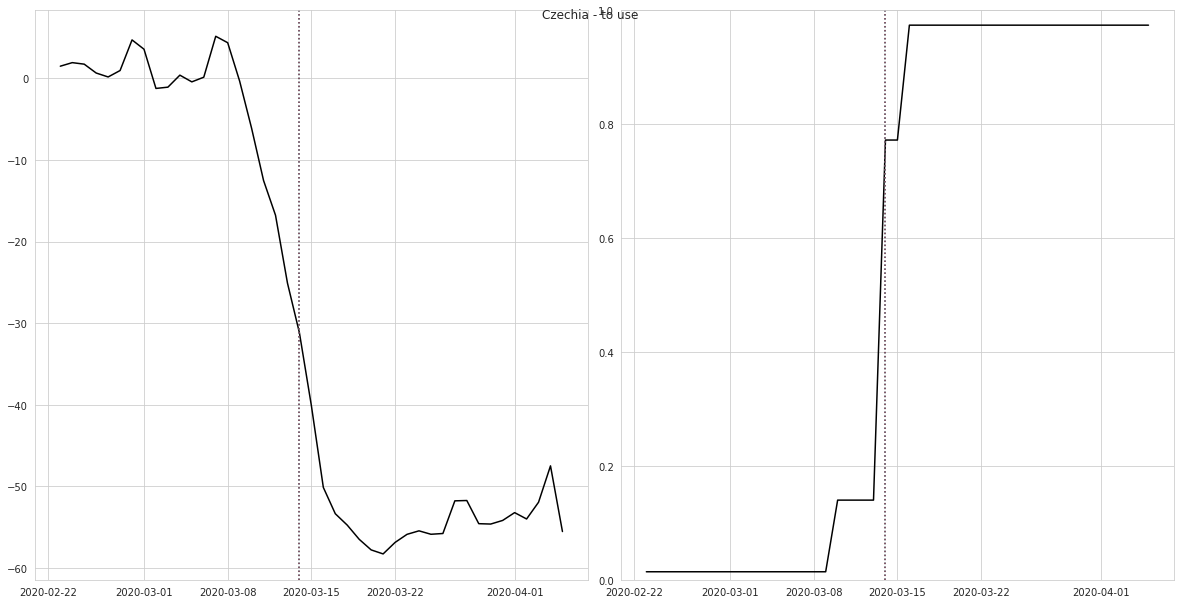

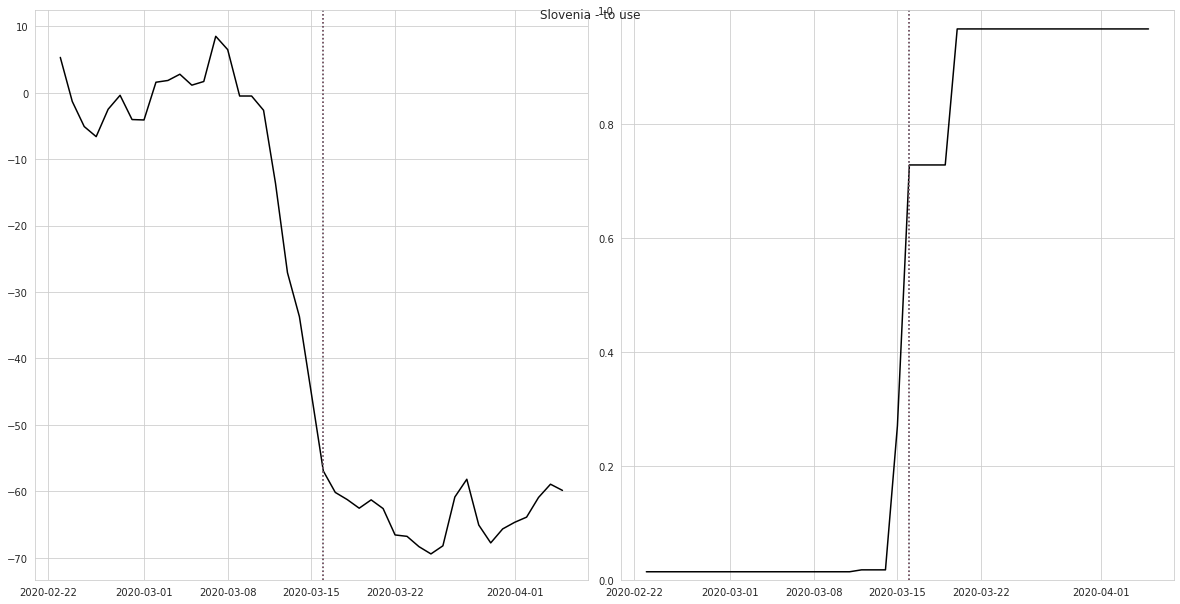

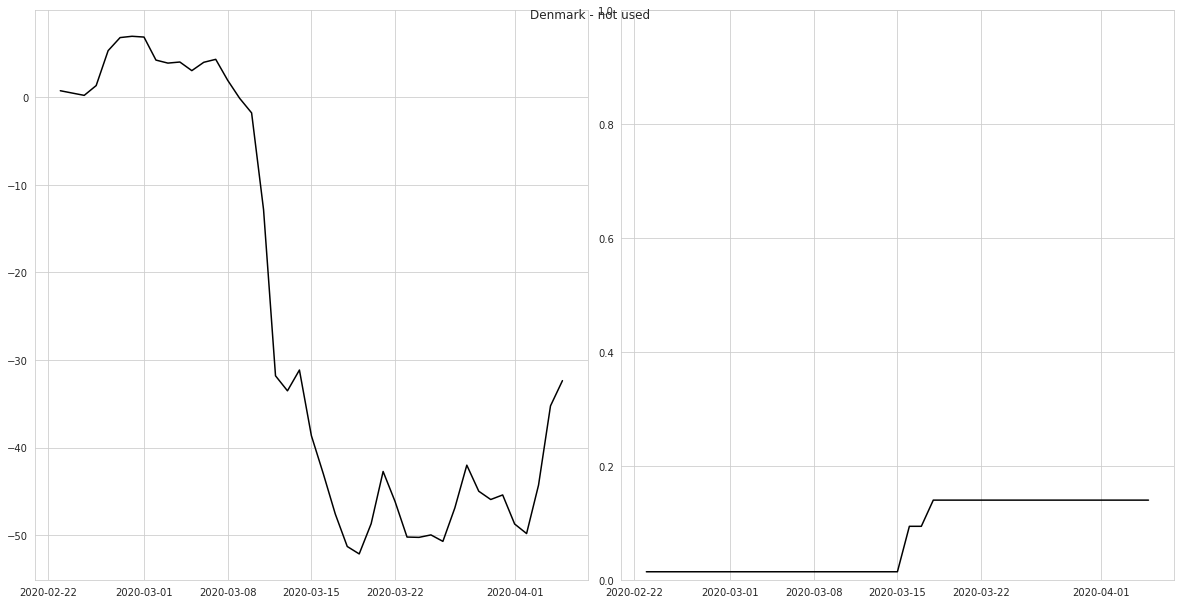

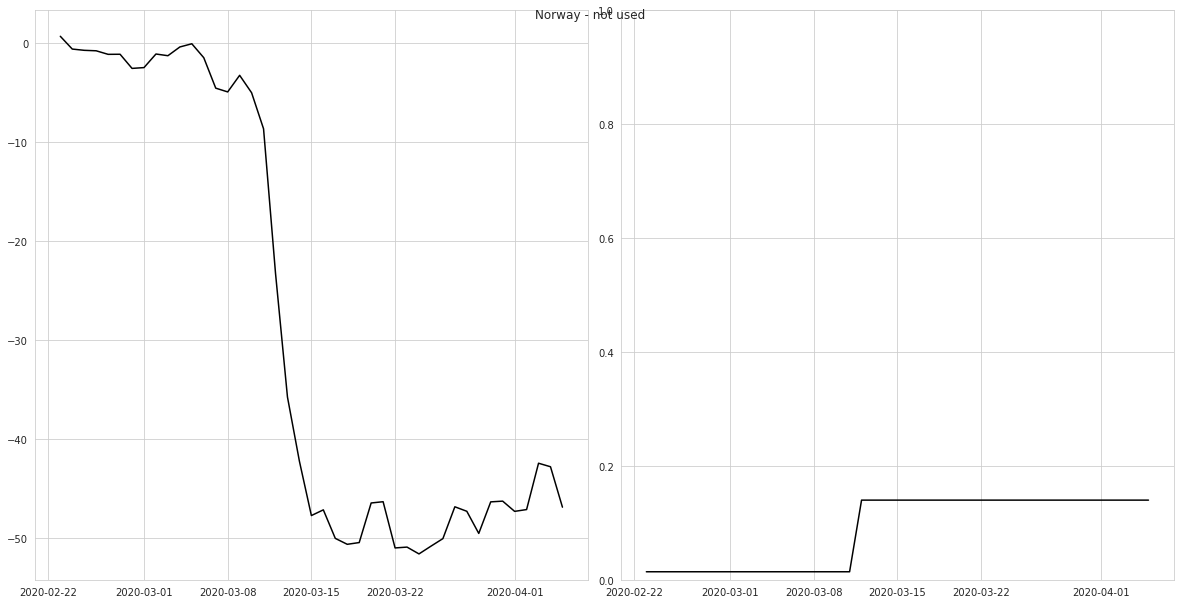

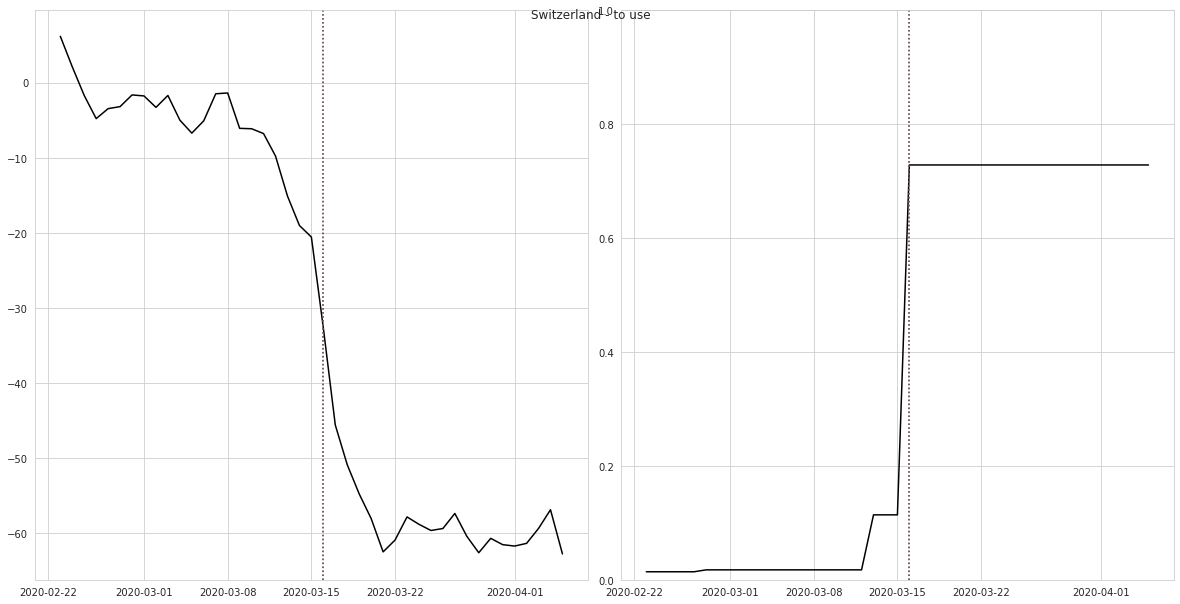

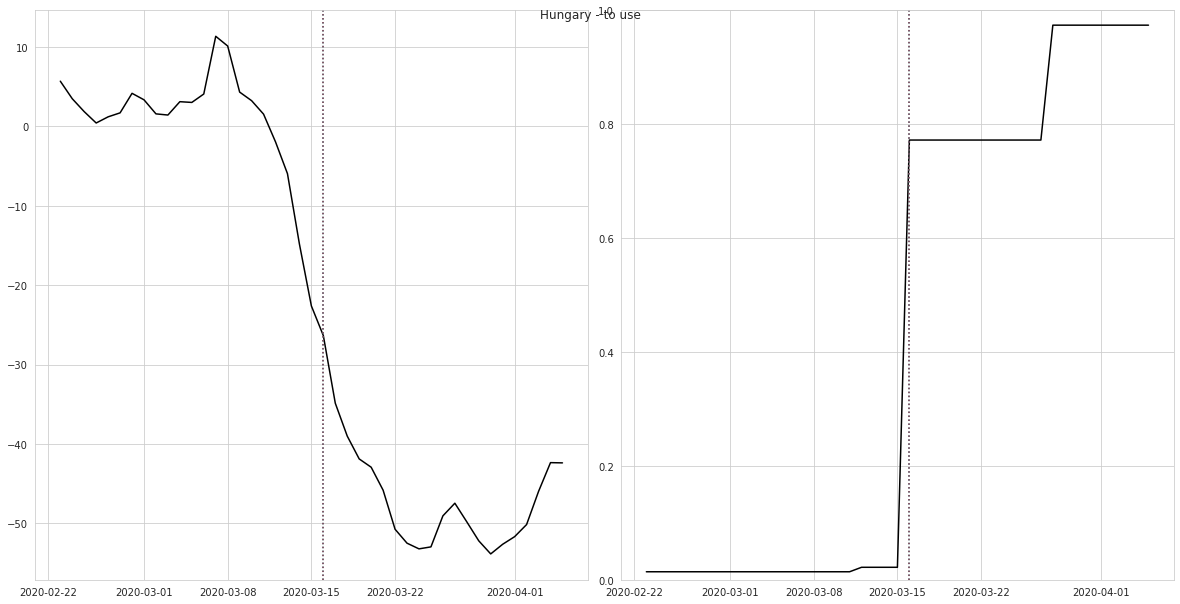

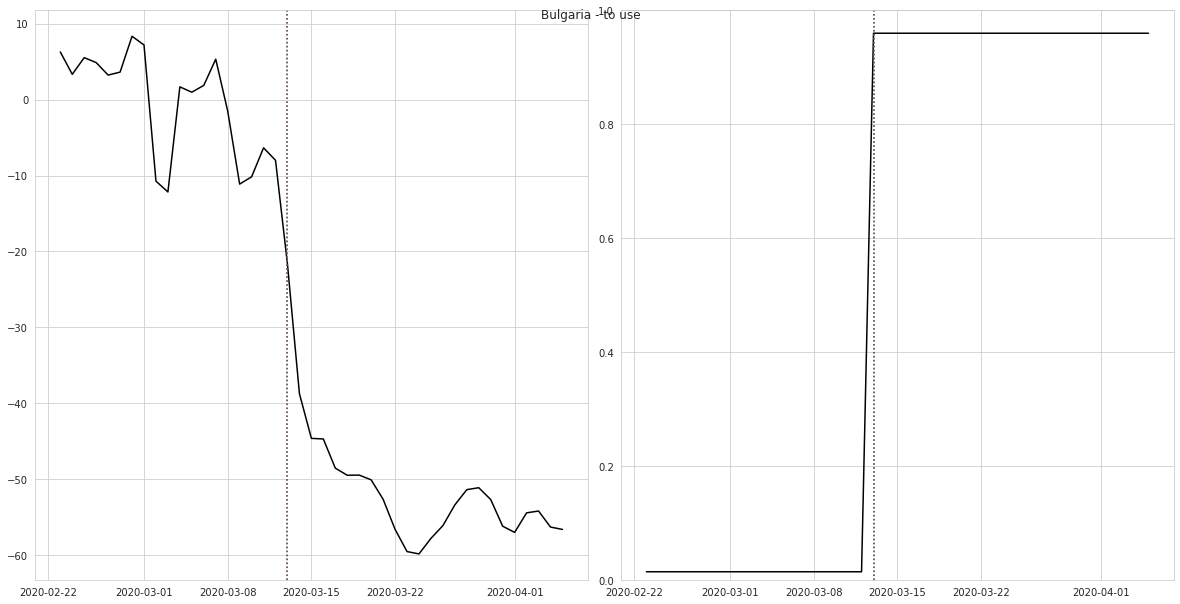

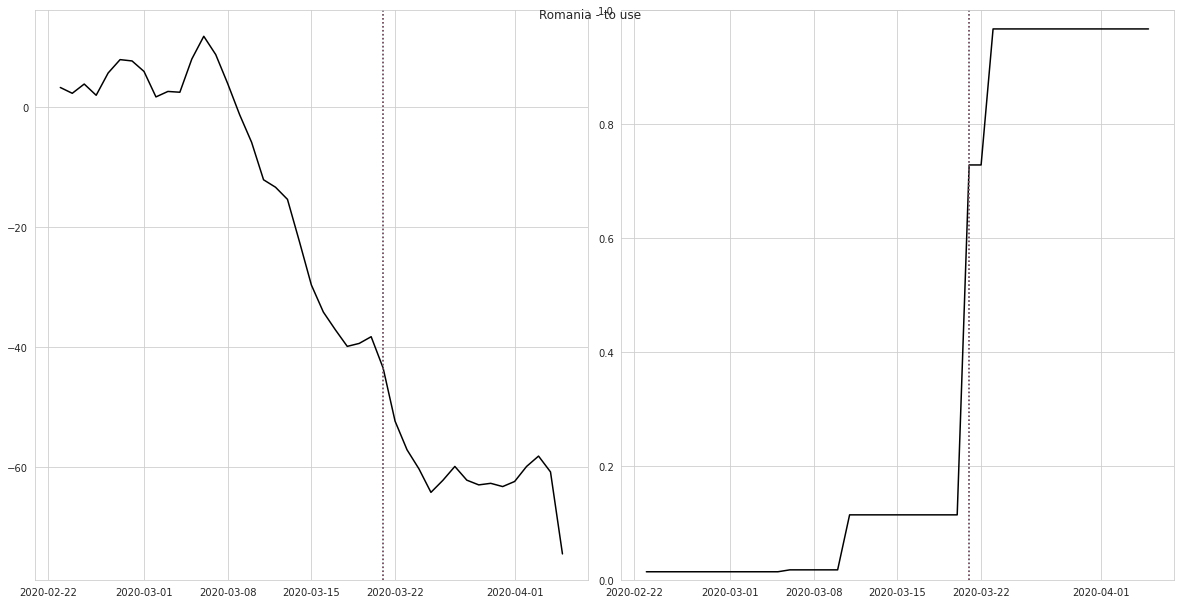

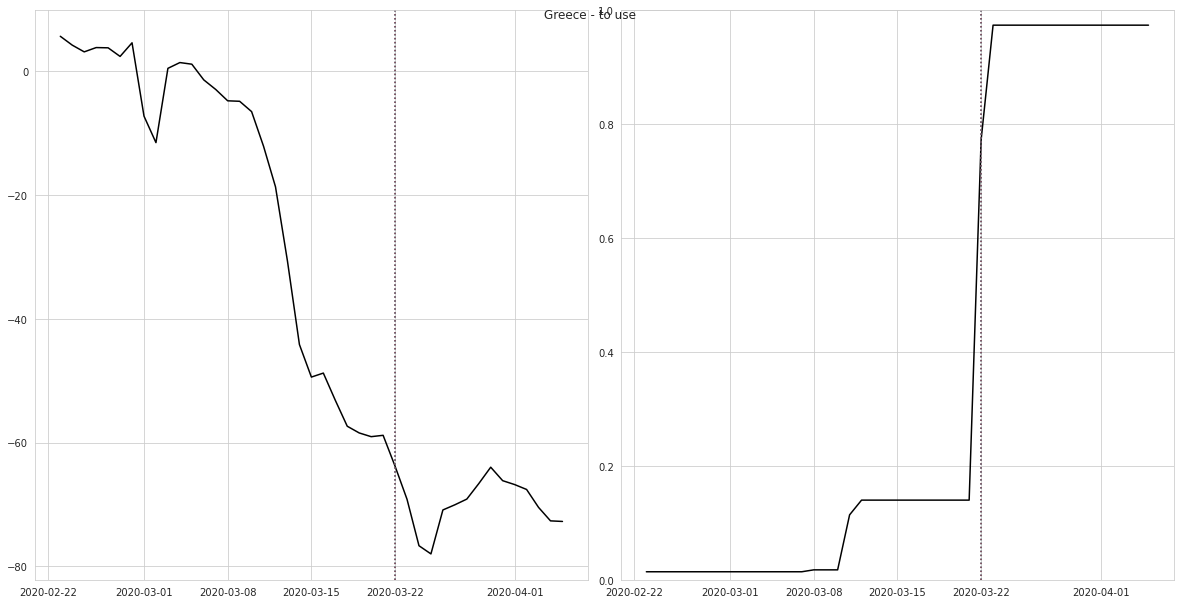

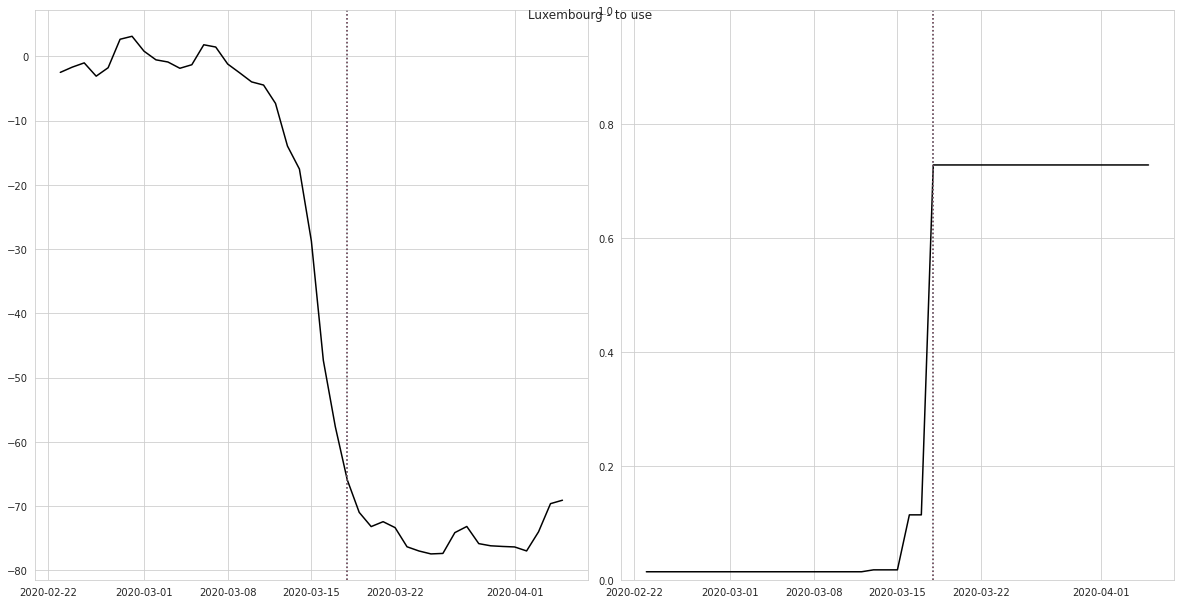

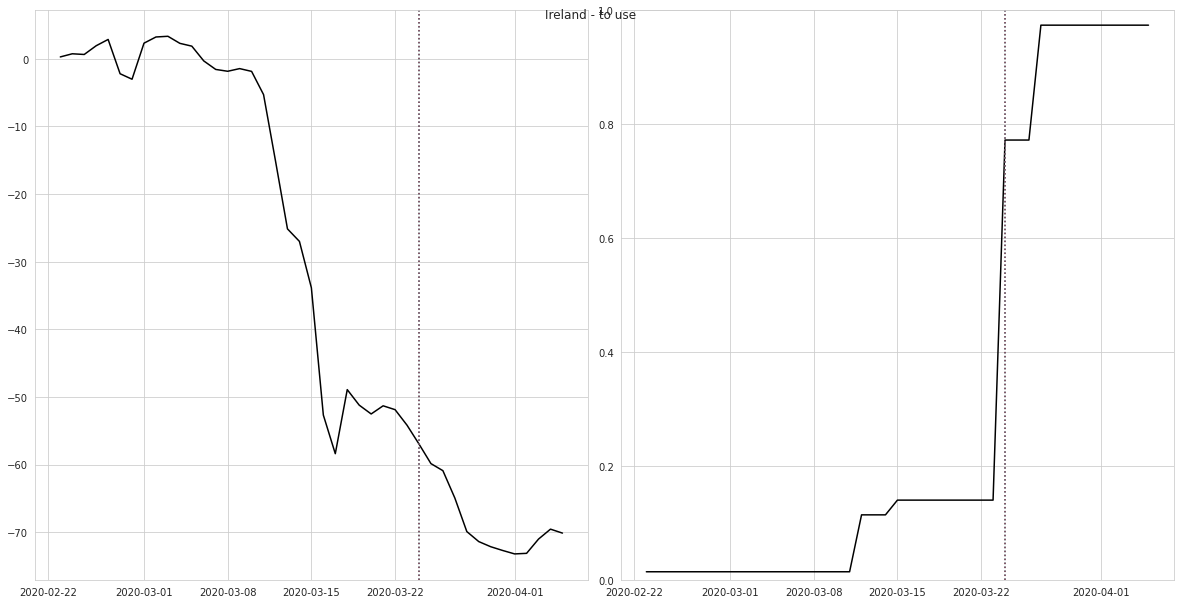

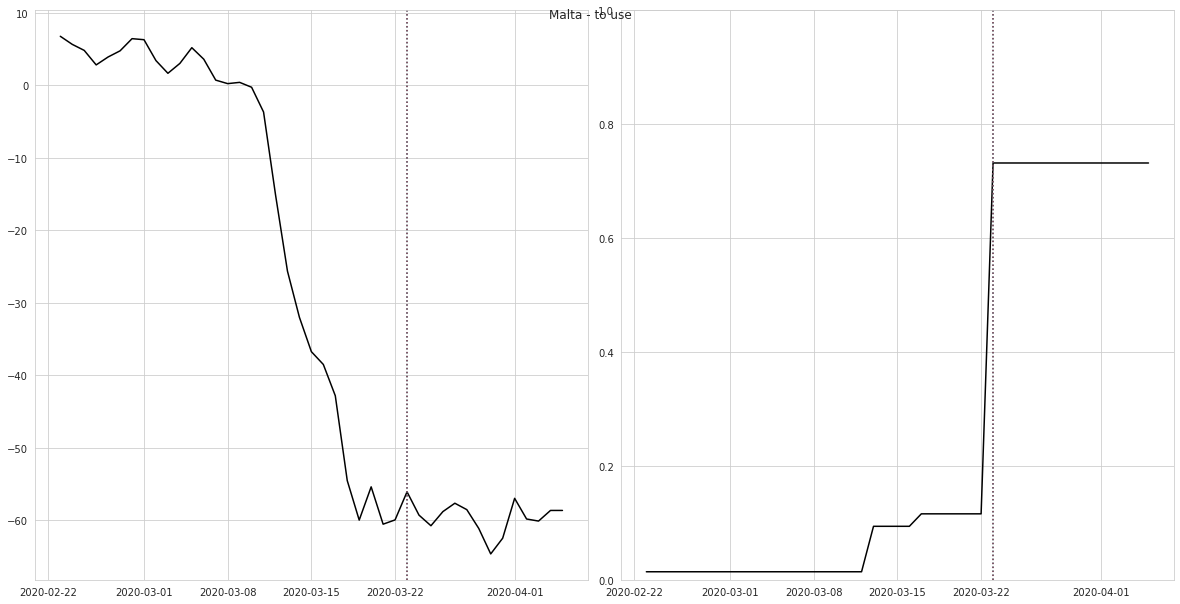

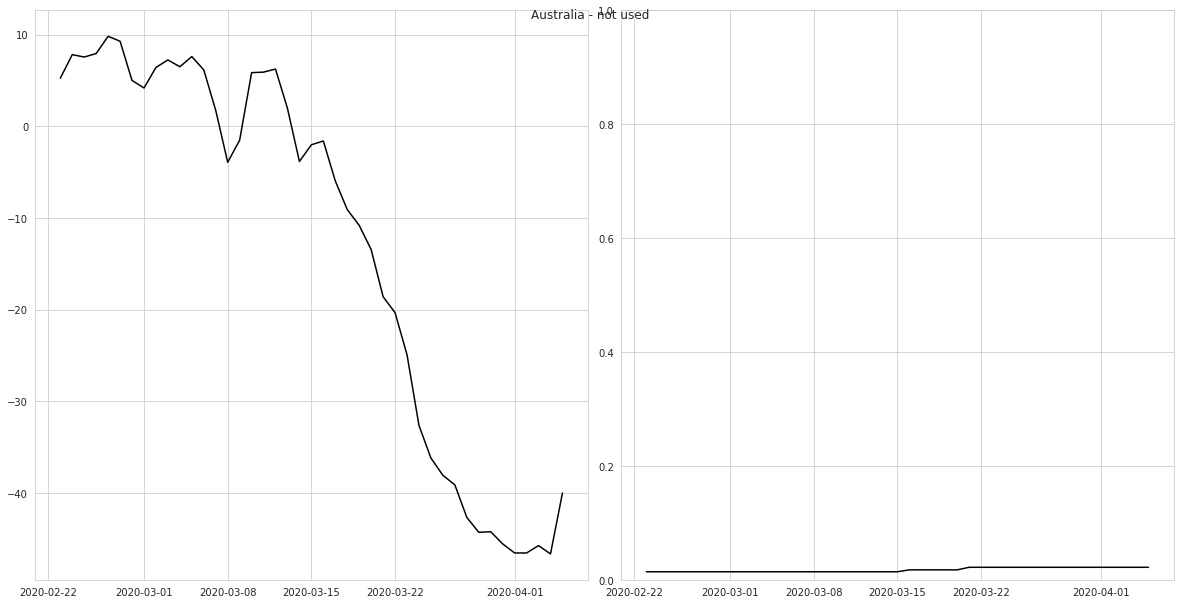

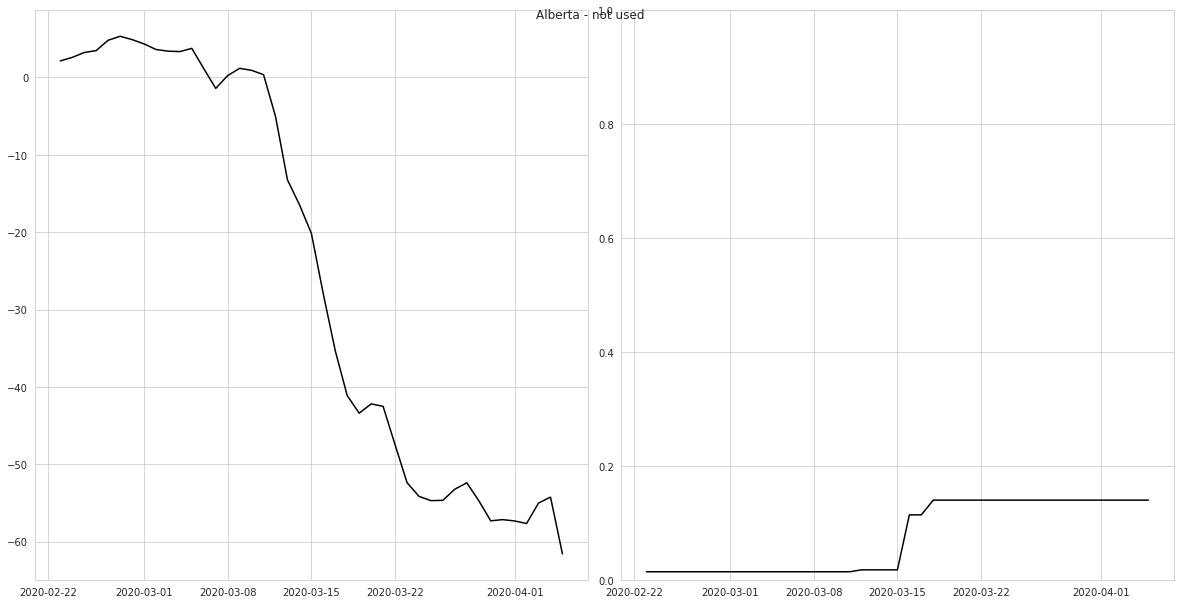

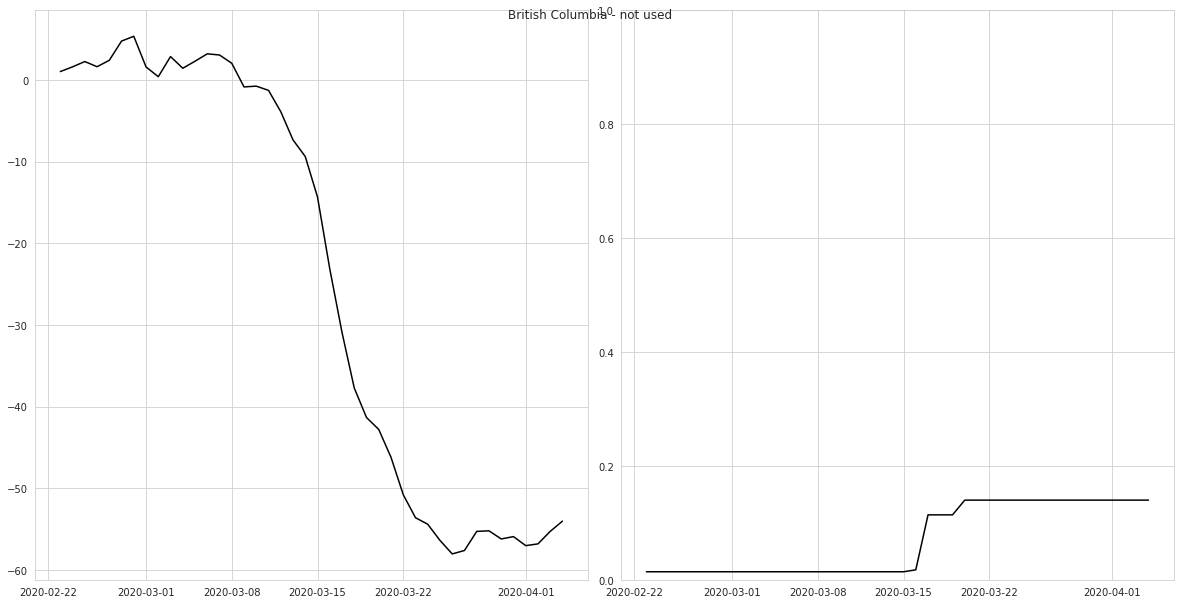

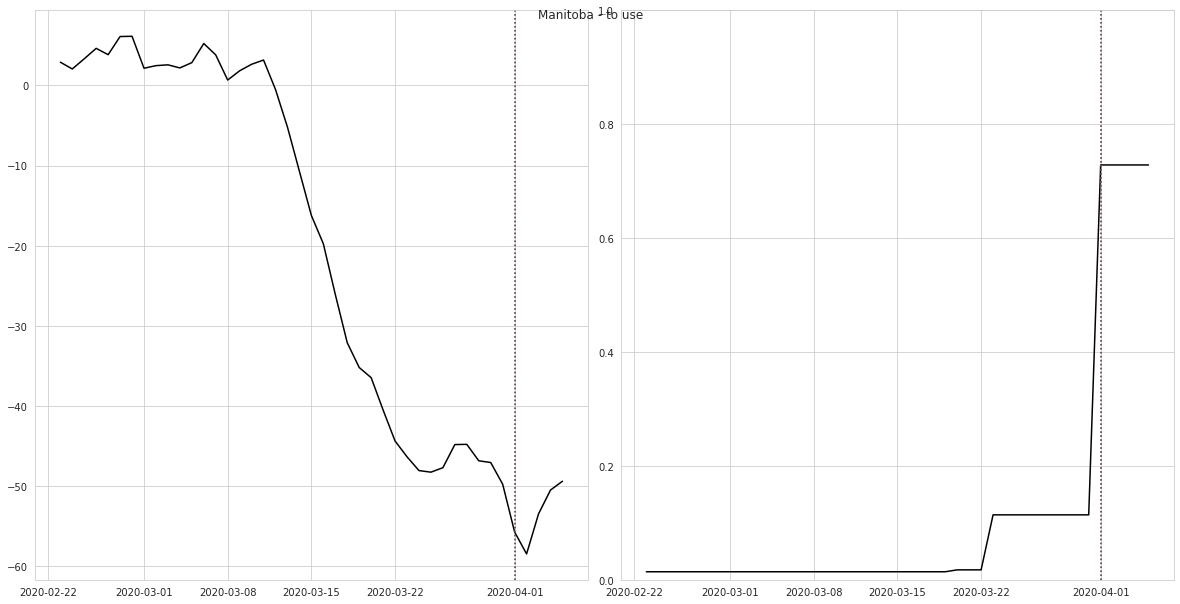

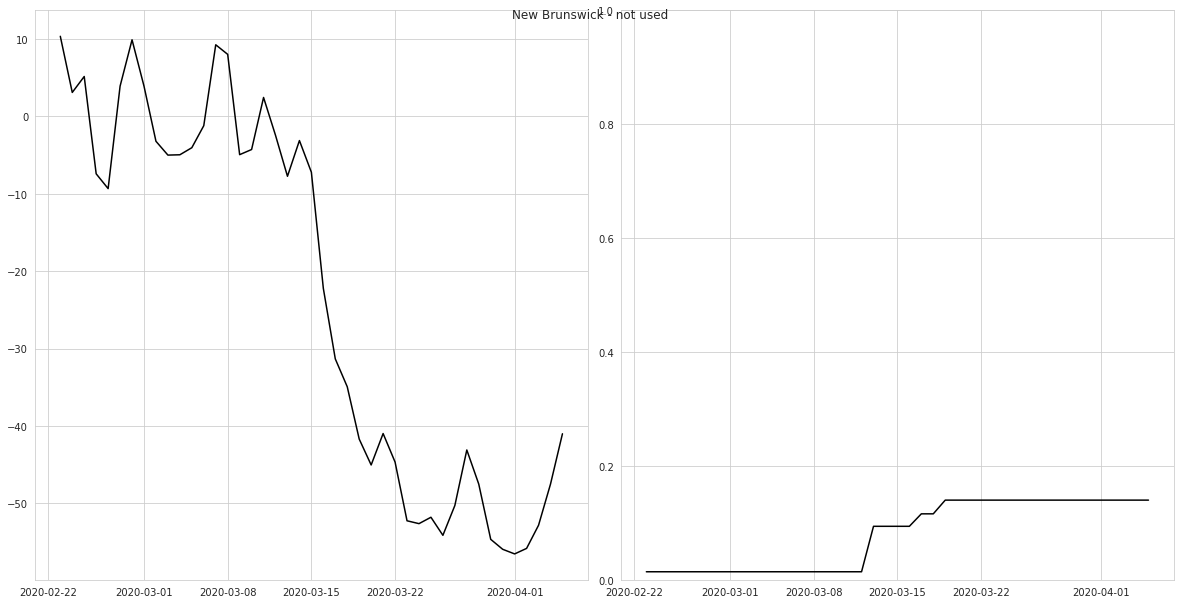

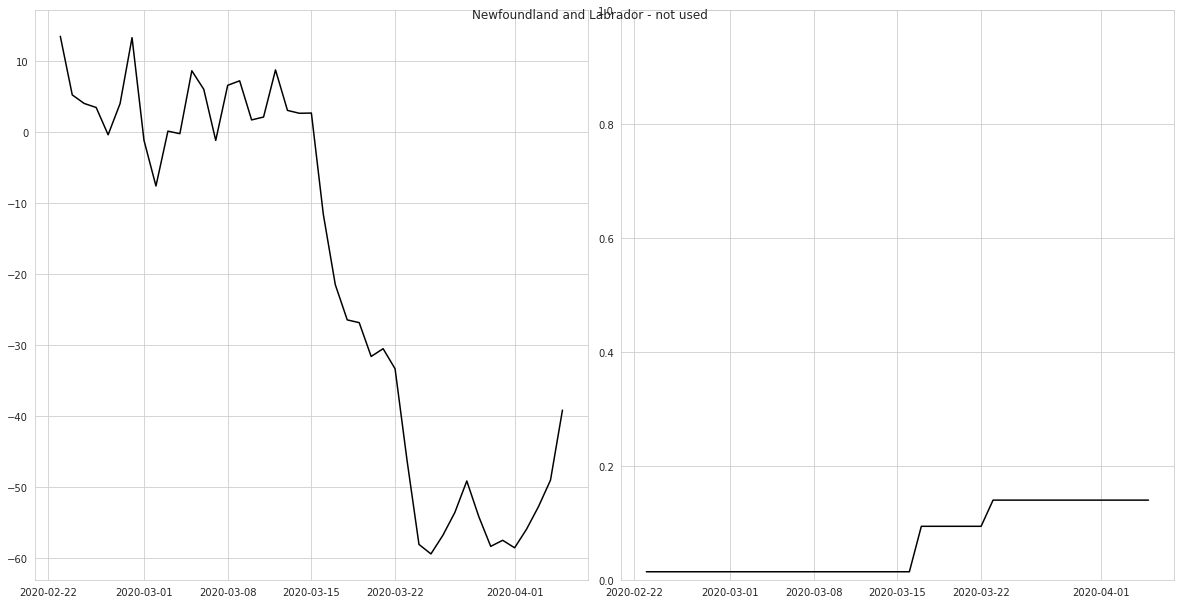

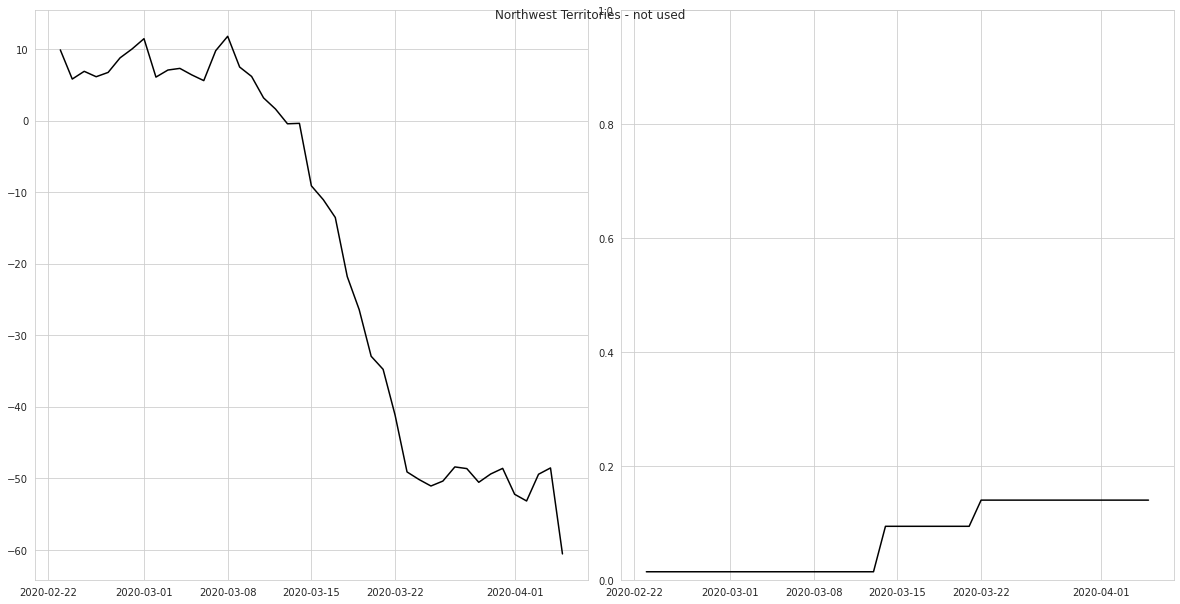

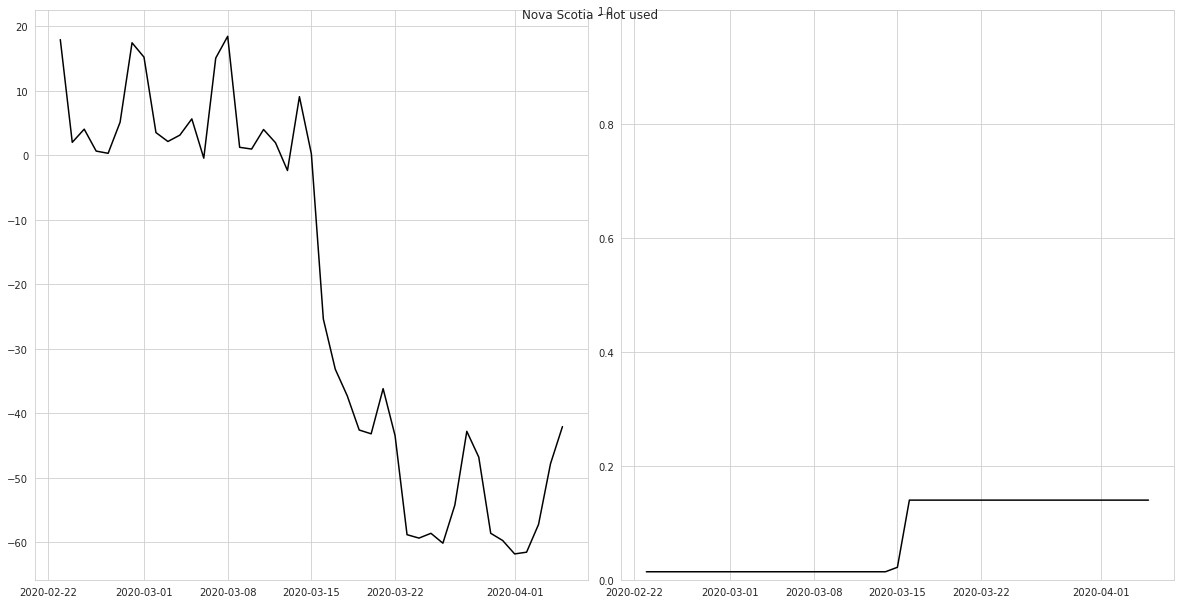

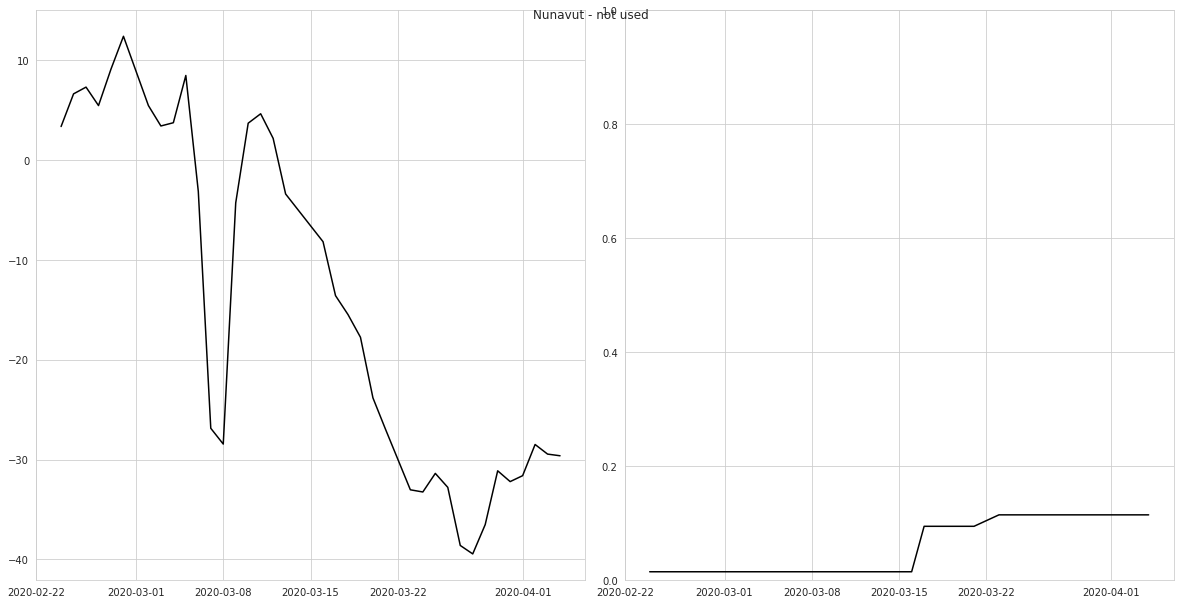

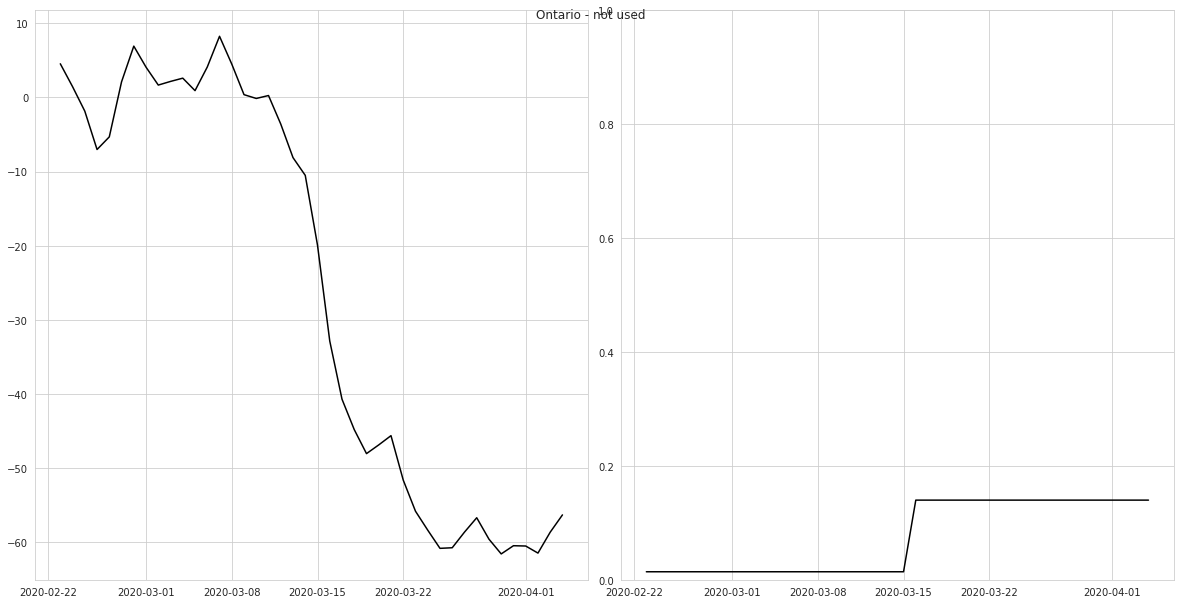

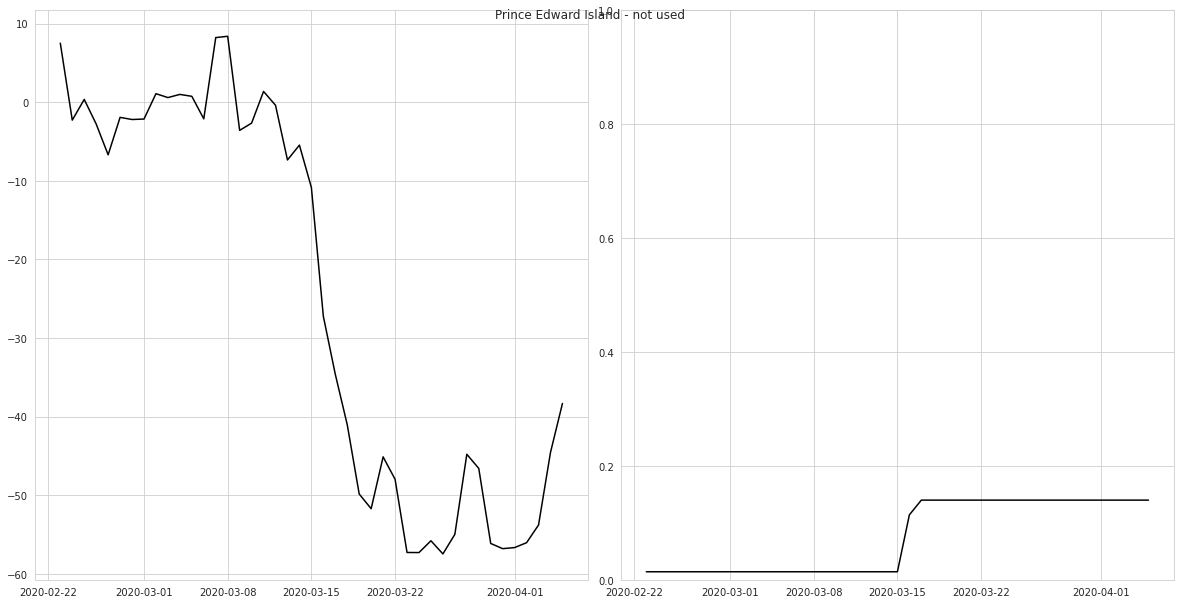

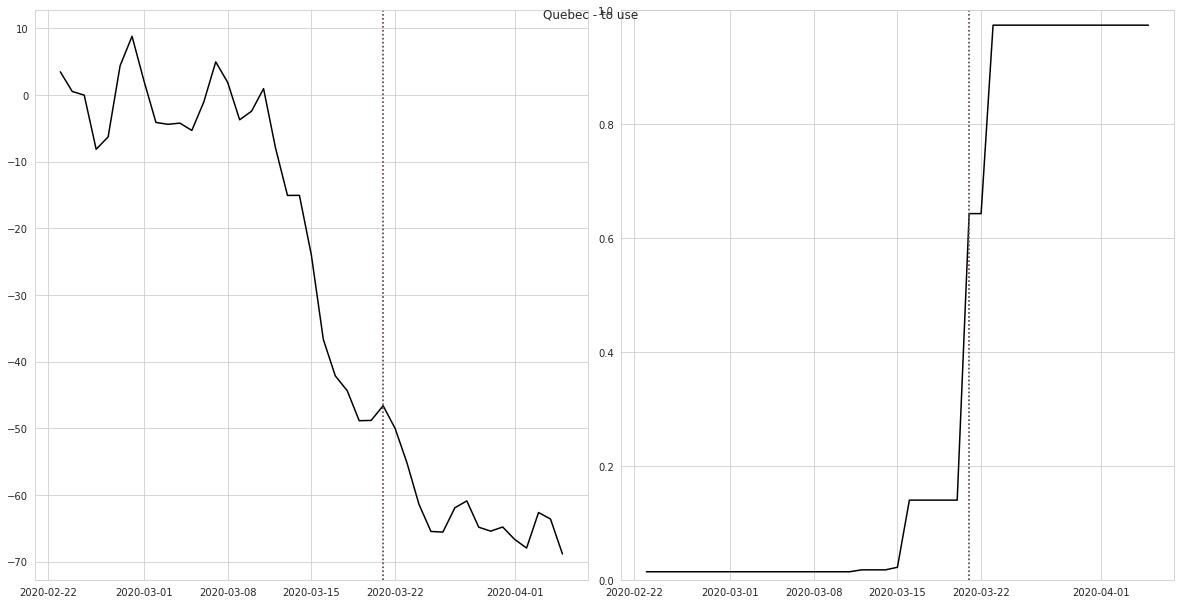

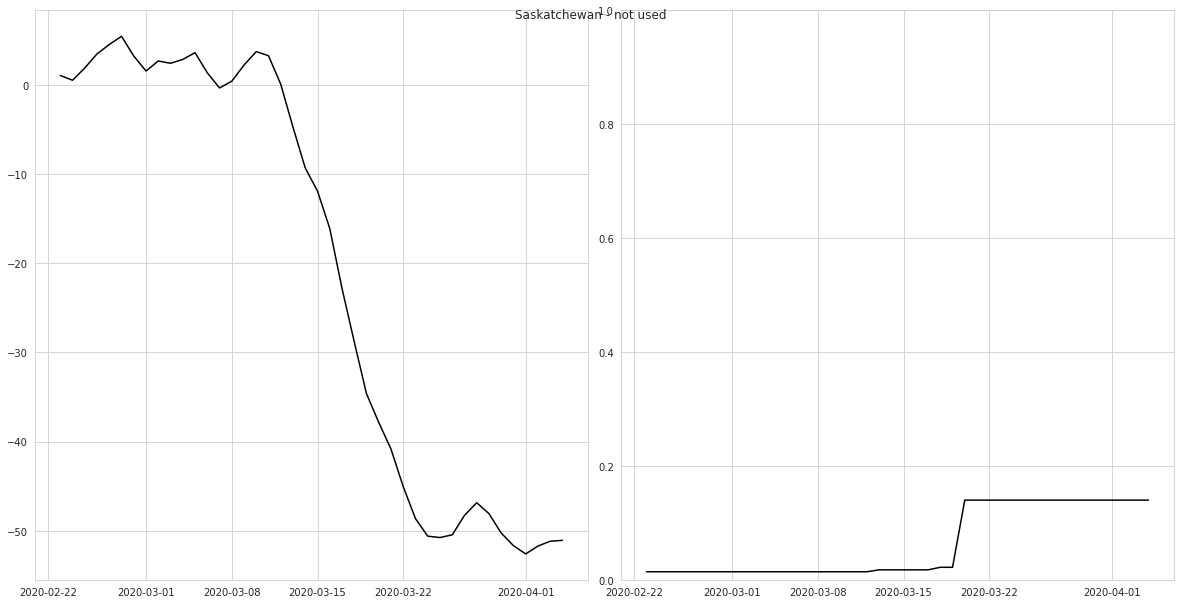

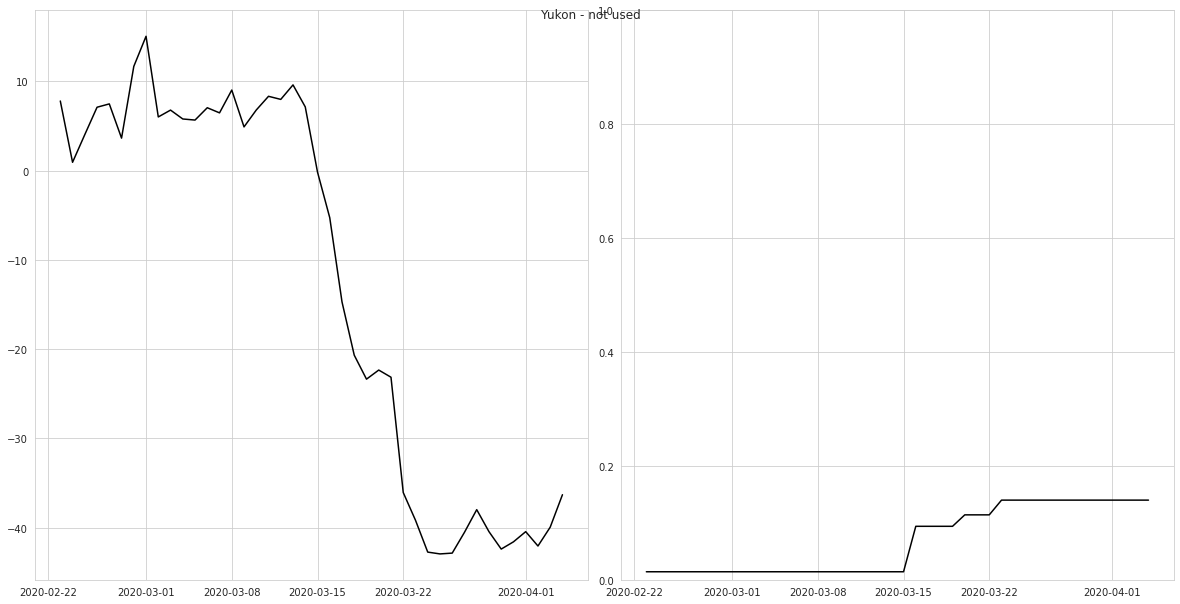

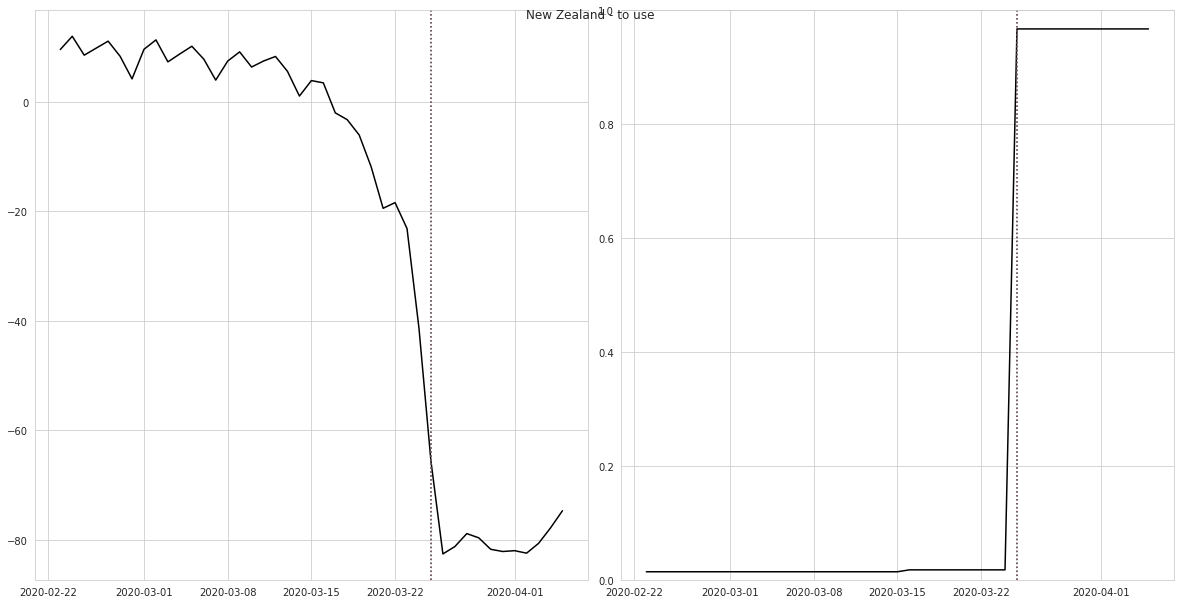

In [10]:
loc_df = get_location_metadata(location_set_id=111, location_set_version_id=630)
date_dfs = []
with PdfPages(f'/ihme/homes/rmbarber/logistic_mobility_preds.pdf') as pdf:
    for location_id in pred_df['location_id'].unique():
        plot_df = pred_df.loc[pred_df['location_id'] == location_id].reset_index(drop=True)
        location = plot_df['Location'][0]
        if not plot_df['R0 date'].isnull().all():
            true_date = plot_df['R0 date'][0]
            prob_true_date = plot_df.loc[plot_df['Date'] == plot_df['R0 date'], 'probability'].item()
        else:
            true_date = None
            prob_true_date = None
        pred_cross_date_l = plot_df.loc[plot_df['probability'] >= 0.4, 'Date'].min()
        pred_cross_date_m = plot_df.loc[plot_df['probability'] >= 0.5, 'Date'].min()
        pred_cross_date_u = plot_df.loc[plot_df['probability'] >= 0.6, 'Date'].min()
        
        # if we have values, add to dataframe
        if pred_cross_date_u is not pd.NaT and \
            (true_date is None or pred_cross_date_u > true_date - timedelta(days=4)):
            date_dfs.append(
                pd.DataFrame({
                    'location_id':location_id,
                    'Location':location,
                    'p40_date':pred_cross_date_l,
                    'p50_date':pred_cross_date_m,
                    'p60_date':pred_cross_date_u
                }, index=[0])
            )
            tag = ' - to use'
        else:
            tag = ' - not used'
        
        # plot
        if location_id in loc_df['location_id'].to_list():
            fig, ax = plt.subplots(1, 2, figsize=(16.5, 8.5))

            # # pop dens
            # ax[0].bar(pop_dens_vars, 
            #         plot_df.loc[plot_df['Date'] == plot_df['Date'].min(), pop_dens_vars].values[0])
            # # ax[0].set_xticks(rotation=60)

            # google
            ax[0].plot(plot_df['Date'],
                       plot_df['avg_mobility'], color='black')  #  ({np.round(coef_dict[google_var], 2)})
            if true_date is not None:
                ax[0].axvline(true_date, color='black', linestyle='--', alpha=0.75)
            if pred_cross_date_u is not pd.NaT:
                ax[0].axvline(pred_cross_date_l, color='forestgreen', linestyle=':', alpha=0.75)
                ax[0].axvline(pred_cross_date_m, color='dodgerblue', linestyle=':', alpha=0.75)
                ax[0].axvline(pred_cross_date_u, color='firebrick', linestyle=':', alpha=0.75)

            # model
            ax[1].plot(plot_df['Date'],
                       plot_df['probability'], color='black')
            if true_date is not None:
                ax[1].axvline(true_date, color='black', linestyle='--', alpha=0.75)
            if pred_cross_date_u is not pd.NaT:
                ax[1].axvline(pred_cross_date_l, color='forestgreen', linestyle=':', alpha=0.75)
                ax[1].axvline(pred_cross_date_m, color='dodgerblue', linestyle=':', alpha=0.75)
                ax[1].axvline(pred_cross_date_u, color='firebrick', linestyle=':', alpha=0.75)
            ax[1].set_ylim(0, 1)
            plt.suptitle(location + tag)
            plt.tight_layout()
            pdf.savefig()

# combine prediction data
date_df = pd.concat(date_dfs).reset_index(drop=True)


In [11]:
date_df = date_df.loc[date_df['location_id'] != 35]  # drop the country Georgia for now
date_df


location_id                            Location   p40_date   p50_date  \
0          35496                             Liguria 2020-03-11 2020-03-11   
1          35497                           Lombardia 2020-03-08 2020-03-08   
2          35502                      Emilia-Romagna 2020-03-11 2020-03-11   
3          35505                              Marche 2020-03-11 2020-03-11   
4          35506                               Lazio 2020-03-11 2020-03-11   
..           ...                                 ...        ...        ...   
140          125                            Colombia 2020-03-25 2020-03-25   
141          133  Venezuela (Bolivarian Republic of) 2020-03-16 2020-03-16   
142          121    Bolivia (Plurinational State of) 2020-03-22 2020-03-22   
143          129                            Honduras 2020-03-16 2020-03-16   
144          114                               Haiti 2020-04-02 2020-04-02   

      p60_date  
0   2020-03-11  
1   2020-03-08  
2   2020-03-11  
3   2020-03-11  
4   2020-03-11  
..         ...  
140 2020-03-25  
141 2020-03-16  
142 2020-03-22  
143 2020-03-16  
144 2020-04-02  

[145 rows x 5 columns]

In [12]:
date_df.to_csv(f'{INPUT_DIR}/R0_dates.csv', index=False)
